In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [4]:
def greedy_compress(g, indice):
    x = g[indice]

#     zero_indices = (x == 0)
#     nonzero_indices = (x != 0)

#     y = x[nonzero_indices]

#     power = torch.maximum(-torch.round(torch.log2(torch.abs(y))), torch.zeros_like(y))
#     bits = torch.ceil(torch.log2(power + 1))

#     y = torch.sign(y) / (2**power)

#     x[nonzero_indices] = y

    result = torch.zeros_like(g)
    result[indice] = x

    return result

In [5]:
import torch
from torch.func import functional_call

def mirror_descent(model, X_train, y_train, param_name, impact: torch.Tensor, lr, eta, lambda_value, num_steps, criterion):
    impact = impact.clone().detach().requires_grad_(True)
    original_param = dict(model.named_parameters())[param_name]

    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    param_grad = torch.autograd.grad(loss, original_param, create_graph=True)[0]
    new_params = {name: param.clone() for name, param in model.named_parameters()}

    for _ in range(num_steps):
        # Update parameter using impact
        param_new = original_param - lr * impact * param_grad
        # Create new parameter dictionary
        new_params[param_name] = param_new
        # Compute outputs with new parameters
        outputs_new = functional_call(model, new_params, (X_train,))
        # Compute new loss
        loss_new = criterion(outputs_new, y_train)

        # Compute gradient of new loss w.r.t. impact
        grad_impact = torch.autograd.grad(loss_new, impact)[0]

        with torch.no_grad():
            impact_update = torch.pow(impact, 1/(1+eta*lambda_value)) * torch.exp(-(eta/(1+eta*lambda_value)) * (grad_impact))
            impact = impact_update / impact_update.sum()

        # Ensure impact requires grad for the next iteration
        impact.requires_grad_(True)

    return impact.detach()


def gradient_descent(model, X_train, y_train, param_name, impact: torch.Tensor, lr, eta, num_steps, criterion):
    impact = impact.clone().detach().requires_grad_(True)
    original_param = dict(model.named_parameters())[param_name]

    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    param_grad = torch.autograd.grad(loss, original_param, create_graph=True)[0]
    new_params = {name: param.clone() for name, param in model.named_parameters()}

    for _ in range(num_steps):
        # Update parameter using impact
        param_new = original_param - lr * impact * param_grad
        # Create new parameter dictionary
        new_params[param_name] = param_new
        # Compute outputs with new parameters
        outputs_new = functional_call(model, new_params, (X_train,))
        # Compute new loss
        loss_new = criterion(outputs_new, y_train)

        # Compute gradient of new loss w.r.t. impact
        grad_impact = torch.autograd.grad(loss_new, impact)[0]

        with torch.no_grad():
            impact -= eta * lr * grad_impact
            impact = torch.clip(impact, 0, 1)
        
        # Ensure impact requires grad for the next iteration
        impact.requires_grad_(True)

    return impact.detach()

In [6]:
from math import ceil
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

def train(model, optimizer, criterion, train_dataset, val_dataset, num_epochs, compression_type, lr, param_usage=0.2, num_steps=10, plot=False, compare_with_topk=False):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    w = {}
    for epoch in trange(num_epochs):
        print('\nEpoch: %d' % epoch)
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        if 'ef' in compression_type:
            g = {name: torch.zeros_like(param)
                for name, param in model.named_parameters()
            }
        
        if epoch == 0 and (compression_type == 'mirror_descent_stochastic'\
                           or compression_type == 'mirror_descent_greedy'\
                           or compression_type == 'mirror_descent_greedy_weighted'\
                           or compression_type == 'mirror_descent_greedy_topk'\
                           or compression_type == 'mirror_descent_weighted_greedy'):
            w = {name: (imp := torch.rand_like(param)) / imp.sum()
                for name, param in model.named_parameters()
            }
        if epoch == 0 and compression_type == 'gradient_descent_weighted_greedy':
            w = {name: torch.ones_like(param)/(max(lr/0.01, 1)) for name, param in model.named_parameters()}
        
        if compare_with_topk:
            relative_intersection = []

        for batch_idx, (inputs, targets) in enumerate(train_dataset):
            inputs, targets = inputs.to(device), targets.to(device)
            if batch_idx == 0 and (compression_type == 'mirror_descent_stochastic'\
                                   or compression_type == 'mirror_descent_greedy'\
                                   or compression_type == 'mirror_descent_greedy_weighted'\
                                   or compression_type == 'mirror_descent_greedy_topk'\
                                   or compression_type == 'mirror_descent_weighted_greedy'):
                for name, param in model.named_parameters():
                    w[name] = mirror_descent(
                        model=model,
                        param_name=name,
                        impact=w[name],
                        lr=lr,
                        eta=2.,
                        lambda_value=0.1,
                        num_steps=num_steps,
                        X_train=inputs,
                        y_train=targets,
                        criterion=criterion
                    )
            if batch_idx == 0 and compression_type == 'gradient_descent_weighted_greedy':
                for name, param in model.named_parameters():
                    w[name] = gradient_descent(
                        model=model,
                        param_name=name,
                        impact=w[name],
                        lr=lr,
                        eta=100000.,
                        num_steps=num_steps,
                        X_train=inputs,
                        y_train=targets,
                        criterion=criterion
                    )
                    if plot and 'weight' in name:
                        plt.hist(w[name].cpu().detach().flatten(), bins=50, label=name)
                        plt.show()
                        print(f'{name} min: {w[name].min():.5f}, max: {w[name].max():.5f}, min/max: {w[name].min()/w[name].max():.3f}')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            if compression_type == 'square_stochastic':
                for param in model.parameters():
                    w = param.grad.flatten()**2
                    indice = torch.multinomial(w, ceil(param_usage * len(w)))
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'square_greedy':
                for param in model.parameters():
                    w = param.grad.flatten()**2
                    indice = torch.argsort(w, descending=True)[:ceil(param_usage * len(w))]
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'square_greedy_ef':
                for name, param in model.named_parameters():
                    diff = param.grad - g[name]
                    indice = torch.argsort(diff.flatten().abs(), descending=True)[:ceil(param_usage * len(param.flatten()))]
                    c = greedy_compress(diff.flatten(), indice).reshape(param.shape)
                    param.grad.copy_(g[name] + c)
                    g[name] += c
            elif compression_type == 'random':
                for param in model.parameters():
                    w = torch.ones_like(param.grad.flatten())
                    indice = torch.multinomial(w, ceil(param_usage * len(w)))
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'mirror_descent_stochastic':
                for name, param in model.named_parameters():
                    indice = torch.multinomial(w[name].flatten(), ceil(param_usage * len(w[name].flatten())))
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'mirror_descent_greedy':
                for name, param in model.named_parameters():
                    indice = torch.argsort(w[name].flatten(), descending=True)[:ceil(param_usage * len(w[name].flatten()))]
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'mirror_descent_greedy_weighted':
                for name, param in model.named_parameters():
                    indice = torch.argsort(w[name].flatten(), descending=True)[:ceil(param_usage * len(w[name].flatten()))]
                    
                    weights = torch.zeros_like(w[name])
                    weights.flatten()[indice] = w[name].flatten()[indice]
                    weights *= ceil(param_usage * len(w[name].flatten())) / weights.sum()
                    
                    param.grad *= weights.reshape(param.shape)
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'mirror_descent_greedy_topk':
                for name, param in model.named_parameters():
                    indice1 = torch.argsort(param.grad.flatten()**2, descending=True)[:ceil(2 * param_usage * len(param.flatten()))]
                    indice2 = torch.argsort(w[name].flatten()[indice1], descending=True)[:ceil(param_usage * len(w[name].flatten()))]
                    g = torch.zeros_like(param.grad.flatten())
                    g[indice1[indice2]] = param.grad.flatten()[indice1[indice2]]
                    param.grad.copy_(greedy_compress(g, indice1[indice2]).reshape(param.shape))
            elif compression_type == 'mirror_descent_weighted_greedy':
                for name, param in model.named_parameters():
                    indice = torch.argsort((param.grad.abs() * w[name]).flatten(), descending=True)[:ceil(param_usage * len(w[name].flatten()))]
                    
                    weights = torch.zeros_like(w[name])
                    weights.flatten()[indice] = w[name].flatten()[indice]
                    weights *= ceil(param_usage * len(w[name].flatten())) / weights.sum()
                    
                    param.grad *= weights.reshape(param.shape)
                    param.grad.copy_(greedy_compress(param.grad.flatten(), indice).reshape(param.shape))
            elif compression_type == 'gradient_descent_weighted_greedy':
                if compare_with_topk:
                    inter_count = 0
                    total_count = 0
                for name, param in model.named_parameters():
                    indices = torch.argsort((param.grad.abs() * w[name]).flatten(), descending=True)[:ceil(param_usage * len(w[name].flatten()))]
                    
                    if compare_with_topk:
                        top_k_indices = torch.argsort(param.grad.flatten().abs(), descending=True)[:ceil(param_usage * len(param.flatten()))]
                        intersection = (set(top_k_indices.tolist()) & set(indices.tolist()))
                        inter_count += len(intersection)
                        total_count += len(top_k_indices)

                    weights = torch.zeros_like(w[name])
                    weights.flatten()[indices] = w[name].flatten()[indices]
                    
                    param.grad.copy_(greedy_compress((weights * param.grad).flatten(), indices).reshape(param.shape))
                if compare_with_topk:
                    relative_intersection.append(inter_count/total_count)
            else:
                raise ValueError(f"Compression type {compression_type} not supported")
            
            
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        if compare_with_topk:
            print(f'Relative intrsection: {np.mean(relative_intersection):.3f}')

        train_loss /= len(train_dataset)
        train_accuracy = 100. * correct / total
        train_log.append(train_loss)
        train_acc_log.append(train_accuracy)
        
        print('Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)' % (train_loss, train_accuracy, correct, total))
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_dataset:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        val_loss /= len(val_dataset)
        val_accuracy = 100. * correct / total
        val_log.append(val_loss)
        val_acc_log.append(val_accuracy)
        
        print('Validation Loss: %.3f | Validation Acc: %.3f%% (%d/%d)' % (val_loss, val_accuracy, correct, total))
    
    return train_log, train_acc_log, val_log, val_acc_log

In [8]:
param_usage = 0.01
num_epochs = 10
lrs = [0.03]

compression_type = 'gradient_descent_weighted_greedy'

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for lr in lrs:
    set_seed(52)
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_log[lr], train_acc[lr], test_log[lr], test_acc[lr] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr, compare_with_topk=True)

  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 0
Relative intrsection: 0.963
Train Loss: 1.672 | Train Acc: 16.708% (18689/111854)


 10%|█         | 1/10 [02:36<23:25, 156.18s/it]

Validation Loss: 1.513 | Validation Acc: 46.020% (4602/10000)

Epoch: 1
Relative intrsection: 0.940
Train Loss: 1.354 | Train Acc: 22.618% (25299/111854)


 20%|██        | 2/10 [15:39<1:10:02, 525.29s/it]

Validation Loss: 1.217 | Validation Acc: 56.720% (5672/10000)

Epoch: 2
Relative intrsection: 0.917
Train Loss: 1.169 | Train Acc: 26.009% (29092/111854)


 30%|███       | 3/10 [18:18<41:45, 357.87s/it]  

Validation Loss: 1.135 | Validation Acc: 59.680% (5968/10000)

Epoch: 3
Relative intrsection: 0.902
Train Loss: 1.042 | Train Acc: 28.130% (31464/111854)


 40%|████      | 4/10 [20:58<27:57, 279.67s/it]

Validation Loss: 1.092 | Validation Acc: 61.990% (6199/10000)

Epoch: 4
Relative intrsection: 0.889
Train Loss: 0.936 | Train Acc: 30.027% (33586/111854)


 50%|█████     | 5/10 [23:37<19:40, 236.14s/it]

Validation Loss: 1.101 | Validation Acc: 63.420% (6342/10000)

Epoch: 5
Relative intrsection: 0.876
Train Loss: 0.854 | Train Acc: 31.217% (34918/111854)


 60%|██████    | 6/10 [26:14<13:57, 209.27s/it]

Validation Loss: 1.167 | Validation Acc: 61.780% (6178/10000)

Epoch: 6


 60%|██████    | 6/10 [26:31<17:41, 265.33s/it]


KeyboardInterrupt: 

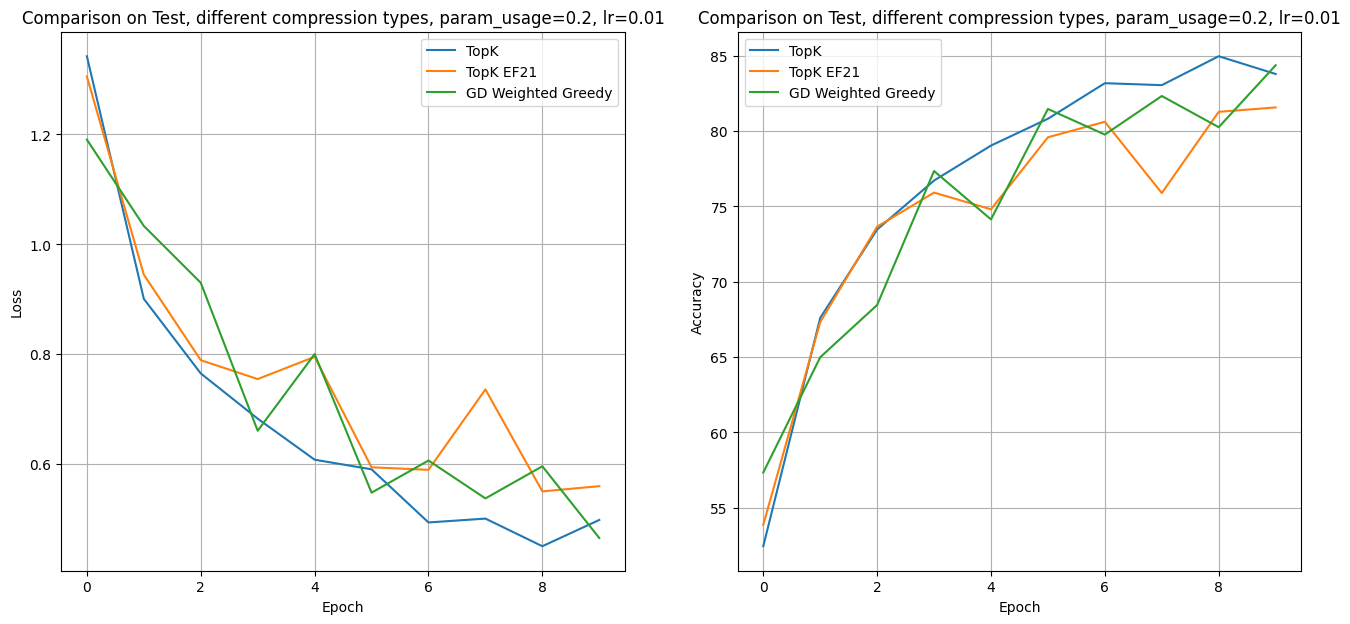

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

names = {
    'mirror_descent_stochastic': 'MD Stochastic',
    'mirror_descent_weighted_greedy': 'MD Weighted Greedy',
    'gradient_descent_weighted_greedy': 'GD Weighted Greedy',
    'mirror_descent_greedy_topk': 'TopK+MD Greedy',
    'mirror_descent_greedy': 'MD Greedy',
    'mirror_descent_greedy_weighted': 'MD Greedy Weighted',
    'random': 'RandK',
    'square_greedy': 'TopK',
    'square_greedy_ef': 'TopK EF21'
}

for compression_type in test_log:
    axs[0].plot(test_log[compression_type], label=names[compression_type])
    axs[1].plot(test_acc[compression_type], label=names[compression_type])

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.2, lr=0.01")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.2, lr=0.01")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]


Epoch: 0


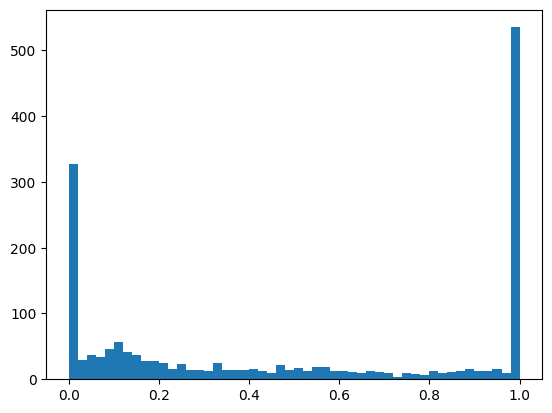

conv1.weight min: 0.00000, max: 1.00000, min/max: 0.000


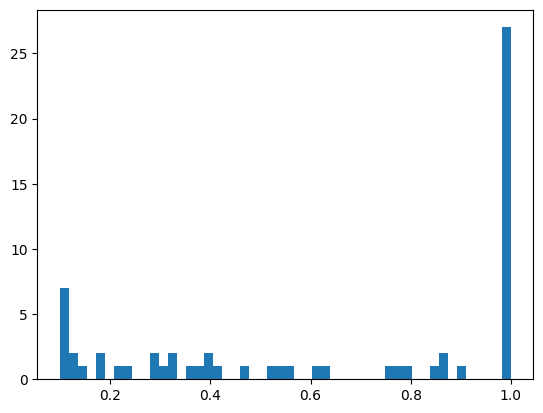

bn1.weight min: 0.09939, max: 1.00000, min/max: 0.099


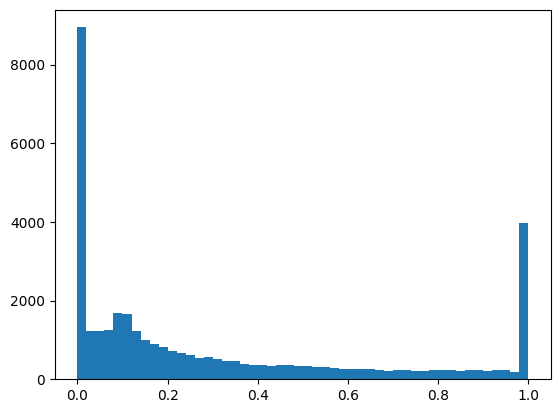

layer1.0.conv1.weight min: 0.00000, max: 1.00000, min/max: 0.000


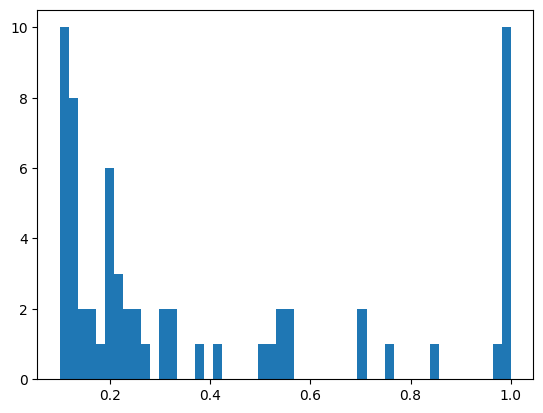

layer1.0.bn1.weight min: 0.09998, max: 1.00000, min/max: 0.100


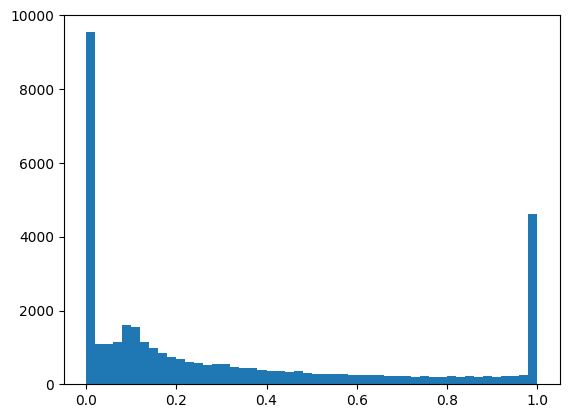

layer1.0.conv2.weight min: 0.00000, max: 1.00000, min/max: 0.000


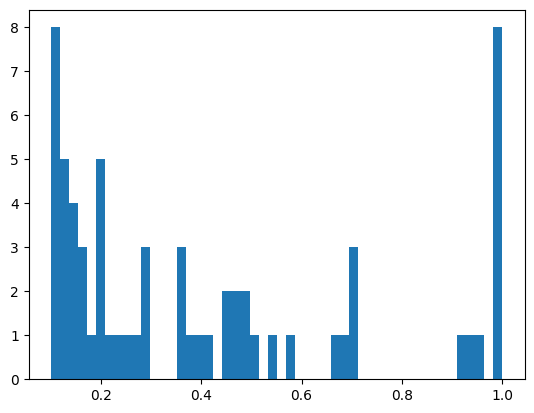

layer1.0.bn2.weight min: 0.10012, max: 1.00000, min/max: 0.100


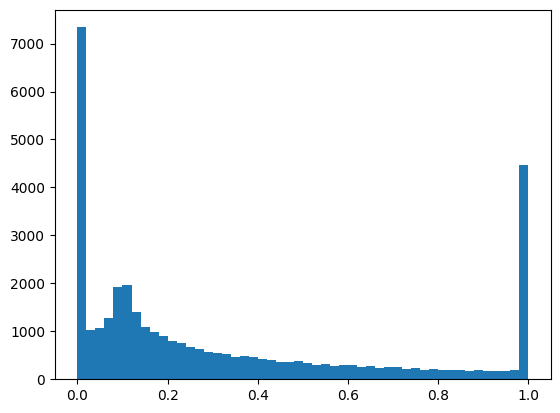

layer1.1.conv1.weight min: 0.00000, max: 1.00000, min/max: 0.000


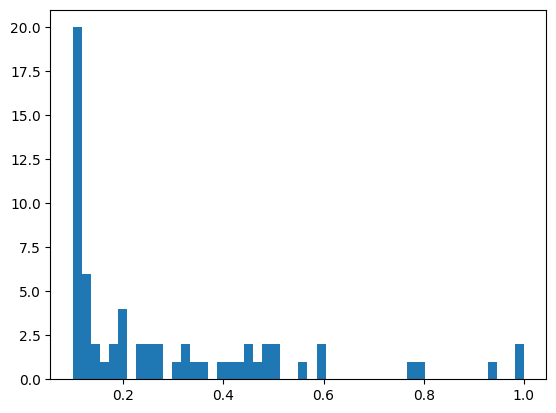

layer1.1.bn1.weight min: 0.10003, max: 1.00000, min/max: 0.100


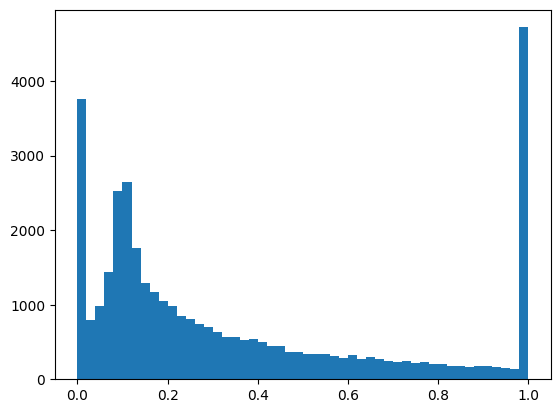

layer1.1.conv2.weight min: 0.00000, max: 1.00000, min/max: 0.000


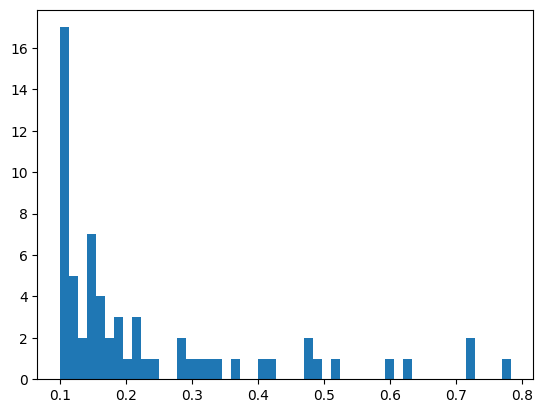

layer1.1.bn2.weight min: 0.10008, max: 0.78275, min/max: 0.128


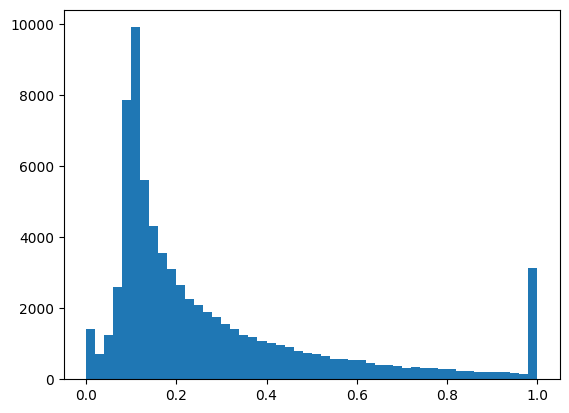

layer2.0.conv1.weight min: 0.00000, max: 1.00000, min/max: 0.000


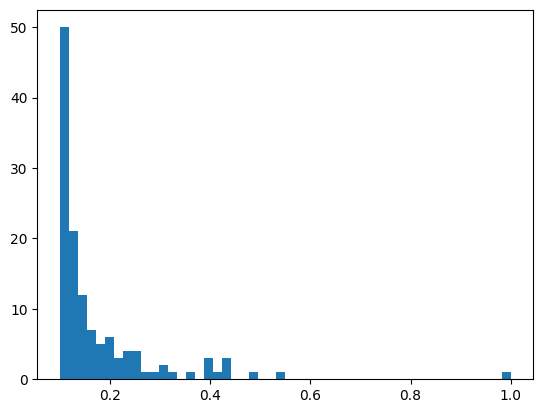

layer2.0.bn1.weight min: 0.09998, max: 1.00000, min/max: 0.100


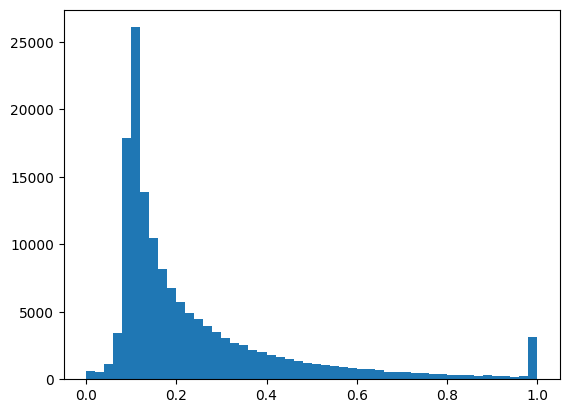

layer2.0.conv2.weight min: 0.00000, max: 1.00000, min/max: 0.000


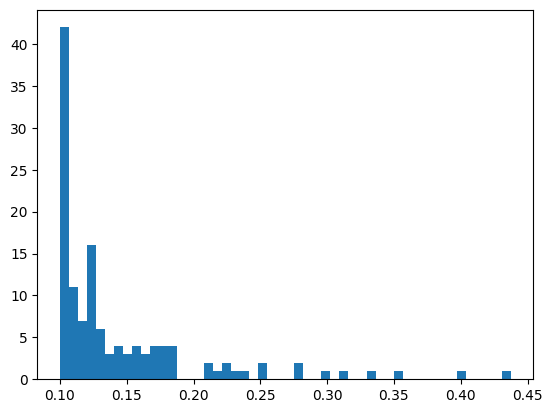

layer2.0.bn2.weight min: 0.09998, max: 0.43749, min/max: 0.229


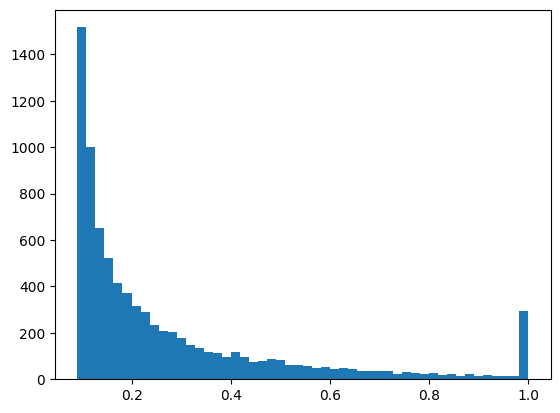

layer2.0.shortcut.0.weight min: 0.09030, max: 1.00000, min/max: 0.090


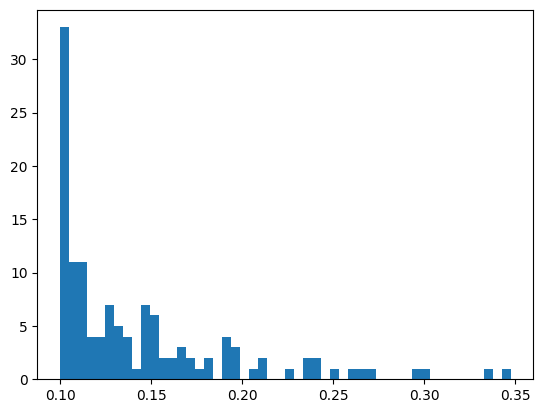

layer2.0.shortcut.1.weight min: 0.09986, max: 0.34750, min/max: 0.287


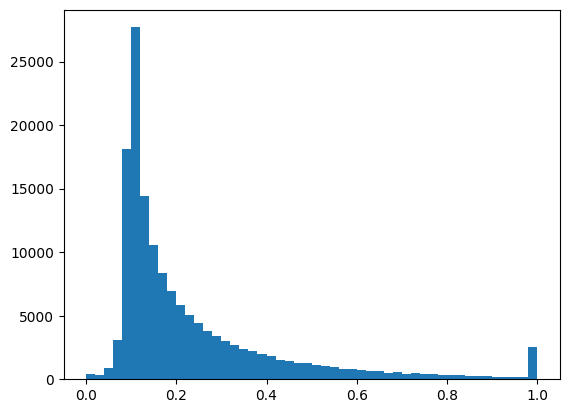

layer2.1.conv1.weight min: 0.00000, max: 1.00000, min/max: 0.000


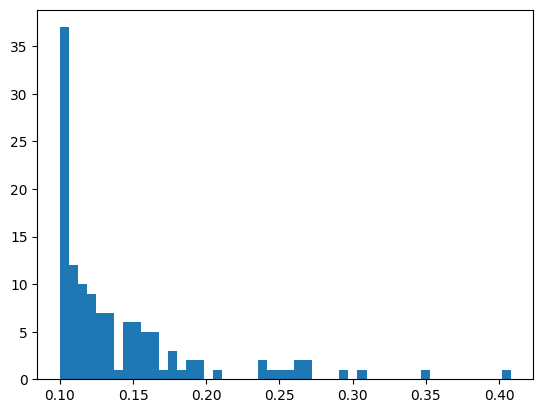

layer2.1.bn1.weight min: 0.10000, max: 0.40803, min/max: 0.245


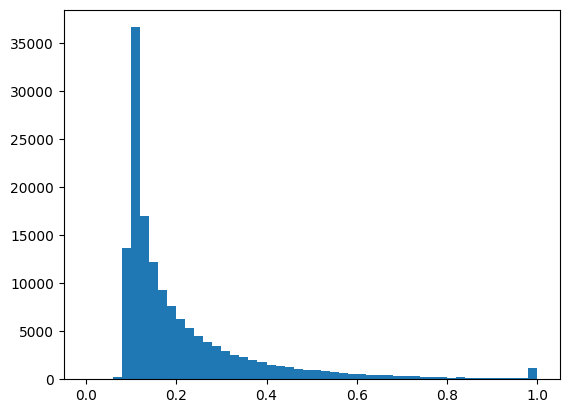

layer2.1.conv2.weight min: 0.00000, max: 1.00000, min/max: 0.000


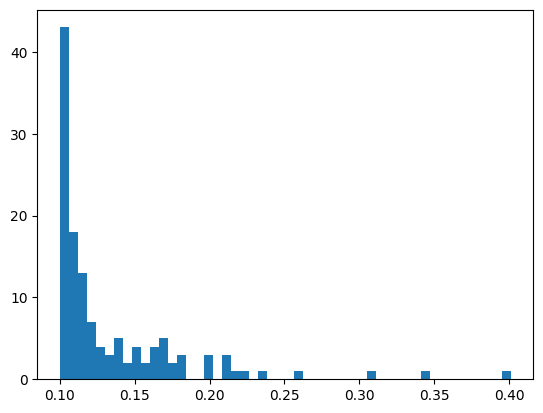

layer2.1.bn2.weight min: 0.10000, max: 0.40114, min/max: 0.249


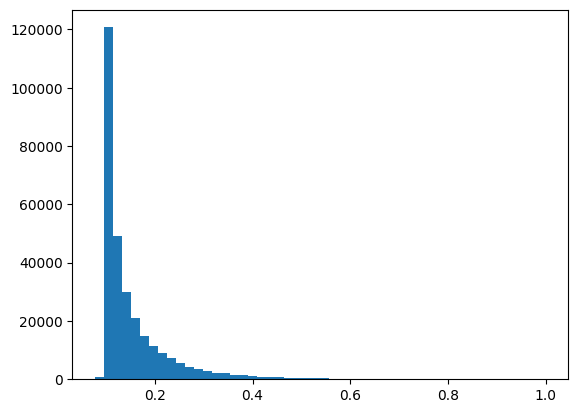

layer3.0.conv1.weight min: 0.07756, max: 1.00000, min/max: 0.078


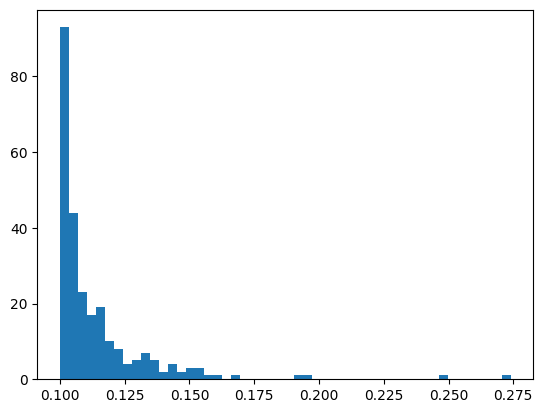

layer3.0.bn1.weight min: 0.09999, max: 0.27404, min/max: 0.365


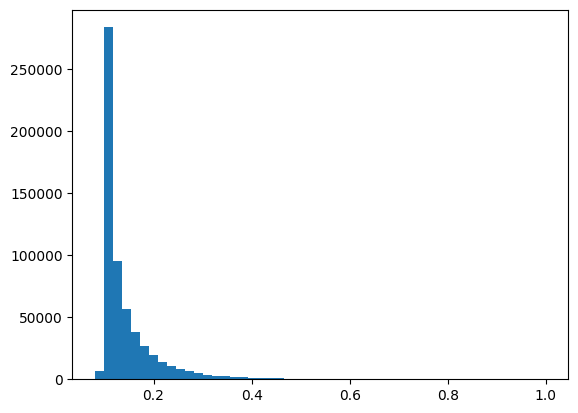

layer3.0.conv2.weight min: 0.08047, max: 1.00000, min/max: 0.080


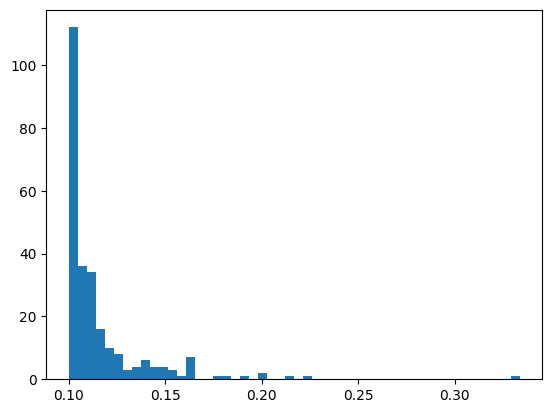

layer3.0.bn2.weight min: 0.10000, max: 0.33366, min/max: 0.300


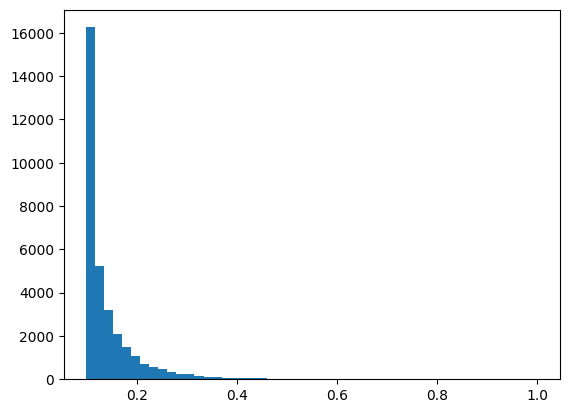

layer3.0.shortcut.0.weight min: 0.09931, max: 1.00000, min/max: 0.099


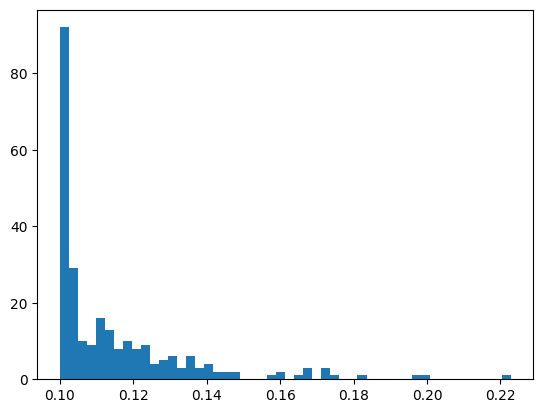

layer3.0.shortcut.1.weight min: 0.10000, max: 0.22281, min/max: 0.449


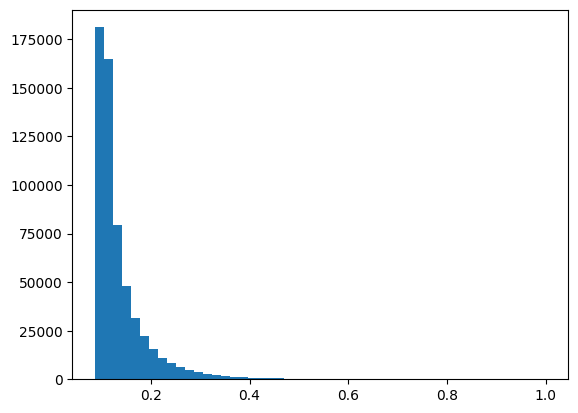

layer3.1.conv1.weight min: 0.08688, max: 1.00000, min/max: 0.087


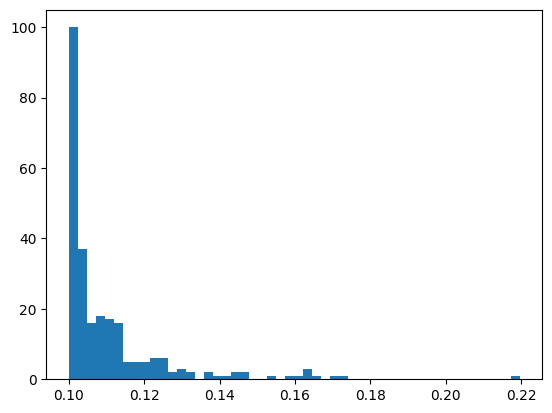

layer3.1.bn1.weight min: 0.10000, max: 0.21954, min/max: 0.456


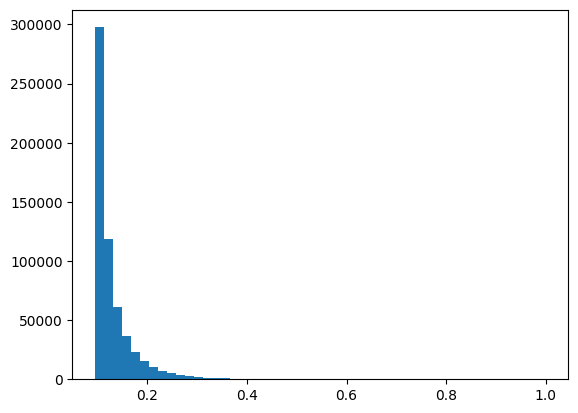

layer3.1.conv2.weight min: 0.09463, max: 1.00000, min/max: 0.095


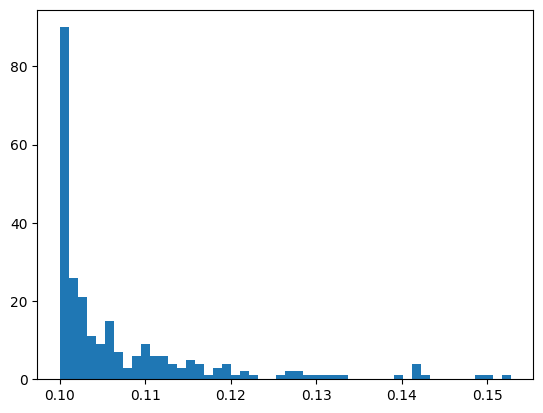

layer3.1.bn2.weight min: 0.10000, max: 0.15276, min/max: 0.655


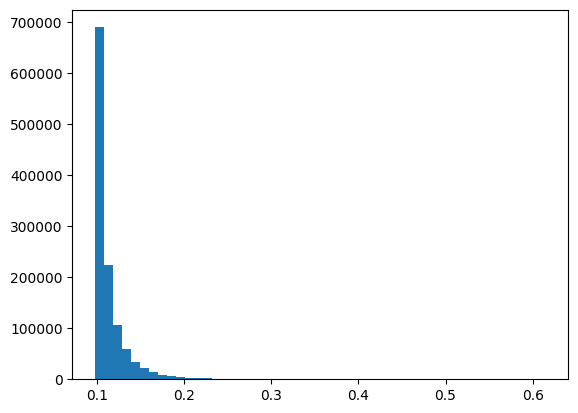

layer4.0.conv1.weight min: 0.09768, max: 0.61507, min/max: 0.159


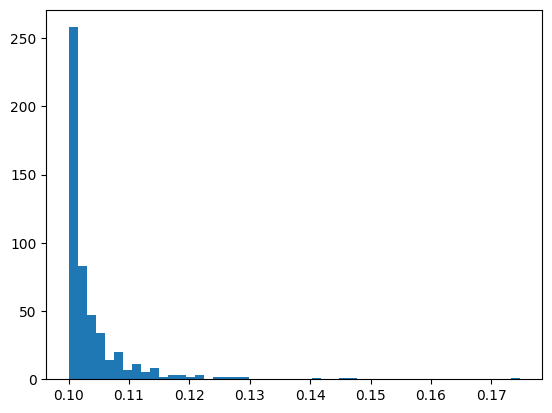

layer4.0.bn1.weight min: 0.10000, max: 0.17468, min/max: 0.572


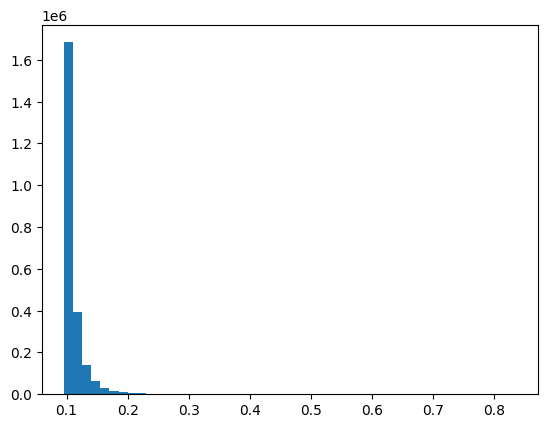

layer4.0.conv2.weight min: 0.09637, max: 0.83464, min/max: 0.115


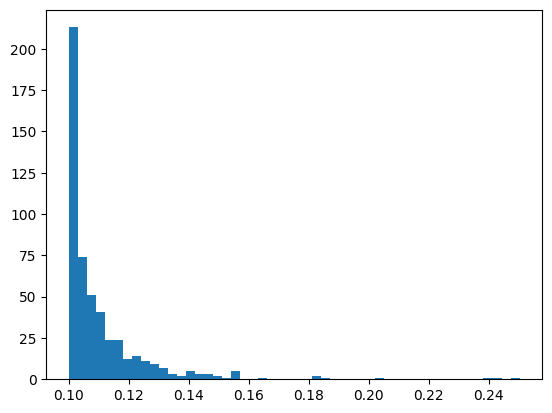

layer4.0.bn2.weight min: 0.10000, max: 0.25023, min/max: 0.400


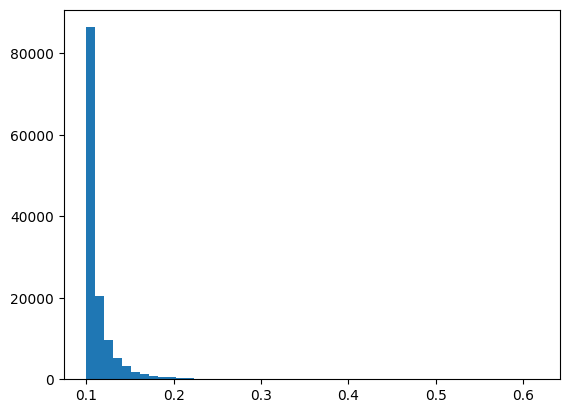

layer4.0.shortcut.0.weight min: 0.09967, max: 0.61601, min/max: 0.162


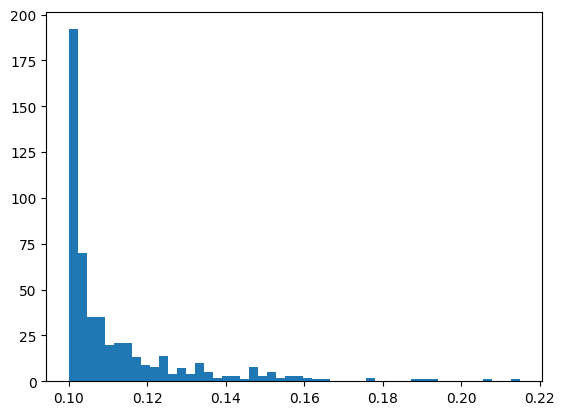

layer4.0.shortcut.1.weight min: 0.10000, max: 0.21492, min/max: 0.465


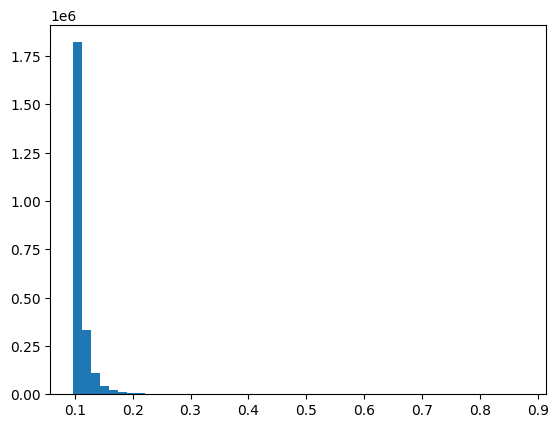

layer4.1.conv1.weight min: 0.09697, max: 0.87604, min/max: 0.111


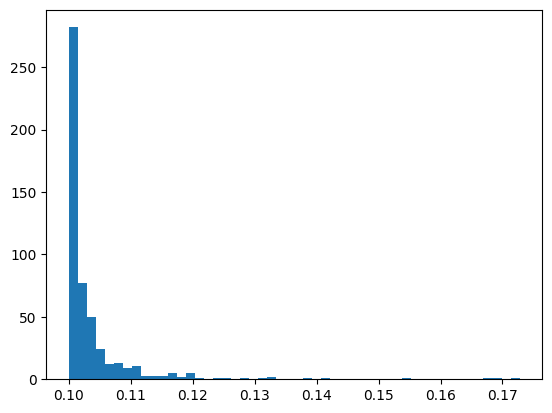

layer4.1.bn1.weight min: 0.10000, max: 0.17275, min/max: 0.579


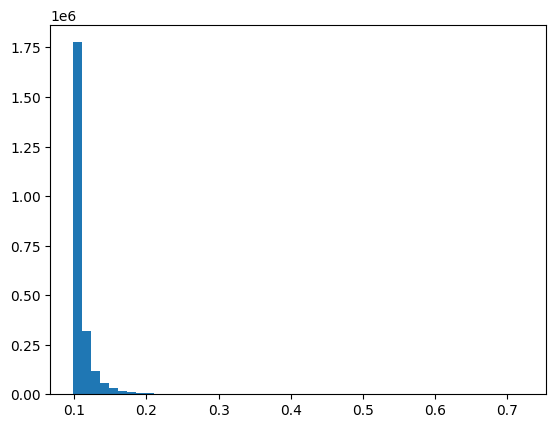

layer4.1.conv2.weight min: 0.09834, max: 0.72283, min/max: 0.136


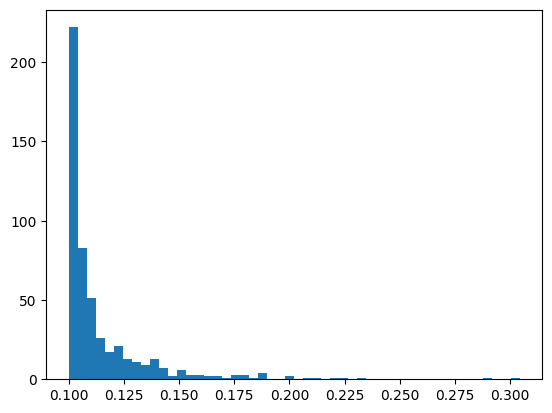

layer4.1.bn2.weight min: 0.10000, max: 0.30432, min/max: 0.329


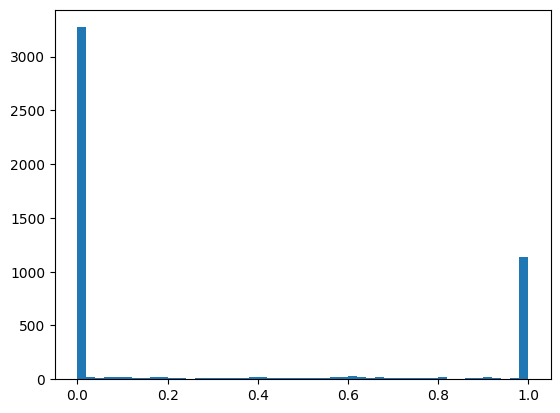

linear.weight min: 0.00000, max: 1.00000, min/max: 0.000
Train Loss: 1.644 | Train Acc: 40.444% (20222/50000)


100%|██████████| 1/1 [00:26<00:00, 26.58s/it]

Validation Loss: 1.311 | Validation Acc: 51.220% (5122/10000)


In [14]:
param_usage = 0.2
num_epochs = 1
lrs = [0.1]

compression_type = 'gradient_descent_weighted_greedy'

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for lr in lrs:
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_log[lr], train_acc[lr], test_log[lr], test_acc[lr] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr, plot=True)

In [ ]:
param_usage = 0.2
num_epochs = 10
lrs = [0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]

compression_type = 'gradient_descent_weighted_greedy'

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for lr in lrs:
    set_seed(52)
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_log[lr], train_acc[lr], test_log[lr], test_acc[lr] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr)

  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.571 | Train Acc: 41.516% (20758/50000)


 10%|█         | 1/10 [00:22<03:19, 22.17s/it]

Validation Loss: 1.280 | Validation Acc: 53.680% (5368/10000)

Epoch: 1
Train Loss: 1.164 | Train Acc: 58.072% (29036/50000)


 20%|██        | 2/10 [00:44<02:59, 22.42s/it]

Validation Loss: 1.030 | Validation Acc: 62.980% (6298/10000)

Epoch: 2


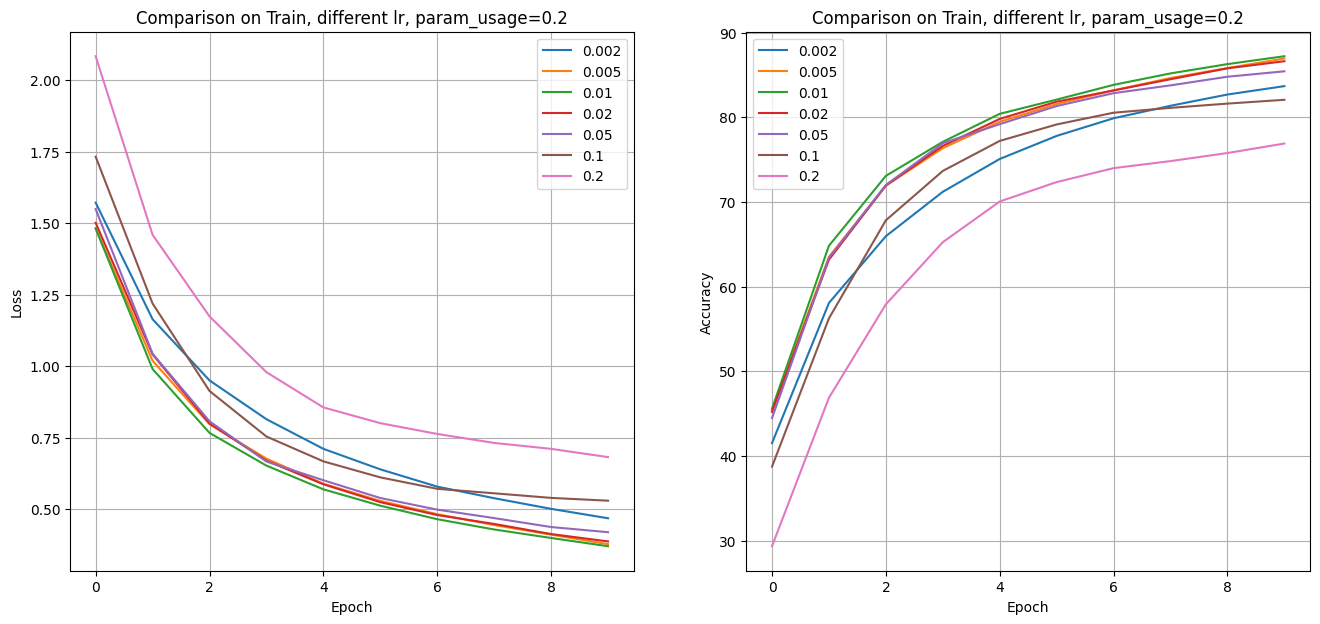

In [22]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for lr in test_log:
    axs[0].plot(train_log[lr], label=lr)
    axs[1].plot(train_acc[lr], label=lr)

axs[0].set_title("Comparison on Train, different lr, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Train, different lr, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

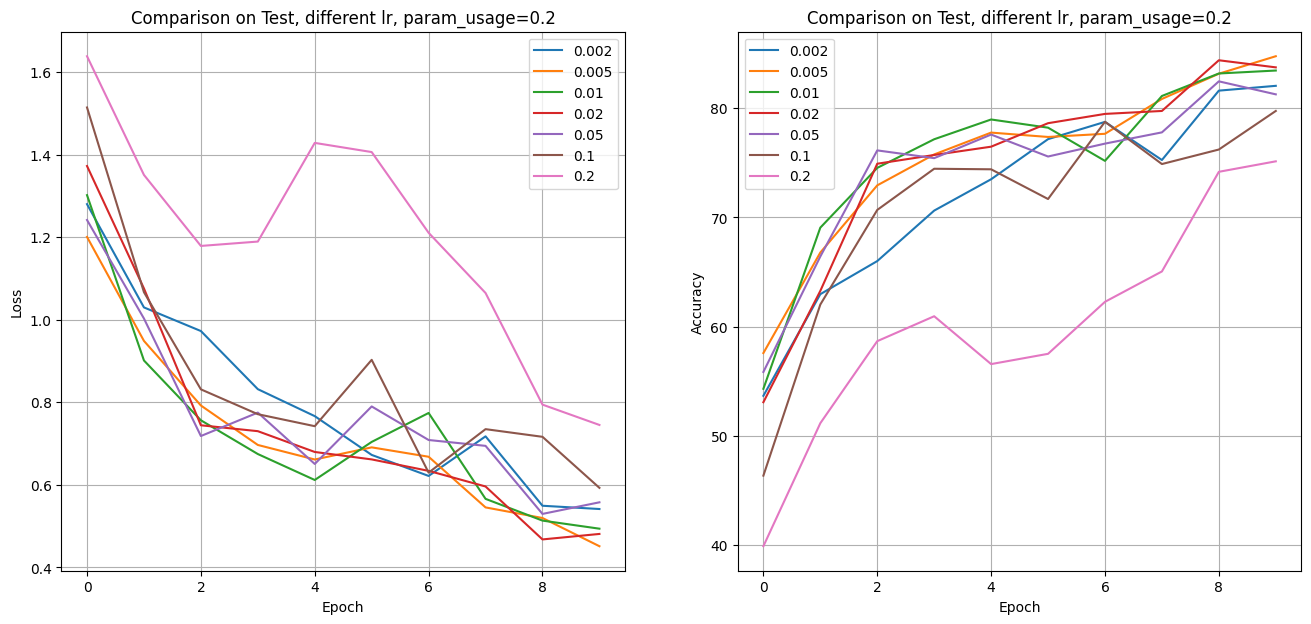

In [23]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for lr in test_log:
    axs[0].plot(test_log[lr], label=lr)
    axs[1].plot(test_acc[lr], label=lr)

axs[0].set_title("Comparison on Test, different lr, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different lr, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

In [24]:
param_usage = 0.2
num_epochs = 5
lrs = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]

compression_type = 'square_greedy'

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for lr in lrs:
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_log[lr], train_acc[lr], test_log[lr], test_acc[lr] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr)

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.682 | Train Acc: 37.698% (18849/50000)


 20%|██        | 1/5 [00:13<00:53, 13.28s/it]

Validation Loss: 1.463 | Validation Acc: 46.660% (4666/10000)

Epoch: 1
Train Loss: 1.300 | Train Acc: 52.562% (26281/50000)


 40%|████      | 2/5 [00:27<00:40, 13.56s/it]

Validation Loss: 1.219 | Validation Acc: 56.210% (5621/10000)

Epoch: 2
Train Loss: 1.103 | Train Acc: 60.542% (30271/50000)


 60%|██████    | 3/5 [00:40<00:26, 13.31s/it]

Validation Loss: 1.141 | Validation Acc: 60.890% (6089/10000)

Epoch: 3
Train Loss: 0.958 | Train Acc: 65.874% (32937/50000)


 80%|████████  | 4/5 [00:52<00:12, 12.99s/it]

Validation Loss: 1.079 | Validation Acc: 63.310% (6331/10000)

Epoch: 4
Train Loss: 0.847 | Train Acc: 70.018% (35009/50000)


100%|██████████| 5/5 [01:05<00:00, 13.14s/it]


Validation Loss: 0.817 | Validation Acc: 71.500% (7150/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.605 | Train Acc: 40.684% (20342/50000)


 20%|██        | 1/5 [00:13<00:54, 13.52s/it]

Validation Loss: 1.418 | Validation Acc: 49.470% (4947/10000)

Epoch: 1
Train Loss: 1.178 | Train Acc: 57.432% (28716/50000)


 40%|████      | 2/5 [00:27<00:40, 13.50s/it]

Validation Loss: 1.101 | Validation Acc: 60.390% (6039/10000)

Epoch: 2
Train Loss: 0.982 | Train Acc: 65.006% (32503/50000)


 60%|██████    | 3/5 [00:39<00:25, 12.84s/it]

Validation Loss: 1.073 | Validation Acc: 62.880% (6288/10000)

Epoch: 3
Train Loss: 0.842 | Train Acc: 69.912% (34956/50000)


 80%|████████  | 4/5 [00:52<00:13, 13.05s/it]

Validation Loss: 0.967 | Validation Acc: 67.600% (6760/10000)

Epoch: 4
Train Loss: 0.732 | Train Acc: 74.444% (37222/50000)


100%|██████████| 5/5 [01:05<00:00, 13.09s/it]


Validation Loss: 0.788 | Validation Acc: 72.790% (7279/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.469 | Train Acc: 45.938% (22969/50000)


 20%|██        | 1/5 [00:13<00:54, 13.66s/it]

Validation Loss: 1.215 | Validation Acc: 56.930% (5693/10000)

Epoch: 1
Train Loss: 1.015 | Train Acc: 63.592% (31796/50000)


 40%|████      | 2/5 [00:26<00:40, 13.37s/it]

Validation Loss: 0.962 | Validation Acc: 65.640% (6564/10000)

Epoch: 2
Train Loss: 0.798 | Train Acc: 71.984% (35992/50000)


 60%|██████    | 3/5 [00:38<00:24, 12.49s/it]

Validation Loss: 0.813 | Validation Acc: 72.470% (7247/10000)

Epoch: 3
Train Loss: 0.670 | Train Acc: 76.642% (38321/50000)


 80%|████████  | 4/5 [00:51<00:12, 12.87s/it]

Validation Loss: 0.838 | Validation Acc: 71.950% (7195/10000)

Epoch: 4
Train Loss: 0.586 | Train Acc: 79.350% (39675/50000)


100%|██████████| 5/5 [01:04<00:00, 12.88s/it]


Validation Loss: 0.686 | Validation Acc: 76.330% (7633/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.470 | Train Acc: 45.748% (22874/50000)


 20%|██        | 1/5 [00:13<00:54, 13.71s/it]

Validation Loss: 1.278 | Validation Acc: 55.910% (5591/10000)

Epoch: 1
Train Loss: 1.008 | Train Acc: 64.056% (32028/50000)


 40%|████      | 2/5 [00:26<00:40, 13.37s/it]

Validation Loss: 0.988 | Validation Acc: 66.370% (6637/10000)

Epoch: 2
Train Loss: 0.785 | Train Acc: 72.418% (36209/50000)


 60%|██████    | 3/5 [00:40<00:27, 13.57s/it]

Validation Loss: 0.875 | Validation Acc: 70.400% (7040/10000)

Epoch: 3
Train Loss: 0.660 | Train Acc: 77.086% (38543/50000)


 80%|████████  | 4/5 [00:54<00:13, 13.66s/it]

Validation Loss: 0.701 | Validation Acc: 76.720% (7672/10000)

Epoch: 4
Train Loss: 0.569 | Train Acc: 80.218% (40109/50000)


100%|██████████| 5/5 [01:07<00:00, 13.49s/it]


Validation Loss: 0.633 | Validation Acc: 78.810% (7881/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.589 | Train Acc: 42.706% (21353/50000)


 20%|██        | 1/5 [00:13<00:52, 13.15s/it]

Validation Loss: 1.262 | Validation Acc: 54.650% (5465/10000)

Epoch: 1
Train Loss: 1.071 | Train Acc: 61.800% (30900/50000)


 40%|████      | 2/5 [00:26<00:39, 13.09s/it]

Validation Loss: 0.984 | Validation Acc: 65.770% (6577/10000)

Epoch: 2
Train Loss: 0.817 | Train Acc: 71.038% (35519/50000)


 60%|██████    | 3/5 [00:39<00:26, 13.18s/it]

Validation Loss: 0.874 | Validation Acc: 70.450% (7045/10000)

Epoch: 3
Train Loss: 0.678 | Train Acc: 76.416% (38208/50000)


 80%|████████  | 4/5 [00:51<00:12, 12.77s/it]

Validation Loss: 0.788 | Validation Acc: 73.310% (7331/10000)

Epoch: 4
Train Loss: 0.594 | Train Acc: 79.346% (39673/50000)


100%|██████████| 5/5 [01:05<00:00, 13.03s/it]


Validation Loss: 0.716 | Validation Acc: 75.780% (7578/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.692 | Train Acc: 38.230% (19115/50000)


 20%|██        | 1/5 [00:12<00:50, 12.73s/it]

Validation Loss: 1.423 | Validation Acc: 48.150% (4815/10000)

Epoch: 1
Train Loss: 1.218 | Train Acc: 56.140% (28070/50000)


 40%|████      | 2/5 [00:25<00:37, 12.53s/it]

Validation Loss: 1.283 | Validation Acc: 57.810% (5781/10000)

Epoch: 2
Train Loss: 0.958 | Train Acc: 66.244% (33122/50000)


 60%|██████    | 3/5 [00:37<00:25, 12.62s/it]

Validation Loss: 0.976 | Validation Acc: 65.770% (6577/10000)

Epoch: 3
Train Loss: 0.793 | Train Acc: 71.994% (35997/50000)


 80%|████████  | 4/5 [00:50<00:12, 12.75s/it]

Validation Loss: 0.802 | Validation Acc: 72.550% (7255/10000)

Epoch: 4
Train Loss: 0.676 | Train Acc: 76.460% (38230/50000)


100%|██████████| 5/5 [01:04<00:00, 12.81s/it]

Validation Loss: 0.715 | Validation Acc: 75.110% (7511/10000)


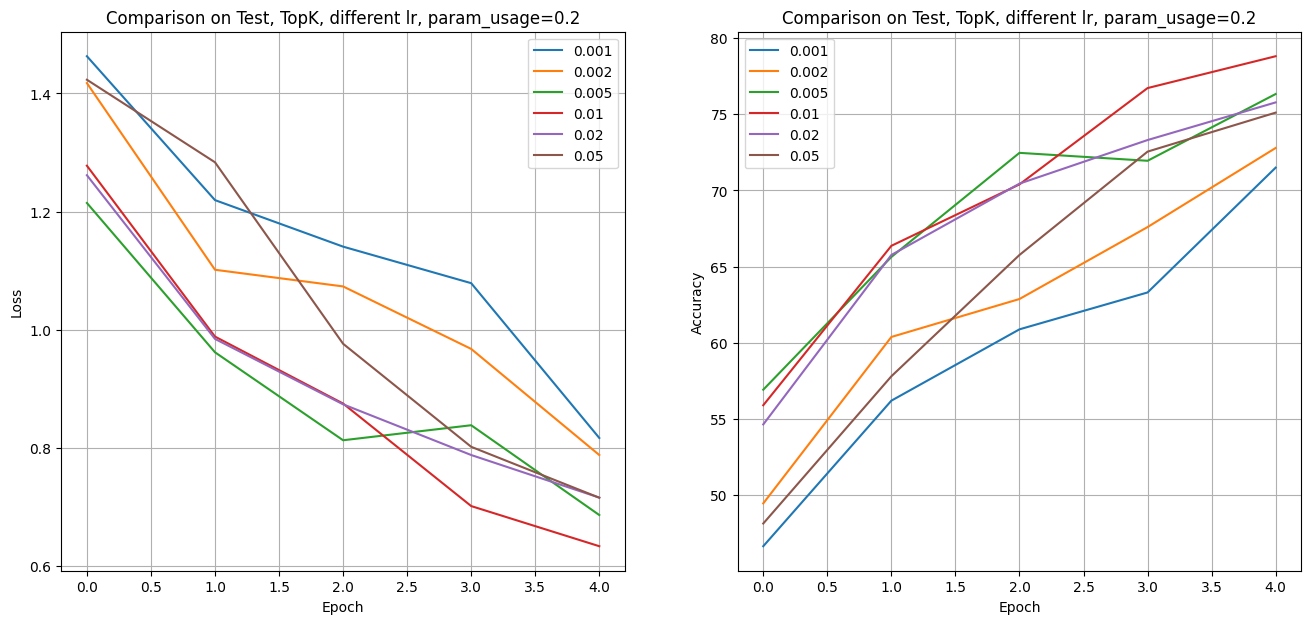

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for lr in test_log:
    axs[0].plot(test_log[lr], label=lr)
    axs[1].plot(test_acc[lr], label=lr)

axs[0].set_title("Comparison on Test, TopK, different lr, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, TopK, different lr, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

In [26]:
param_usage = 0.2
num_epochs = 5
lrs = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]

compression_type = 'square_greedy_ef'

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for lr in lrs:
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_log[lr], train_acc[lr], test_log[lr], test_acc[lr] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr)

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.641 | Train Acc: 38.960% (19480/50000)


 20%|██        | 1/5 [00:14<00:58, 14.53s/it]

Validation Loss: 1.540 | Validation Acc: 46.890% (4689/10000)

Epoch: 1
Train Loss: 1.246 | Train Acc: 54.934% (27467/50000)


 40%|████      | 2/5 [00:28<00:42, 14.10s/it]

Validation Loss: 1.231 | Validation Acc: 55.610% (5561/10000)

Epoch: 2
Train Loss: 1.034 | Train Acc: 63.316% (31658/50000)


 60%|██████    | 3/5 [00:40<00:26, 13.25s/it]

Validation Loss: 1.021 | Validation Acc: 64.130% (6413/10000)

Epoch: 3
Train Loss: 0.892 | Train Acc: 68.360% (34180/50000)


 80%|████████  | 4/5 [00:54<00:13, 13.54s/it]

Validation Loss: 0.881 | Validation Acc: 68.950% (6895/10000)

Epoch: 4
Train Loss: 0.783 | Train Acc: 72.474% (36237/50000)


100%|██████████| 5/5 [01:08<00:00, 13.60s/it]


Validation Loss: 0.770 | Validation Acc: 73.080% (7308/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.556 | Train Acc: 42.092% (21046/50000)


 20%|██        | 1/5 [00:13<00:52, 13.08s/it]

Validation Loss: 1.322 | Validation Acc: 51.830% (5183/10000)

Epoch: 1
Train Loss: 1.105 | Train Acc: 60.280% (30140/50000)


 40%|████      | 2/5 [00:25<00:38, 12.94s/it]

Validation Loss: 1.130 | Validation Acc: 60.960% (6096/10000)

Epoch: 2
Train Loss: 0.898 | Train Acc: 68.196% (34098/50000)


 60%|██████    | 3/5 [00:38<00:25, 12.83s/it]

Validation Loss: 1.038 | Validation Acc: 65.020% (6502/10000)

Epoch: 3
Train Loss: 0.761 | Train Acc: 73.288% (36644/50000)


 80%|████████  | 4/5 [00:52<00:13, 13.22s/it]

Validation Loss: 0.969 | Validation Acc: 68.990% (6899/10000)

Epoch: 4
Train Loss: 0.663 | Train Acc: 76.632% (38316/50000)


100%|██████████| 5/5 [01:04<00:00, 12.92s/it]


Validation Loss: 0.693 | Validation Acc: 76.670% (7667/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.560 | Train Acc: 42.700% (21350/50000)


 20%|██        | 1/5 [00:12<00:50, 12.56s/it]

Validation Loss: 1.170 | Validation Acc: 57.660% (5766/10000)

Epoch: 1
Train Loss: 1.045 | Train Acc: 62.808% (31404/50000)


 40%|████      | 2/5 [00:25<00:38, 12.96s/it]

Validation Loss: 0.968 | Validation Acc: 66.420% (6642/10000)

Epoch: 2
Train Loss: 0.810 | Train Acc: 71.362% (35681/50000)


 60%|██████    | 3/5 [00:39<00:26, 13.40s/it]

Validation Loss: 0.902 | Validation Acc: 69.240% (6924/10000)

Epoch: 3
Train Loss: 0.678 | Train Acc: 76.116% (38058/50000)


 80%|████████  | 4/5 [00:52<00:12, 12.99s/it]

Validation Loss: 0.757 | Validation Acc: 74.630% (7463/10000)

Epoch: 4
Train Loss: 0.593 | Train Acc: 79.282% (39641/50000)


100%|██████████| 5/5 [01:05<00:00, 13.07s/it]


Validation Loss: 0.655 | Validation Acc: 78.430% (7843/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.608 | Train Acc: 41.566% (20783/50000)


 20%|██        | 1/5 [00:13<00:52, 13.24s/it]

Validation Loss: 1.179 | Validation Acc: 57.190% (5719/10000)

Epoch: 1
Train Loss: 1.066 | Train Acc: 61.966% (30983/50000)


 40%|████      | 2/5 [00:26<00:39, 13.06s/it]

Validation Loss: 1.228 | Validation Acc: 59.080% (5908/10000)

Epoch: 2
Train Loss: 0.842 | Train Acc: 70.492% (35246/50000)


 60%|██████    | 3/5 [00:39<00:26, 13.30s/it]

Validation Loss: 0.866 | Validation Acc: 71.480% (7148/10000)

Epoch: 3
Train Loss: 0.674 | Train Acc: 76.346% (38173/50000)


 80%|████████  | 4/5 [00:52<00:13, 13.12s/it]

Validation Loss: 0.815 | Validation Acc: 73.170% (7317/10000)

Epoch: 4
Train Loss: 0.593 | Train Acc: 79.500% (39750/50000)


100%|██████████| 5/5 [01:05<00:00, 13.03s/it]


Validation Loss: 0.716 | Validation Acc: 76.690% (7669/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.773 | Train Acc: 36.578% (18289/50000)


 20%|██        | 1/5 [00:12<00:50, 12.70s/it]

Validation Loss: 1.461 | Validation Acc: 47.190% (4719/10000)

Epoch: 1
Train Loss: 1.240 | Train Acc: 55.448% (27724/50000)


 40%|████      | 2/5 [00:25<00:38, 12.76s/it]

Validation Loss: 1.192 | Validation Acc: 59.390% (5939/10000)

Epoch: 2
Train Loss: 0.990 | Train Acc: 64.884% (32442/50000)


 60%|██████    | 3/5 [00:38<00:25, 12.89s/it]

Validation Loss: 0.920 | Validation Acc: 67.000% (6700/10000)

Epoch: 3
Train Loss: 0.805 | Train Acc: 71.562% (35781/50000)


 80%|████████  | 4/5 [00:51<00:12, 12.99s/it]

Validation Loss: 0.846 | Validation Acc: 71.960% (7196/10000)

Epoch: 4
Train Loss: 0.685 | Train Acc: 76.266% (38133/50000)


100%|██████████| 5/5 [01:04<00:00, 12.98s/it]


Validation Loss: 0.705 | Validation Acc: 75.840% (7584/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.738 | Train Acc: 37.044% (18522/50000)


 20%|██        | 1/5 [00:12<00:50, 12.62s/it]

Validation Loss: 1.422 | Validation Acc: 47.680% (4768/10000)

Epoch: 1
Train Loss: 1.262 | Train Acc: 54.088% (27044/50000)


 40%|████      | 2/5 [00:26<00:39, 13.24s/it]

Validation Loss: 1.147 | Validation Acc: 59.110% (5911/10000)

Epoch: 2
Train Loss: 0.991 | Train Acc: 65.030% (32515/50000)


 60%|██████    | 3/5 [00:39<00:26, 13.11s/it]

Validation Loss: 1.030 | Validation Acc: 64.570% (6457/10000)

Epoch: 3
Train Loss: 0.809 | Train Acc: 71.586% (35793/50000)


 80%|████████  | 4/5 [00:52<00:13, 13.22s/it]

Validation Loss: 0.837 | Validation Acc: 71.090% (7109/10000)

Epoch: 4
Train Loss: 0.687 | Train Acc: 76.170% (38085/50000)


100%|██████████| 5/5 [01:06<00:00, 13.27s/it]

Validation Loss: 0.683 | Validation Acc: 76.230% (7623/10000)


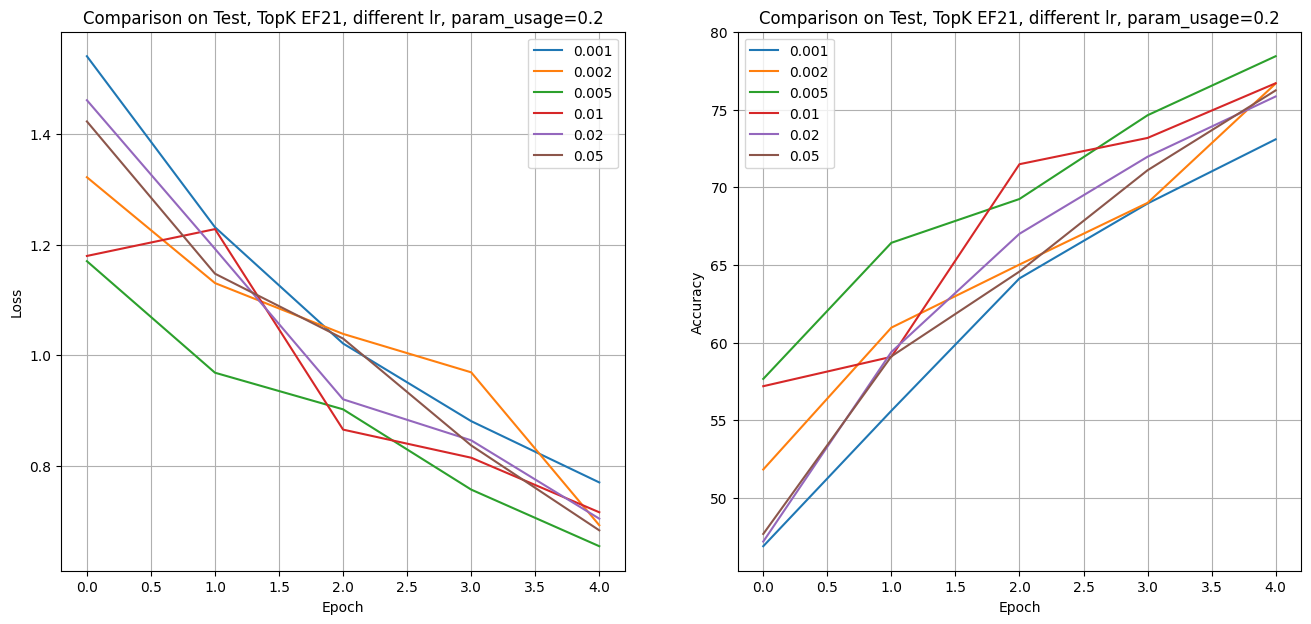

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for lr in test_log:
    axs[0].plot(test_log[lr], label=lr)
    axs[1].plot(test_acc[lr], label=lr)

axs[0].set_title("Comparison on Test, TopK EF21, different lr, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, TopK EF21, different lr, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

In [ ]:
param_usage = 0.2
num_epochs = 5
lrs = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]

compression_type = 'mirror_descent_weighted_greedy'

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for lr in lrs:
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_log[lr], train_acc[lr], test_log[lr], test_acc[lr] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr)

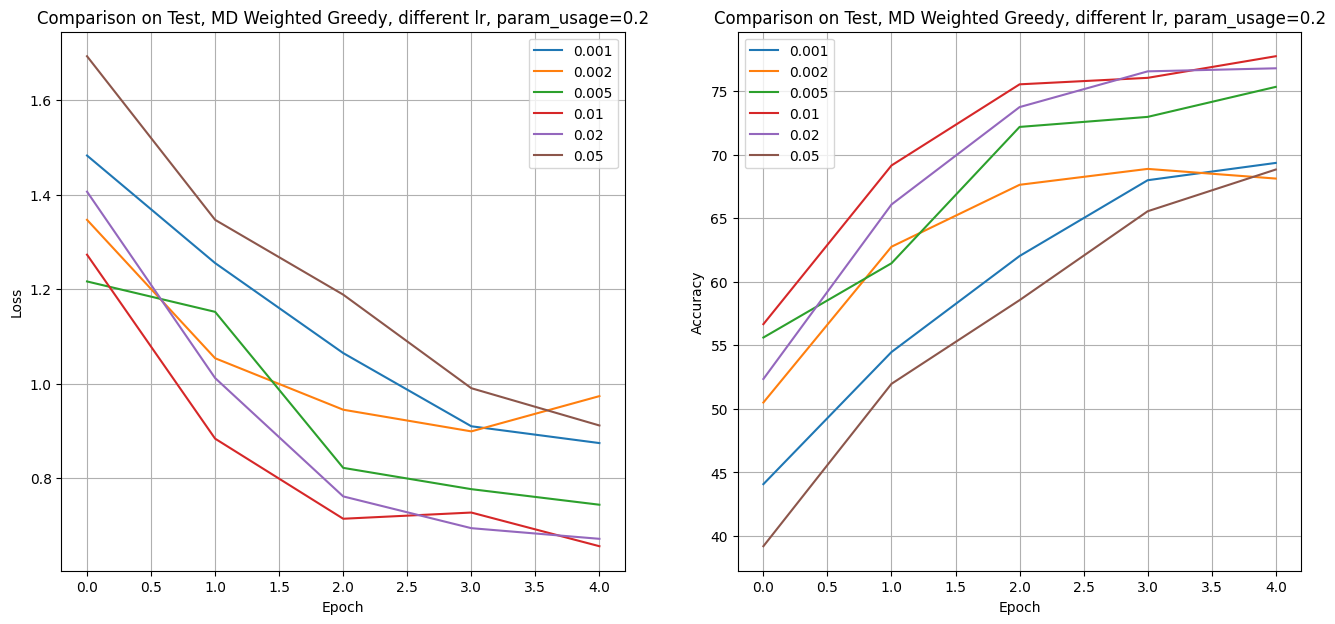

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for lr in test_log:
    axs[0].plot(test_log[lr], label=lr)
    axs[1].plot(test_acc[lr], label=lr)

axs[0].set_title("Comparison on Test, MD Weighted Greedy, different lr, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, MD Weighted Greedy, different lr, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

In [12]:
param_usage = 0.2
num_epochs = 20
lr = 0.01
num_steps_list = [1, 3, 5, 10, 20, 50]

compression_type = 'mirror_descent_weighted_greedy'

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for num_steps in num_steps_list:
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_log[num_steps], train_acc[num_steps], test_log[num_steps], test_acc[num_steps] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr, num_steps=num_steps)

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.488 | Train Acc: 45.212% (22606/50000)


 20%|██        | 1/5 [00:22<01:30, 22.62s/it]

Validation Loss: 1.575 | Validation Acc: 50.320% (5032/10000)

Epoch: 1
Train Loss: 1.027 | Train Acc: 63.292% (31646/50000)


 40%|████      | 2/5 [00:45<01:08, 22.70s/it]

Validation Loss: 0.956 | Validation Acc: 66.710% (6671/10000)

Epoch: 2
Train Loss: 0.800 | Train Acc: 71.662% (35831/50000)


 60%|██████    | 3/5 [01:07<00:44, 22.50s/it]

Validation Loss: 0.774 | Validation Acc: 73.220% (7322/10000)

Epoch: 3
Train Loss: 0.674 | Train Acc: 76.344% (38172/50000)


 80%|████████  | 4/5 [01:31<00:22, 22.92s/it]

Validation Loss: 0.768 | Validation Acc: 74.480% (7448/10000)

Epoch: 4
Train Loss: 0.579 | Train Acc: 79.842% (39921/50000)


100%|██████████| 5/5 [01:53<00:00, 22.69s/it]


Validation Loss: 0.679 | Validation Acc: 76.880% (7688/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.483 | Train Acc: 45.590% (22795/50000)


 20%|██        | 1/5 [00:22<01:28, 22.16s/it]

Validation Loss: 1.320 | Validation Acc: 54.100% (5410/10000)

Epoch: 1
Train Loss: 1.015 | Train Acc: 63.862% (31931/50000)


 40%|████      | 2/5 [00:44<01:07, 22.38s/it]

Validation Loss: 1.147 | Validation Acc: 62.970% (6297/10000)

Epoch: 2
Train Loss: 0.786 | Train Acc: 72.556% (36278/50000)


 60%|██████    | 3/5 [01:09<00:47, 23.64s/it]

Validation Loss: 0.850 | Validation Acc: 71.840% (7184/10000)

Epoch: 3
Train Loss: 0.656 | Train Acc: 77.340% (38670/50000)


 80%|████████  | 4/5 [01:32<00:23, 23.14s/it]

Validation Loss: 0.595 | Validation Acc: 79.370% (7937/10000)

Epoch: 4
Train Loss: 0.562 | Train Acc: 80.586% (40293/50000)


100%|██████████| 5/5 [01:55<00:00, 23.13s/it]


Validation Loss: 0.686 | Validation Acc: 76.730% (7673/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.488 | Train Acc: 45.184% (22592/50000)


 20%|██        | 1/5 [00:24<01:37, 24.30s/it]

Validation Loss: 1.290 | Validation Acc: 55.510% (5551/10000)

Epoch: 1
Train Loss: 1.002 | Train Acc: 64.380% (32190/50000)


 40%|████      | 2/5 [00:48<01:13, 24.45s/it]

Validation Loss: 0.971 | Validation Acc: 67.500% (6750/10000)

Epoch: 2
Train Loss: 0.773 | Train Acc: 72.782% (36391/50000)


 60%|██████    | 3/5 [01:13<00:48, 24.39s/it]

Validation Loss: 0.855 | Validation Acc: 70.850% (7085/10000)

Epoch: 3
Train Loss: 0.646 | Train Acc: 77.548% (38774/50000)


 80%|████████  | 4/5 [01:37<00:24, 24.47s/it]

Validation Loss: 0.718 | Validation Acc: 76.340% (7634/10000)

Epoch: 4
Train Loss: 0.561 | Train Acc: 80.604% (40302/50000)


100%|██████████| 5/5 [02:03<00:00, 24.62s/it]


Validation Loss: 0.565 | Validation Acc: 81.210% (8121/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.491 | Train Acc: 45.090% (22545/50000)


 20%|██        | 1/5 [00:27<01:51, 27.77s/it]

Validation Loss: 1.349 | Validation Acc: 51.770% (5177/10000)

Epoch: 1
Train Loss: 1.004 | Train Acc: 64.238% (32119/50000)


 40%|████      | 2/5 [00:56<01:24, 28.15s/it]

Validation Loss: 1.016 | Validation Acc: 65.340% (6534/10000)

Epoch: 2
Train Loss: 0.779 | Train Acc: 72.586% (36293/50000)


 60%|██████    | 3/5 [01:24<00:56, 28.33s/it]

Validation Loss: 0.906 | Validation Acc: 70.180% (7018/10000)

Epoch: 3
Train Loss: 0.650 | Train Acc: 77.328% (38664/50000)


 80%|████████  | 4/5 [01:51<00:27, 27.85s/it]

Validation Loss: 0.773 | Validation Acc: 74.280% (7428/10000)

Epoch: 4
Train Loss: 0.574 | Train Acc: 80.088% (40044/50000)


100%|██████████| 5/5 [02:18<00:00, 27.66s/it]


Validation Loss: 0.699 | Validation Acc: 76.350% (7635/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.481 | Train Acc: 45.900% (22950/50000)


 20%|██        | 1/5 [00:34<02:16, 34.08s/it]

Validation Loss: 1.469 | Validation Acc: 51.290% (5129/10000)

Epoch: 1
Train Loss: 0.998 | Train Acc: 64.696% (32348/50000)


 40%|████      | 2/5 [01:07<01:41, 33.77s/it]

Validation Loss: 0.939 | Validation Acc: 66.510% (6651/10000)

Epoch: 2
Train Loss: 0.777 | Train Acc: 72.678% (36339/50000)


 60%|██████    | 3/5 [01:42<01:08, 34.13s/it]

Validation Loss: 0.756 | Validation Acc: 74.270% (7427/10000)

Epoch: 3
Train Loss: 0.647 | Train Acc: 77.354% (38677/50000)


 80%|████████  | 4/5 [02:16<00:34, 34.02s/it]

Validation Loss: 0.753 | Validation Acc: 75.410% (7541/10000)

Epoch: 4
Train Loss: 0.570 | Train Acc: 80.192% (40096/50000)


100%|██████████| 5/5 [02:51<00:00, 34.22s/it]


Validation Loss: 0.546 | Validation Acc: 81.470% (8147/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.505 | Train Acc: 44.910% (22455/50000)


 20%|██        | 1/5 [00:52<03:30, 52.73s/it]

Validation Loss: 1.225 | Validation Acc: 58.030% (5803/10000)

Epoch: 1
Train Loss: 1.014 | Train Acc: 63.974% (31987/50000)


 40%|████      | 2/5 [01:45<02:37, 52.52s/it]

Validation Loss: 1.102 | Validation Acc: 62.740% (6274/10000)

Epoch: 2
Train Loss: 0.787 | Train Acc: 72.178% (36089/50000)


 60%|██████    | 3/5 [02:37<01:44, 52.48s/it]

Validation Loss: 0.787 | Validation Acc: 72.240% (7224/10000)

Epoch: 3
Train Loss: 0.651 | Train Acc: 77.356% (38678/50000)


 80%|████████  | 4/5 [03:30<00:52, 52.72s/it]

Validation Loss: 1.033 | Validation Acc: 67.390% (6739/10000)

Epoch: 4
Train Loss: 0.576 | Train Acc: 80.028% (40014/50000)


100%|██████████| 5/5 [04:23<00:00, 52.77s/it]

Validation Loss: 0.574 | Validation Acc: 80.290% (8029/10000)


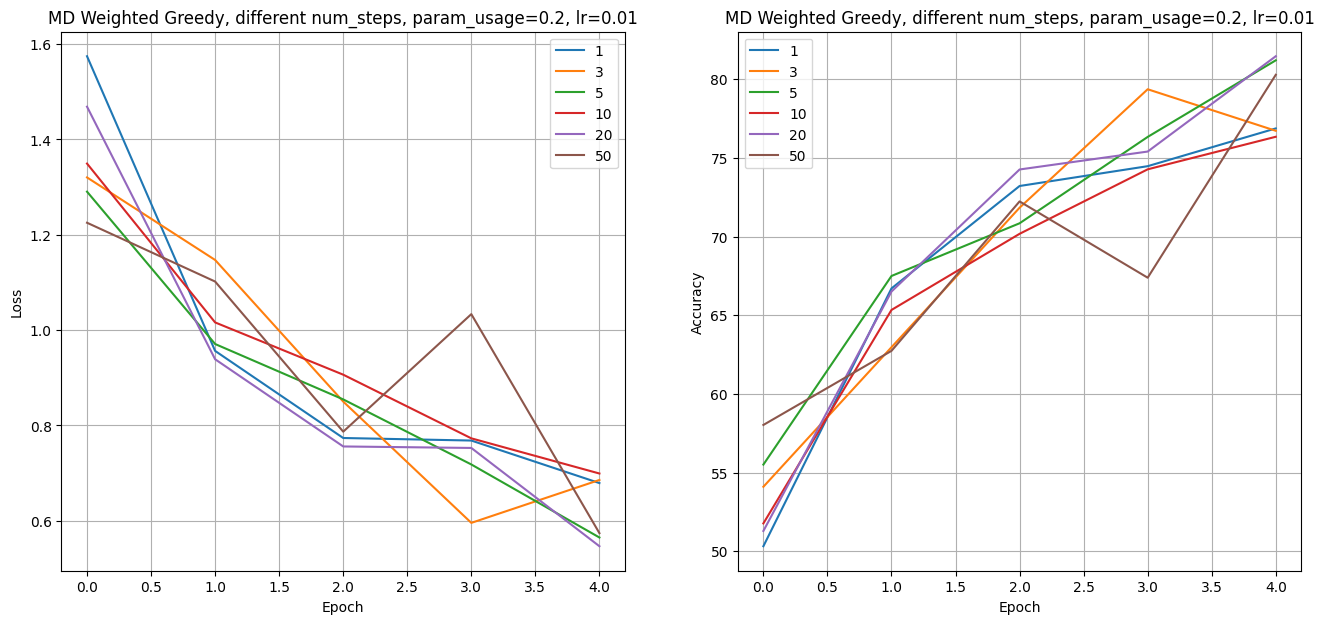

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for num_steps in test_log:
    axs[0].plot(test_log[num_steps], label=num_steps)
    axs[1].plot(test_acc[num_steps], label=num_steps)

axs[0].set_title("MD Weighted Greedy, different num_steps, param_usage=0.2, lr=0.01")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("MD Weighted Greedy, different num_steps, param_usage=0.2, lr=0.01")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

In [22]:
param_usage = 0.2
num_epochs = 20
lr = 0.01
num_steps_list = [1, 3, 5, 10, 20, 50]

compression_type = 'gradient_descent_weighted_greedy'

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for num_steps in num_steps_list:
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_log[num_steps], train_acc[num_steps], test_log[num_steps], test_acc[num_steps] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr, num_steps=num_steps)

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.488 | Train Acc: 45.146% (22573/50000)


  5%|▌         | 1/20 [00:14<04:29, 14.19s/it]

Validation Loss: 1.274 | Validation Acc: 53.730% (5373/10000)

Epoch: 1
Train Loss: 1.030 | Train Acc: 63.186% (31593/50000)


 10%|█         | 2/20 [00:28<04:16, 14.23s/it]

Validation Loss: 0.958 | Validation Acc: 66.110% (6611/10000)

Epoch: 2
Train Loss: 0.795 | Train Acc: 71.838% (35919/50000)


 15%|█▌        | 3/20 [00:43<04:06, 14.48s/it]

Validation Loss: 0.845 | Validation Acc: 70.200% (7020/10000)

Epoch: 3
Train Loss: 0.666 | Train Acc: 76.852% (38426/50000)


 20%|██        | 4/20 [00:58<03:55, 14.73s/it]

Validation Loss: 0.693 | Validation Acc: 76.620% (7662/10000)

Epoch: 4
Train Loss: 0.583 | Train Acc: 79.566% (39783/50000)


 25%|██▌       | 5/20 [01:12<03:40, 14.70s/it]

Validation Loss: 0.786 | Validation Acc: 74.250% (7425/10000)

Epoch: 5
Train Loss: 0.522 | Train Acc: 81.832% (40916/50000)


 30%|███       | 6/20 [01:27<03:24, 14.60s/it]

Validation Loss: 0.667 | Validation Acc: 77.230% (7723/10000)

Epoch: 6
Train Loss: 0.475 | Train Acc: 83.636% (41818/50000)


 35%|███▌      | 7/20 [01:41<03:09, 14.54s/it]

Validation Loss: 0.600 | Validation Acc: 80.090% (8009/10000)

Epoch: 7
Train Loss: 0.435 | Train Acc: 84.878% (42439/50000)


 40%|████      | 8/20 [01:56<02:53, 14.44s/it]

Validation Loss: 0.614 | Validation Acc: 79.570% (7957/10000)

Epoch: 8
Train Loss: 0.404 | Train Acc: 85.890% (42945/50000)


 45%|████▌     | 9/20 [02:10<02:37, 14.32s/it]

Validation Loss: 0.489 | Validation Acc: 83.130% (8313/10000)

Epoch: 9
Train Loss: 0.371 | Train Acc: 87.194% (43597/50000)


 50%|█████     | 10/20 [02:24<02:23, 14.34s/it]

Validation Loss: 0.474 | Validation Acc: 83.960% (8396/10000)

Epoch: 10
Train Loss: 0.355 | Train Acc: 87.612% (43806/50000)


 55%|█████▌    | 11/20 [02:38<02:09, 14.40s/it]

Validation Loss: 0.493 | Validation Acc: 83.750% (8375/10000)

Epoch: 11
Train Loss: 0.335 | Train Acc: 88.320% (44160/50000)


 60%|██████    | 12/20 [02:53<01:55, 14.43s/it]

Validation Loss: 0.490 | Validation Acc: 83.550% (8355/10000)

Epoch: 12
Train Loss: 0.308 | Train Acc: 89.396% (44698/50000)


 65%|██████▌   | 13/20 [03:07<01:40, 14.29s/it]

Validation Loss: 0.477 | Validation Acc: 84.370% (8437/10000)

Epoch: 13
Train Loss: 0.295 | Train Acc: 89.756% (44878/50000)


 70%|███████   | 14/20 [03:21<01:24, 14.16s/it]

Validation Loss: 0.464 | Validation Acc: 85.340% (8534/10000)

Epoch: 14
Train Loss: 0.280 | Train Acc: 90.362% (45181/50000)


 75%|███████▌  | 15/20 [03:34<01:08, 13.78s/it]

Validation Loss: 0.398 | Validation Acc: 86.690% (8669/10000)

Epoch: 15
Train Loss: 0.265 | Train Acc: 90.752% (45376/50000)


 80%|████████  | 16/20 [03:48<00:56, 14.04s/it]

Validation Loss: 0.389 | Validation Acc: 87.230% (8723/10000)

Epoch: 16
Train Loss: 0.250 | Train Acc: 91.336% (45668/50000)


 85%|████████▌ | 17/20 [04:03<00:43, 14.33s/it]

Validation Loss: 0.412 | Validation Acc: 86.530% (8653/10000)

Epoch: 17
Train Loss: 0.237 | Train Acc: 91.838% (45919/50000)


 90%|█████████ | 18/20 [04:18<00:28, 14.46s/it]

Validation Loss: 0.397 | Validation Acc: 86.910% (8691/10000)

Epoch: 18
Train Loss: 0.231 | Train Acc: 92.020% (46010/50000)


 95%|█████████▌| 19/20 [04:32<00:14, 14.39s/it]

Validation Loss: 0.391 | Validation Acc: 87.240% (8724/10000)

Epoch: 19
Train Loss: 0.220 | Train Acc: 92.260% (46130/50000)


100%|██████████| 20/20 [04:47<00:00, 14.38s/it]


Validation Loss: 0.384 | Validation Acc: 87.360% (8736/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.506 | Train Acc: 44.376% (22188/50000)


  5%|▌         | 1/20 [00:16<05:18, 16.79s/it]

Validation Loss: 1.263 | Validation Acc: 55.270% (5527/10000)

Epoch: 1
Train Loss: 1.061 | Train Acc: 61.982% (30991/50000)


 10%|█         | 2/20 [00:32<04:49, 16.11s/it]

Validation Loss: 1.187 | Validation Acc: 60.660% (6066/10000)

Epoch: 2
Train Loss: 0.851 | Train Acc: 69.818% (34909/50000)


 15%|█▌        | 3/20 [00:48<04:32, 16.02s/it]

Validation Loss: 0.868 | Validation Acc: 70.160% (7016/10000)

Epoch: 3
Train Loss: 0.706 | Train Acc: 75.278% (37639/50000)


 20%|██        | 4/20 [01:04<04:17, 16.08s/it]

Validation Loss: 0.710 | Validation Acc: 76.260% (7626/10000)

Epoch: 4
Train Loss: 0.615 | Train Acc: 78.584% (39292/50000)


 25%|██▌       | 5/20 [01:20<03:58, 15.90s/it]

Validation Loss: 0.649 | Validation Acc: 78.110% (7811/10000)

Epoch: 5
Train Loss: 0.553 | Train Acc: 80.906% (40453/50000)


 30%|███       | 6/20 [01:36<03:46, 16.15s/it]

Validation Loss: 0.606 | Validation Acc: 79.620% (7962/10000)

Epoch: 6
Train Loss: 0.499 | Train Acc: 82.720% (41360/50000)


 35%|███▌      | 7/20 [01:53<03:33, 16.41s/it]

Validation Loss: 0.554 | Validation Acc: 81.190% (8119/10000)

Epoch: 7
Train Loss: 0.457 | Train Acc: 84.256% (42128/50000)


 40%|████      | 8/20 [02:09<03:16, 16.35s/it]

Validation Loss: 0.522 | Validation Acc: 82.720% (8272/10000)

Epoch: 8
Train Loss: 0.425 | Train Acc: 85.336% (42668/50000)


 45%|████▌     | 9/20 [02:25<02:58, 16.25s/it]

Validation Loss: 0.507 | Validation Acc: 82.840% (8284/10000)

Epoch: 9
Train Loss: 0.398 | Train Acc: 86.314% (43157/50000)


 50%|█████     | 10/20 [02:41<02:40, 16.00s/it]

Validation Loss: 0.521 | Validation Acc: 82.770% (8277/10000)

Epoch: 10
Train Loss: 0.366 | Train Acc: 87.420% (43710/50000)


 55%|█████▌    | 11/20 [02:56<02:21, 15.76s/it]

Validation Loss: 0.471 | Validation Acc: 84.090% (8409/10000)

Epoch: 11
Train Loss: 0.352 | Train Acc: 87.686% (43843/50000)


 60%|██████    | 12/20 [03:12<02:06, 15.80s/it]

Validation Loss: 0.434 | Validation Acc: 85.630% (8563/10000)

Epoch: 12
Train Loss: 0.330 | Train Acc: 88.552% (44276/50000)


 65%|██████▌   | 13/20 [03:29<01:52, 16.07s/it]

Validation Loss: 0.427 | Validation Acc: 86.030% (8603/10000)

Epoch: 13
Train Loss: 0.308 | Train Acc: 89.306% (44653/50000)


 70%|███████   | 14/20 [03:44<01:35, 15.83s/it]

Validation Loss: 0.465 | Validation Acc: 84.870% (8487/10000)

Epoch: 14
Train Loss: 0.297 | Train Acc: 89.766% (44883/50000)


 75%|███████▌  | 15/20 [04:00<01:19, 15.83s/it]

Validation Loss: 0.423 | Validation Acc: 86.430% (8643/10000)

Epoch: 15
Train Loss: 0.277 | Train Acc: 90.360% (45180/50000)


 80%|████████  | 16/20 [04:16<01:03, 15.93s/it]

Validation Loss: 0.508 | Validation Acc: 83.490% (8349/10000)

Epoch: 16
Train Loss: 0.267 | Train Acc: 90.666% (45333/50000)


 85%|████████▌ | 17/20 [04:33<00:48, 16.23s/it]

Validation Loss: 0.380 | Validation Acc: 87.310% (8731/10000)

Epoch: 17
Train Loss: 0.255 | Train Acc: 91.112% (45556/50000)


 90%|█████████ | 18/20 [04:49<00:32, 16.18s/it]

Validation Loss: 0.392 | Validation Acc: 87.480% (8748/10000)

Epoch: 18
Train Loss: 0.240 | Train Acc: 91.604% (45802/50000)


 95%|█████████▌| 19/20 [05:04<00:15, 15.98s/it]

Validation Loss: 0.398 | Validation Acc: 87.030% (8703/10000)

Epoch: 19
Train Loss: 0.230 | Train Acc: 92.112% (46056/50000)


100%|██████████| 20/20 [05:20<00:00, 16.05s/it]


Validation Loss: 0.495 | Validation Acc: 84.250% (8425/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.476 | Train Acc: 45.468% (22734/50000)


  5%|▌         | 1/20 [00:16<05:22, 16.96s/it]

Validation Loss: 1.168 | Validation Acc: 58.190% (5819/10000)

Epoch: 1


  5%|▌         | 1/20 [00:24<07:37, 24.08s/it]


KeyboardInterrupt: 

In [ ]:
param_usage = 0.2
num_epochs = 20
lr = 0.01
num_restarts = 3
num_steps_list = [1, 3, 5, 10, 20, 50]

compression_type = 'mirror_descent_weighted_greedy'

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for num_steps in num_steps_list:
    
    train_log[num_steps], train_acc[num_steps], test_log[num_steps], test_acc[num_steps] = [], [], [], []
    
    for num_restart in range(num_restarts):
        set_seed(num_steps+num_restart)
        net = ResNet18().to(device)
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        criterion = nn.CrossEntropyLoss()

        train_loss, train_accuracy, test_loss, test_accuracy = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr, num_steps=num_steps)
        
        train_log[num_steps].append(train_loss)
        train_acc[num_steps].append(train_accuracy)
        test_log[num_steps].append(test_loss)
        test_acc[num_steps].append(test_accuracy)

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.437 | Train Acc: 47.276% (23638/50000)


  5%|▌         | 1/20 [00:16<05:08, 16.24s/it]

Validation Loss: 1.158 | Validation Acc: 58.090% (5809/10000)

Epoch: 1
Train Loss: 0.960 | Train Acc: 65.760% (32880/50000)


 10%|█         | 2/20 [00:30<04:35, 15.31s/it]

Validation Loss: 0.888 | Validation Acc: 68.670% (6867/10000)

Epoch: 2
Train Loss: 0.747 | Train Acc: 73.784% (36892/50000)


 15%|█▌        | 3/20 [00:45<04:12, 14.83s/it]

Validation Loss: 0.776 | Validation Acc: 74.030% (7403/10000)

Epoch: 3
Train Loss: 0.631 | Train Acc: 77.948% (38974/50000)


 20%|██        | 4/20 [00:59<03:54, 14.64s/it]

Validation Loss: 0.678 | Validation Acc: 77.200% (7720/10000)

Epoch: 4
Train Loss: 0.558 | Train Acc: 80.686% (40343/50000)


 25%|██▌       | 5/20 [01:15<03:44, 14.97s/it]

Validation Loss: 0.709 | Validation Acc: 76.280% (7628/10000)

Epoch: 5


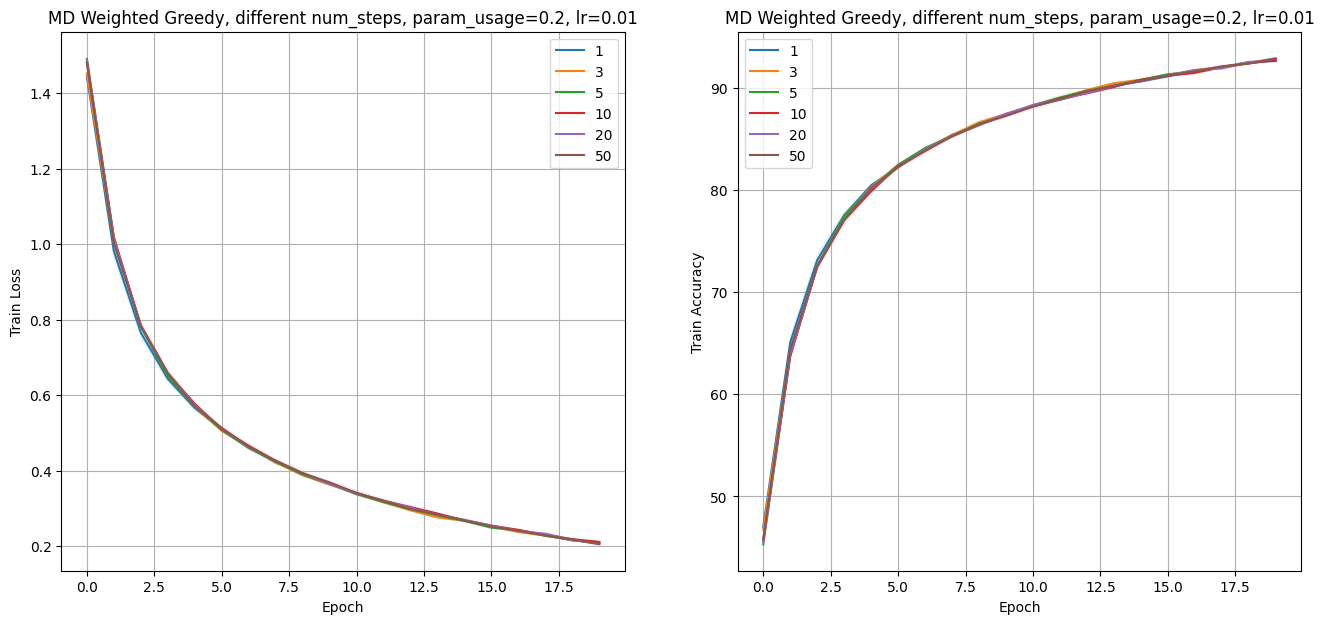

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for num_steps in num_steps_list:
    loss = np.array(train_log[num_steps])
    loss_mean = np.mean(loss, axis=0)
    loss_std = np.std(loss, axis=0)
    
    accuracy = np.array(train_acc[num_steps])
    accuracy_mean = np.mean(accuracy, axis=0)
    accuracy_std = np.std(accuracy, axis=0)
    
    iters = list(range(len(loss_mean)))
    
    axs[0].plot(iters, loss_mean, label=num_steps)
    axs[0].fill_between(iters, loss_mean-loss_std, loss_mean+loss_std, alpha=0.1)
    
    axs[1].plot(iters, accuracy_mean, label=num_steps)
    axs[1].fill_between(iters, accuracy_mean-accuracy_std, accuracy_mean+accuracy_std, alpha=0.1)
    

axs[0].set_title("MD Weighted Greedy, different num_steps, param_usage=0.2, lr=0.01")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Train Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("MD Weighted Greedy, different num_steps, param_usage=0.2, lr=0.01")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Train Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

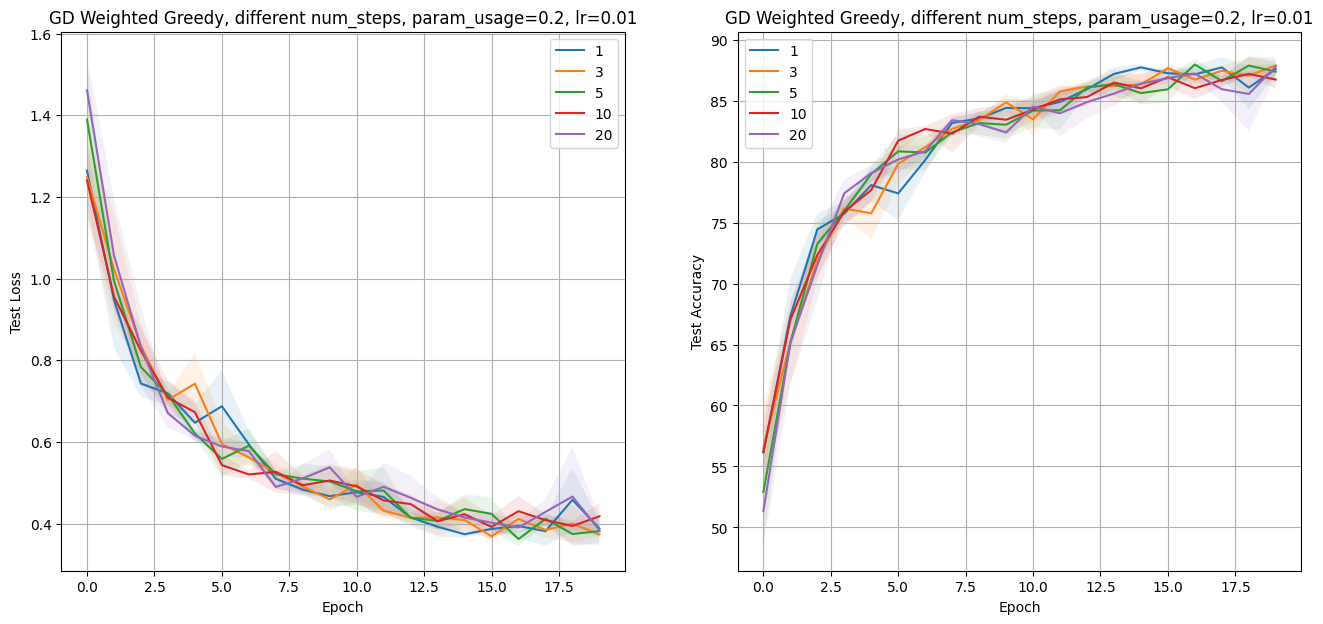

In [17]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for num_steps in num_steps_list[:-1]:
    loss = np.array(test_log[num_steps])
    loss_mean = np.mean(loss, axis=0)
    loss_std = np.std(loss, axis=0)
    
    accuracy = np.array(test_acc[num_steps])
    accuracy_mean = np.mean(accuracy, axis=0)
    accuracy_std = np.std(accuracy, axis=0)
    
    iters = list(range(len(loss_mean)))
    
    axs[0].plot(iters, loss_mean, label=num_steps)
    axs[0].fill_between(iters, loss_mean-loss_std, loss_mean+loss_std, alpha=0.1)
    
    axs[1].plot(iters, accuracy_mean, label=num_steps)
    axs[1].fill_between(iters, accuracy_mean-accuracy_std, accuracy_mean+accuracy_std, alpha=0.1)
    

axs[0].set_title("GD Weighted Greedy, different num_steps, param_usage=0.2, lr=0.01")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Test Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("GD Weighted Greedy, different num_steps, param_usage=0.2, lr=0.01")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Test Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

In [41]:
param_usage = 0.2
num_epochs = 20
lr = 0.01
num_restarts = 3
num_steps_list = [1, 3, 5, 10, 20, 50]

compression_type = 'gradient_descent_weighted_greedy'

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for num_steps in num_steps_list:
    
    train_log[num_steps], train_acc[num_steps], test_log[num_steps], test_acc[num_steps] = [], [], [], []
    
    for num_restart in range(num_restarts):
        set_seed(num_steps+num_restart)
        net = ResNet18().to(device)
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        criterion = nn.CrossEntropyLoss()

        train_loss, train_accuracy, test_loss, test_accuracy = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr, num_steps=num_steps)
        
        train_log[num_steps].append(train_loss)
        train_acc[num_steps].append(train_accuracy)
        test_log[num_steps].append(test_loss)
        test_acc[num_steps].append(test_accuracy)

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.483 | Train Acc: 45.502% (22751/50000)


  5%|▌         | 1/20 [00:14<04:37, 14.59s/it]

Validation Loss: 1.203 | Validation Acc: 56.430% (5643/10000)

Epoch: 1
Train Loss: 1.030 | Train Acc: 63.058% (31529/50000)


 10%|█         | 2/20 [00:29<04:21, 14.51s/it]

Validation Loss: 1.169 | Validation Acc: 59.950% (5995/10000)

Epoch: 2
Train Loss: 0.818 | Train Acc: 70.946% (35473/50000)


 15%|█▌        | 3/20 [00:42<03:58, 14.05s/it]

Validation Loss: 0.925 | Validation Acc: 69.190% (6919/10000)

Epoch: 3
Train Loss: 0.690 | Train Acc: 75.740% (37870/50000)


 20%|██        | 4/20 [00:55<03:40, 13.81s/it]

Validation Loss: 0.954 | Validation Acc: 68.960% (6896/10000)

Epoch: 4
Train Loss: 0.597 | Train Acc: 79.144% (39572/50000)


 25%|██▌       | 5/20 [01:10<03:29, 13.94s/it]

Validation Loss: 0.583 | Validation Acc: 80.250% (8025/10000)

Epoch: 5
Train Loss: 0.537 | Train Acc: 81.288% (40644/50000)


 30%|███       | 6/20 [01:24<03:17, 14.13s/it]

Validation Loss: 0.609 | Validation Acc: 78.910% (7891/10000)

Epoch: 6
Train Loss: 0.485 | Train Acc: 83.134% (41567/50000)


 35%|███▌      | 7/20 [01:39<03:07, 14.42s/it]

Validation Loss: 0.756 | Validation Acc: 75.340% (7534/10000)

Epoch: 7
Train Loss: 0.444 | Train Acc: 84.820% (42410/50000)


 40%|████      | 8/20 [01:53<02:49, 14.16s/it]

Validation Loss: 0.531 | Validation Acc: 82.430% (8243/10000)

Epoch: 8
Train Loss: 0.417 | Train Acc: 85.606% (42803/50000)


 45%|████▌     | 9/20 [02:07<02:34, 14.06s/it]

Validation Loss: 0.543 | Validation Acc: 81.850% (8185/10000)

Epoch: 9
Train Loss: 0.385 | Train Acc: 86.668% (43334/50000)


 50%|█████     | 10/20 [02:21<02:21, 14.12s/it]

Validation Loss: 0.494 | Validation Acc: 83.670% (8367/10000)

Epoch: 10
Train Loss: 0.363 | Train Acc: 87.356% (43678/50000)


 55%|█████▌    | 11/20 [02:35<02:07, 14.21s/it]

Validation Loss: 0.516 | Validation Acc: 82.290% (8229/10000)

Epoch: 11
Train Loss: 0.337 | Train Acc: 88.350% (44175/50000)


 60%|██████    | 12/20 [02:49<01:53, 14.15s/it]

Validation Loss: 0.468 | Validation Acc: 84.250% (8425/10000)

Epoch: 12
Train Loss: 0.315 | Train Acc: 89.046% (44523/50000)


 65%|██████▌   | 13/20 [03:03<01:38, 14.14s/it]

Validation Loss: 0.495 | Validation Acc: 84.300% (8430/10000)

Epoch: 13
Train Loss: 0.302 | Train Acc: 89.540% (44770/50000)


 70%|███████   | 14/20 [03:17<01:24, 14.12s/it]

Validation Loss: 0.416 | Validation Acc: 86.030% (8603/10000)

Epoch: 14
Train Loss: 0.285 | Train Acc: 90.084% (45042/50000)


 75%|███████▌  | 15/20 [03:32<01:10, 14.20s/it]

Validation Loss: 0.488 | Validation Acc: 84.180% (8418/10000)

Epoch: 15
Train Loss: 0.267 | Train Acc: 90.850% (45425/50000)


 80%|████████  | 16/20 [03:46<00:56, 14.23s/it]

Validation Loss: 0.443 | Validation Acc: 85.620% (8562/10000)

Epoch: 16
Train Loss: 0.257 | Train Acc: 90.970% (45485/50000)


 85%|████████▌ | 17/20 [04:00<00:41, 13.96s/it]

Validation Loss: 0.389 | Validation Acc: 87.220% (8722/10000)

Epoch: 17
Train Loss: 0.247 | Train Acc: 91.484% (45742/50000)


 90%|█████████ | 18/20 [04:13<00:27, 13.92s/it]

Validation Loss: 0.376 | Validation Acc: 87.250% (8725/10000)

Epoch: 18
Train Loss: 0.235 | Train Acc: 91.886% (45943/50000)


 95%|█████████▌| 19/20 [04:27<00:13, 13.88s/it]

Validation Loss: 0.363 | Validation Acc: 87.680% (8768/10000)

Epoch: 19
Train Loss: 0.227 | Train Acc: 92.176% (46088/50000)


100%|██████████| 20/20 [04:42<00:00, 14.11s/it]


Validation Loss: 0.381 | Validation Acc: 87.660% (8766/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.523 | Train Acc: 43.786% (21893/50000)


  5%|▌         | 1/20 [00:14<04:40, 14.78s/it]

Validation Loss: 1.275 | Validation Acc: 55.370% (5537/10000)

Epoch: 1
Train Loss: 1.063 | Train Acc: 62.058% (31029/50000)


 10%|█         | 2/20 [00:29<04:23, 14.62s/it]

Validation Loss: 1.141 | Validation Acc: 61.040% (6104/10000)

Epoch: 2
Train Loss: 0.839 | Train Acc: 70.268% (35134/50000)


 15%|█▌        | 3/20 [00:43<04:07, 14.55s/it]

Validation Loss: 0.987 | Validation Acc: 67.110% (6711/10000)

Epoch: 3
Train Loss: 0.701 | Train Acc: 75.458% (37729/50000)


 20%|██        | 4/20 [00:58<03:52, 14.52s/it]

Validation Loss: 0.714 | Validation Acc: 74.370% (7437/10000)

Epoch: 4
Train Loss: 0.610 | Train Acc: 78.784% (39392/50000)


 25%|██▌       | 5/20 [01:12<03:37, 14.48s/it]

Validation Loss: 0.654 | Validation Acc: 78.210% (7821/10000)

Epoch: 5
Train Loss: 0.544 | Train Acc: 81.064% (40532/50000)


 30%|███       | 6/20 [01:26<03:19, 14.28s/it]

Validation Loss: 0.656 | Validation Acc: 78.490% (7849/10000)

Epoch: 6
Train Loss: 0.492 | Train Acc: 82.988% (41494/50000)


 35%|███▌      | 7/20 [01:41<03:08, 14.53s/it]

Validation Loss: 0.580 | Validation Acc: 80.470% (8047/10000)

Epoch: 7
Train Loss: 0.449 | Train Acc: 84.314% (42157/50000)


 40%|████      | 8/20 [01:56<02:54, 14.54s/it]

Validation Loss: 0.601 | Validation Acc: 79.910% (7991/10000)

Epoch: 8
Train Loss: 0.418 | Train Acc: 85.624% (42812/50000)


 45%|████▌     | 9/20 [02:09<02:36, 14.22s/it]

Validation Loss: 0.519 | Validation Acc: 82.930% (8293/10000)

Epoch: 9
Train Loss: 0.391 | Train Acc: 86.520% (43260/50000)


 50%|█████     | 10/20 [02:23<02:19, 13.99s/it]

Validation Loss: 0.569 | Validation Acc: 81.400% (8140/10000)

Epoch: 10
Train Loss: 0.365 | Train Acc: 87.420% (43710/50000)


 55%|█████▌    | 11/20 [02:37<02:07, 14.16s/it]

Validation Loss: 0.443 | Validation Acc: 85.170% (8517/10000)

Epoch: 11
Train Loss: 0.342 | Train Acc: 88.094% (44047/50000)


 60%|██████    | 12/20 [02:51<01:51, 13.96s/it]

Validation Loss: 0.471 | Validation Acc: 84.170% (8417/10000)

Epoch: 12
Train Loss: 0.323 | Train Acc: 88.622% (44311/50000)


 65%|██████▌   | 13/20 [03:05<01:38, 14.14s/it]

Validation Loss: 0.446 | Validation Acc: 85.510% (8551/10000)

Epoch: 13
Train Loss: 0.302 | Train Acc: 89.604% (44802/50000)


 70%|███████   | 14/20 [03:19<01:25, 14.17s/it]

Validation Loss: 0.450 | Validation Acc: 84.870% (8487/10000)

Epoch: 14
Train Loss: 0.285 | Train Acc: 90.090% (45045/50000)


 75%|███████▌  | 15/20 [03:34<01:11, 14.20s/it]

Validation Loss: 0.417 | Validation Acc: 86.560% (8656/10000)

Epoch: 15
Train Loss: 0.272 | Train Acc: 90.630% (45315/50000)


 80%|████████  | 16/20 [03:47<00:56, 14.03s/it]

Validation Loss: 0.439 | Validation Acc: 85.710% (8571/10000)

Epoch: 16
Train Loss: 0.264 | Train Acc: 90.758% (45379/50000)


 85%|████████▌ | 17/20 [04:02<00:42, 14.28s/it]

Validation Loss: 0.435 | Validation Acc: 85.430% (8543/10000)

Epoch: 17
Train Loss: 0.249 | Train Acc: 91.364% (45682/50000)


 90%|█████████ | 18/20 [04:17<00:28, 14.38s/it]

Validation Loss: 0.367 | Validation Acc: 88.050% (8805/10000)

Epoch: 18
Train Loss: 0.236 | Train Acc: 91.898% (45949/50000)


 95%|█████████▌| 19/20 [04:31<00:14, 14.29s/it]

Validation Loss: 0.404 | Validation Acc: 86.470% (8647/10000)

Epoch: 19
Train Loss: 0.222 | Train Acc: 92.386% (46193/50000)


100%|██████████| 20/20 [04:44<00:00, 14.24s/it]


Validation Loss: 0.378 | Validation Acc: 87.650% (8765/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.499 | Train Acc: 44.946% (22473/50000)


  5%|▌         | 1/20 [00:13<04:17, 13.57s/it]

Validation Loss: 1.214 | Validation Acc: 56.250% (5625/10000)

Epoch: 1
Train Loss: 1.039 | Train Acc: 62.796% (31398/50000)


 10%|█         | 2/20 [00:28<04:20, 14.49s/it]

Validation Loss: 0.920 | Validation Acc: 67.720% (6772/10000)

Epoch: 2
Train Loss: 0.825 | Train Acc: 71.036% (35518/50000)


 15%|█▌        | 3/20 [00:43<04:10, 14.76s/it]

Validation Loss: 0.852 | Validation Acc: 70.320% (7032/10000)

Epoch: 3
Train Loss: 0.685 | Train Acc: 76.110% (38055/50000)


 20%|██        | 4/20 [00:57<03:51, 14.50s/it]

Validation Loss: 0.786 | Validation Acc: 73.880% (7388/10000)

Epoch: 4
Train Loss: 0.605 | Train Acc: 78.710% (39355/50000)


 25%|██▌       | 5/20 [01:12<03:36, 14.45s/it]

Validation Loss: 0.643 | Validation Acc: 77.930% (7793/10000)

Epoch: 5
Train Loss: 0.539 | Train Acc: 81.376% (40688/50000)


 30%|███       | 6/20 [01:25<03:16, 14.02s/it]

Validation Loss: 0.642 | Validation Acc: 78.110% (7811/10000)

Epoch: 6
Train Loss: 0.493 | Train Acc: 82.992% (41496/50000)


 35%|███▌      | 7/20 [01:39<03:04, 14.19s/it]

Validation Loss: 0.622 | Validation Acc: 79.090% (7909/10000)

Epoch: 7
Train Loss: 0.445 | Train Acc: 84.658% (42329/50000)


 40%|████      | 8/20 [01:54<02:53, 14.42s/it]

Validation Loss: 0.529 | Validation Acc: 82.190% (8219/10000)

Epoch: 8
Train Loss: 0.416 | Train Acc: 85.518% (42759/50000)


 45%|████▌     | 9/20 [02:08<02:36, 14.26s/it]

Validation Loss: 0.507 | Validation Acc: 83.240% (8324/10000)

Epoch: 9
Train Loss: 0.386 | Train Acc: 86.598% (43299/50000)


 50%|█████     | 10/20 [02:23<02:23, 14.32s/it]

Validation Loss: 0.480 | Validation Acc: 84.060% (8406/10000)

Epoch: 10
Train Loss: 0.360 | Train Acc: 87.476% (43738/50000)


 55%|█████▌    | 11/20 [02:37<02:09, 14.33s/it]

Validation Loss: 0.432 | Validation Acc: 85.300% (8530/10000)

Epoch: 11
Train Loss: 0.344 | Train Acc: 88.086% (44043/50000)


 60%|██████    | 12/20 [02:51<01:53, 14.24s/it]

Validation Loss: 0.516 | Validation Acc: 83.090% (8309/10000)

Epoch: 12
Train Loss: 0.320 | Train Acc: 88.886% (44443/50000)


 65%|██████▌   | 13/20 [03:05<01:39, 14.20s/it]

Validation Loss: 0.457 | Validation Acc: 84.500% (8450/10000)

Epoch: 13
Train Loss: 0.304 | Train Acc: 89.420% (44710/50000)


 70%|███████   | 14/20 [03:20<01:26, 14.34s/it]

Validation Loss: 0.437 | Validation Acc: 85.110% (8511/10000)

Epoch: 14
Train Loss: 0.287 | Train Acc: 90.158% (45079/50000)


 75%|███████▌  | 15/20 [03:33<01:10, 14.01s/it]

Validation Loss: 0.409 | Validation Acc: 86.570% (8657/10000)

Epoch: 15
Train Loss: 0.271 | Train Acc: 90.528% (45264/50000)


 80%|████████  | 16/20 [03:48<00:56, 14.22s/it]

Validation Loss: 0.408 | Validation Acc: 86.450% (8645/10000)

Epoch: 16
Train Loss: 0.257 | Train Acc: 91.088% (45544/50000)


 85%|████████▌ | 17/20 [04:03<00:43, 14.50s/it]

Validation Loss: 0.381 | Validation Acc: 87.600% (8760/10000)

Epoch: 17
Train Loss: 0.245 | Train Acc: 91.508% (45754/50000)


 90%|█████████ | 18/20 [04:17<00:28, 14.38s/it]

Validation Loss: 0.380 | Validation Acc: 87.410% (8741/10000)

Epoch: 18
Train Loss: 0.236 | Train Acc: 91.686% (45843/50000)


 95%|█████████▌| 19/20 [04:32<00:14, 14.40s/it]

Validation Loss: 0.467 | Validation Acc: 84.670% (8467/10000)

Epoch: 19
Train Loss: 0.224 | Train Acc: 92.294% (46147/50000)


100%|██████████| 20/20 [04:46<00:00, 14.32s/it]


Validation Loss: 0.389 | Validation Acc: 87.140% (8714/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.480 | Train Acc: 45.740% (22870/50000)


  5%|▌         | 1/20 [00:14<04:43, 14.91s/it]

Validation Loss: 1.121 | Validation Acc: 59.810% (5981/10000)

Epoch: 1
Train Loss: 1.027 | Train Acc: 63.298% (31649/50000)


 10%|█         | 2/20 [00:31<04:42, 15.69s/it]

Validation Loss: 0.960 | Validation Acc: 66.370% (6637/10000)

Epoch: 2
Train Loss: 0.809 | Train Acc: 71.694% (35847/50000)


 15%|█▌        | 3/20 [00:47<04:32, 16.05s/it]

Validation Loss: 1.001 | Validation Acc: 66.840% (6684/10000)

Epoch: 3
Train Loss: 0.679 | Train Acc: 76.354% (38177/50000)


 20%|██        | 4/20 [01:03<04:17, 16.11s/it]

Validation Loss: 0.710 | Validation Acc: 76.150% (7615/10000)

Epoch: 4
Train Loss: 0.593 | Train Acc: 79.404% (39702/50000)


 25%|██▌       | 5/20 [01:20<04:05, 16.38s/it]

Validation Loss: 0.647 | Validation Acc: 77.940% (7794/10000)

Epoch: 5
Train Loss: 0.532 | Train Acc: 81.602% (40801/50000)


 30%|███       | 6/20 [01:37<03:50, 16.44s/it]

Validation Loss: 0.653 | Validation Acc: 78.050% (7805/10000)

Epoch: 6
Train Loss: 0.489 | Train Acc: 83.096% (41548/50000)


 35%|███▌      | 7/20 [01:52<03:28, 16.01s/it]

Validation Loss: 0.568 | Validation Acc: 80.680% (8068/10000)

Epoch: 7
Train Loss: 0.445 | Train Acc: 84.506% (42253/50000)


 40%|████      | 8/20 [02:07<03:09, 15.80s/it]

Validation Loss: 0.489 | Validation Acc: 83.090% (8309/10000)

Epoch: 8
Train Loss: 0.415 | Train Acc: 85.596% (42798/50000)


 45%|████▌     | 9/20 [02:23<02:54, 15.84s/it]

Validation Loss: 0.517 | Validation Acc: 82.630% (8263/10000)

Epoch: 9
Train Loss: 0.382 | Train Acc: 86.802% (43401/50000)


 50%|█████     | 10/20 [02:39<02:38, 15.84s/it]

Validation Loss: 0.481 | Validation Acc: 83.480% (8348/10000)

Epoch: 10
Train Loss: 0.359 | Train Acc: 87.552% (43776/50000)


 55%|█████▌    | 11/20 [02:55<02:21, 15.77s/it]

Validation Loss: 0.473 | Validation Acc: 84.160% (8416/10000)

Epoch: 11
Train Loss: 0.339 | Train Acc: 88.156% (44078/50000)


 60%|██████    | 12/20 [03:10<02:06, 15.80s/it]

Validation Loss: 0.519 | Validation Acc: 82.990% (8299/10000)

Epoch: 12
Train Loss: 0.319 | Train Acc: 88.996% (44498/50000)


 65%|██████▌   | 13/20 [03:26<01:50, 15.79s/it]

Validation Loss: 0.431 | Validation Acc: 85.720% (8572/10000)

Epoch: 13
Train Loss: 0.300 | Train Acc: 89.514% (44757/50000)


 70%|███████   | 14/20 [03:43<01:35, 15.95s/it]

Validation Loss: 0.446 | Validation Acc: 85.370% (8537/10000)

Epoch: 14
Train Loss: 0.286 | Train Acc: 90.062% (45031/50000)


 75%|███████▌  | 15/20 [03:58<01:18, 15.75s/it]

Validation Loss: 0.439 | Validation Acc: 85.310% (8531/10000)

Epoch: 15
Train Loss: 0.269 | Train Acc: 90.708% (45354/50000)


 80%|████████  | 16/20 [04:14<01:03, 15.81s/it]

Validation Loss: 0.386 | Validation Acc: 87.230% (8723/10000)

Epoch: 16
Train Loss: 0.259 | Train Acc: 91.076% (45538/50000)


 85%|████████▌ | 17/20 [04:29<00:47, 15.69s/it]

Validation Loss: 0.364 | Validation Acc: 87.680% (8768/10000)

Epoch: 17
Train Loss: 0.242 | Train Acc: 91.602% (45801/50000)


 90%|█████████ | 18/20 [04:44<00:31, 15.56s/it]

Validation Loss: 0.484 | Validation Acc: 84.910% (8491/10000)

Epoch: 18
Train Loss: 0.233 | Train Acc: 91.858% (45929/50000)


 95%|█████████▌| 19/20 [05:00<00:15, 15.58s/it]

Validation Loss: 0.375 | Validation Acc: 87.500% (8750/10000)

Epoch: 19
Train Loss: 0.225 | Train Acc: 92.080% (46040/50000)


100%|██████████| 20/20 [05:14<00:00, 15.74s/it]


Validation Loss: 0.358 | Validation Acc: 88.470% (8847/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.498 | Train Acc: 44.724% (22362/50000)


  5%|▌         | 1/20 [00:14<04:43, 14.90s/it]

Validation Loss: 1.234 | Validation Acc: 55.950% (5595/10000)

Epoch: 1
Train Loss: 1.030 | Train Acc: 63.372% (31686/50000)


 10%|█         | 2/20 [00:32<04:59, 16.62s/it]

Validation Loss: 0.881 | Validation Acc: 68.930% (6893/10000)

Epoch: 2
Train Loss: 0.808 | Train Acc: 71.708% (35854/50000)


 15%|█▌        | 3/20 [00:50<04:49, 17.01s/it]

Validation Loss: 0.763 | Validation Acc: 73.670% (7367/10000)

Epoch: 3
Train Loss: 0.677 | Train Acc: 76.322% (38161/50000)


 20%|██        | 4/20 [01:06<04:27, 16.73s/it]

Validation Loss: 0.749 | Validation Acc: 74.440% (7444/10000)

Epoch: 4
Train Loss: 0.591 | Train Acc: 79.306% (39653/50000)


 25%|██▌       | 5/20 [01:21<04:03, 16.20s/it]

Validation Loss: 0.571 | Validation Acc: 80.840% (8084/10000)

Epoch: 5
Train Loss: 0.533 | Train Acc: 81.276% (40638/50000)


 30%|███       | 6/20 [01:37<03:43, 15.97s/it]

Validation Loss: 0.622 | Validation Acc: 79.410% (7941/10000)

Epoch: 6
Train Loss: 0.478 | Train Acc: 83.532% (41766/50000)


 35%|███▌      | 7/20 [01:54<03:31, 16.24s/it]

Validation Loss: 0.561 | Validation Acc: 81.580% (8158/10000)

Epoch: 7
Train Loss: 0.444 | Train Acc: 84.694% (42347/50000)


 40%|████      | 8/20 [02:09<03:13, 16.13s/it]

Validation Loss: 0.599 | Validation Acc: 80.130% (8013/10000)

Epoch: 8
Train Loss: 0.411 | Train Acc: 85.784% (42892/50000)


 45%|████▌     | 9/20 [02:26<02:57, 16.16s/it]

Validation Loss: 0.558 | Validation Acc: 81.730% (8173/10000)

Epoch: 9
Train Loss: 0.384 | Train Acc: 86.706% (43353/50000)


 50%|█████     | 10/20 [02:41<02:40, 16.01s/it]

Validation Loss: 0.503 | Validation Acc: 82.860% (8286/10000)

Epoch: 10
Train Loss: 0.360 | Train Acc: 87.374% (43687/50000)


 55%|█████▌    | 11/20 [02:57<02:24, 16.00s/it]

Validation Loss: 0.414 | Validation Acc: 86.050% (8605/10000)

Epoch: 11
Train Loss: 0.337 | Train Acc: 88.258% (44129/50000)


 60%|██████    | 12/20 [03:13<02:07, 15.94s/it]

Validation Loss: 0.438 | Validation Acc: 85.310% (8531/10000)

Epoch: 12
Train Loss: 0.316 | Train Acc: 89.068% (44534/50000)


 65%|██████▌   | 13/20 [03:29<01:52, 16.02s/it]

Validation Loss: 0.385 | Validation Acc: 86.730% (8673/10000)

Epoch: 13
Train Loss: 0.297 | Train Acc: 89.596% (44798/50000)


 70%|███████   | 14/20 [03:45<01:34, 15.76s/it]

Validation Loss: 0.472 | Validation Acc: 84.340% (8434/10000)

Epoch: 14
Train Loss: 0.283 | Train Acc: 90.236% (45118/50000)


 75%|███████▌  | 15/20 [04:00<01:18, 15.60s/it]

Validation Loss: 0.492 | Validation Acc: 83.860% (8386/10000)

Epoch: 15
Train Loss: 0.274 | Train Acc: 90.540% (45270/50000)


 80%|████████  | 16/20 [04:15<01:01, 15.42s/it]

Validation Loss: 0.437 | Validation Acc: 85.590% (8559/10000)

Epoch: 16
Train Loss: 0.258 | Train Acc: 91.056% (45528/50000)


 85%|████████▌ | 17/20 [04:31<00:46, 15.54s/it]

Validation Loss: 0.491 | Validation Acc: 84.540% (8454/10000)

Epoch: 17
Train Loss: 0.243 | Train Acc: 91.538% (45769/50000)


 90%|█████████ | 18/20 [04:47<00:31, 15.95s/it]

Validation Loss: 0.412 | Validation Acc: 86.630% (8663/10000)

Epoch: 18
Train Loss: 0.231 | Train Acc: 92.114% (46057/50000)


 95%|█████████▌| 19/20 [05:04<00:16, 16.12s/it]

Validation Loss: 0.399 | Validation Acc: 87.130% (8713/10000)

Epoch: 19
Train Loss: 0.219 | Train Acc: 92.442% (46221/50000)


100%|██████████| 20/20 [05:20<00:00, 16.00s/it]


Validation Loss: 0.380 | Validation Acc: 87.960% (8796/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.498 | Train Acc: 44.878% (22439/50000)


  5%|▌         | 1/20 [00:16<05:04, 16.05s/it]

Validation Loss: 1.607 | Validation Acc: 47.790% (4779/10000)

Epoch: 1
Train Loss: 1.066 | Train Acc: 61.924% (30962/50000)


 10%|█         | 2/20 [00:31<04:43, 15.76s/it]

Validation Loss: 0.968 | Validation Acc: 65.560% (6556/10000)

Epoch: 2
Train Loss: 0.845 | Train Acc: 69.956% (34978/50000)


 15%|█▌        | 3/20 [00:45<04:14, 14.96s/it]

Validation Loss: 0.883 | Validation Acc: 69.900% (6990/10000)

Epoch: 3
Train Loss: 0.711 | Train Acc: 75.122% (37561/50000)


 20%|██        | 4/20 [01:00<03:57, 14.87s/it]

Validation Loss: 0.662 | Validation Acc: 77.380% (7738/10000)

Epoch: 4
Train Loss: 0.608 | Train Acc: 78.836% (39418/50000)


 25%|██▌       | 5/20 [01:16<03:49, 15.28s/it]

Validation Loss: 0.668 | Validation Acc: 77.700% (7770/10000)

Epoch: 5
Train Loss: 0.543 | Train Acc: 81.148% (40574/50000)


 30%|███       | 6/20 [01:31<03:34, 15.33s/it]

Validation Loss: 0.560 | Validation Acc: 80.780% (8078/10000)

Epoch: 6
Train Loss: 0.493 | Train Acc: 82.748% (41374/50000)


 35%|███▌      | 7/20 [01:48<03:24, 15.72s/it]

Validation Loss: 0.645 | Validation Acc: 78.180% (7818/10000)

Epoch: 7
Train Loss: 0.453 | Train Acc: 84.360% (42180/50000)


 40%|████      | 8/20 [02:04<03:10, 15.86s/it]

Validation Loss: 0.500 | Validation Acc: 83.380% (8338/10000)

Epoch: 8
Train Loss: 0.419 | Train Acc: 85.578% (42789/50000)


 45%|████▌     | 9/20 [02:19<02:52, 15.71s/it]

Validation Loss: 0.537 | Validation Acc: 82.600% (8260/10000)

Epoch: 9
Train Loss: 0.387 | Train Acc: 86.608% (43304/50000)


 50%|█████     | 10/20 [02:35<02:35, 15.60s/it]

Validation Loss: 0.554 | Validation Acc: 81.720% (8172/10000)

Epoch: 10
Train Loss: 0.366 | Train Acc: 87.458% (43729/50000)


 55%|█████▌    | 11/20 [02:51<02:21, 15.68s/it]

Validation Loss: 0.494 | Validation Acc: 84.090% (8409/10000)

Epoch: 11
Train Loss: 0.342 | Train Acc: 88.120% (44060/50000)


 60%|██████    | 12/20 [03:05<02:03, 15.44s/it]

Validation Loss: 0.465 | Validation Acc: 84.640% (8464/10000)

Epoch: 12
Train Loss: 0.320 | Train Acc: 88.940% (44470/50000)


 65%|██████▌   | 13/20 [03:22<01:49, 15.71s/it]

Validation Loss: 0.532 | Validation Acc: 82.900% (8290/10000)

Epoch: 13
Train Loss: 0.304 | Train Acc: 89.392% (44696/50000)


 70%|███████   | 14/20 [03:37<01:33, 15.58s/it]

Validation Loss: 0.462 | Validation Acc: 85.200% (8520/10000)

Epoch: 14
Train Loss: 0.291 | Train Acc: 89.870% (44935/50000)


 75%|███████▌  | 15/20 [03:53<01:19, 15.83s/it]

Validation Loss: 0.478 | Validation Acc: 84.240% (8424/10000)

Epoch: 15
Train Loss: 0.272 | Train Acc: 90.578% (45289/50000)


 80%|████████  | 16/20 [04:10<01:03, 15.90s/it]

Validation Loss: 0.468 | Validation Acc: 84.650% (8465/10000)

Epoch: 16
Train Loss: 0.260 | Train Acc: 90.954% (45477/50000)


 85%|████████▌ | 17/20 [04:25<00:47, 15.69s/it]

Validation Loss: 0.369 | Validation Acc: 88.020% (8802/10000)

Epoch: 17
Train Loss: 0.245 | Train Acc: 91.456% (45728/50000)


 90%|█████████ | 18/20 [04:41<00:31, 15.90s/it]

Validation Loss: 0.400 | Validation Acc: 86.810% (8681/10000)

Epoch: 18
Train Loss: 0.233 | Train Acc: 92.000% (46000/50000)


 95%|█████████▌| 19/20 [04:58<00:16, 16.10s/it]

Validation Loss: 0.416 | Validation Acc: 86.590% (8659/10000)

Epoch: 19
Train Loss: 0.227 | Train Acc: 92.066% (46033/50000)


100%|██████████| 20/20 [05:14<00:00, 15.71s/it]


Validation Loss: 0.387 | Validation Acc: 87.040% (8704/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.514 | Train Acc: 44.176% (22088/50000)


  5%|▌         | 1/20 [00:17<05:41, 18.00s/it]

Validation Loss: 1.421 | Validation Acc: 49.660% (4966/10000)

Epoch: 1
Train Loss: 1.055 | Train Acc: 62.388% (31194/50000)


 10%|█         | 2/20 [00:35<05:19, 17.74s/it]

Validation Loss: 1.065 | Validation Acc: 64.340% (6434/10000)

Epoch: 2
Train Loss: 0.832 | Train Acc: 70.894% (35447/50000)


 15%|█▌        | 3/20 [00:52<04:55, 17.38s/it]

Validation Loss: 0.893 | Validation Acc: 71.440% (7144/10000)

Epoch: 3
Train Loss: 0.691 | Train Acc: 75.822% (37911/50000)


 20%|██        | 4/20 [01:09<04:32, 17.05s/it]

Validation Loss: 0.676 | Validation Acc: 76.480% (7648/10000)

Epoch: 4
Train Loss: 0.603 | Train Acc: 79.108% (39554/50000)


 25%|██▌       | 5/20 [01:25<04:12, 16.82s/it]

Validation Loss: 0.659 | Validation Acc: 77.820% (7782/10000)

Epoch: 5
Train Loss: 0.543 | Train Acc: 81.138% (40569/50000)


 30%|███       | 6/20 [01:42<03:55, 16.84s/it]

Validation Loss: 0.596 | Validation Acc: 79.880% (7988/10000)

Epoch: 6
Train Loss: 0.488 | Train Acc: 83.064% (41532/50000)


 35%|███▌      | 7/20 [01:58<03:37, 16.75s/it]

Validation Loss: 0.605 | Validation Acc: 79.700% (7970/10000)

Epoch: 7
Train Loss: 0.452 | Train Acc: 84.302% (42151/50000)


 40%|████      | 8/20 [02:15<03:20, 16.67s/it]

Validation Loss: 0.538 | Validation Acc: 81.420% (8142/10000)

Epoch: 8
Train Loss: 0.412 | Train Acc: 85.720% (42860/50000)


 45%|████▌     | 9/20 [02:32<03:05, 16.87s/it]

Validation Loss: 0.504 | Validation Acc: 83.490% (8349/10000)

Epoch: 9
Train Loss: 0.392 | Train Acc: 86.284% (43142/50000)


 50%|█████     | 10/20 [02:49<02:49, 16.92s/it]

Validation Loss: 0.469 | Validation Acc: 84.180% (8418/10000)

Epoch: 10
Train Loss: 0.368 | Train Acc: 87.222% (43611/50000)


 55%|█████▌    | 11/20 [03:07<02:33, 17.09s/it]

Validation Loss: 0.477 | Validation Acc: 83.870% (8387/10000)

Epoch: 11
Train Loss: 0.343 | Train Acc: 88.034% (44017/50000)


 60%|██████    | 12/20 [03:23<02:15, 16.94s/it]

Validation Loss: 0.414 | Validation Acc: 86.300% (8630/10000)

Epoch: 12
Train Loss: 0.322 | Train Acc: 88.746% (44373/50000)


 65%|██████▌   | 13/20 [03:39<01:55, 16.56s/it]

Validation Loss: 0.456 | Validation Acc: 85.020% (8502/10000)

Epoch: 13
Train Loss: 0.305 | Train Acc: 89.440% (44720/50000)


 70%|███████   | 14/20 [03:56<01:40, 16.73s/it]

Validation Loss: 0.441 | Validation Acc: 85.730% (8573/10000)

Epoch: 14
Train Loss: 0.285 | Train Acc: 90.012% (45006/50000)


 75%|███████▌  | 15/20 [04:12<01:22, 16.43s/it]

Validation Loss: 0.405 | Validation Acc: 86.390% (8639/10000)

Epoch: 15
Train Loss: 0.271 | Train Acc: 90.542% (45271/50000)


 80%|████████  | 16/20 [04:29<01:06, 16.64s/it]

Validation Loss: 0.397 | Validation Acc: 87.150% (8715/10000)

Epoch: 16
Train Loss: 0.258 | Train Acc: 91.154% (45577/50000)


 85%|████████▌ | 17/20 [04:46<00:49, 16.64s/it]

Validation Loss: 0.413 | Validation Acc: 86.600% (8660/10000)

Epoch: 17
Train Loss: 0.248 | Train Acc: 91.294% (45647/50000)


 90%|█████████ | 18/20 [05:03<00:33, 16.82s/it]

Validation Loss: 0.408 | Validation Acc: 86.850% (8685/10000)

Epoch: 18
Train Loss: 0.236 | Train Acc: 91.780% (45890/50000)


 95%|█████████▌| 19/20 [05:20<00:16, 16.80s/it]

Validation Loss: 0.508 | Validation Acc: 83.880% (8388/10000)

Epoch: 19
Train Loss: 0.223 | Train Acc: 92.198% (46099/50000)


100%|██████████| 20/20 [05:37<00:00, 16.86s/it]


Validation Loss: 0.370 | Validation Acc: 87.500% (8750/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.504 | Train Acc: 44.446% (22223/50000)


  5%|▌         | 1/20 [00:15<04:56, 15.59s/it]

Validation Loss: 1.145 | Validation Acc: 59.220% (5922/10000)

Epoch: 1
Train Loss: 1.048 | Train Acc: 62.754% (31377/50000)


 10%|█         | 2/20 [00:33<05:00, 16.69s/it]

Validation Loss: 1.057 | Validation Acc: 63.520% (6352/10000)

Epoch: 2
Train Loss: 0.831 | Train Acc: 70.640% (35320/50000)


 15%|█▌        | 3/20 [00:49<04:39, 16.42s/it]

Validation Loss: 0.783 | Validation Acc: 72.860% (7286/10000)

Epoch: 3
Train Loss: 0.696 | Train Acc: 75.780% (37890/50000)


 20%|██        | 4/20 [01:05<04:19, 16.21s/it]

Validation Loss: 0.796 | Validation Acc: 72.030% (7203/10000)

Epoch: 4
Train Loss: 0.608 | Train Acc: 78.664% (39332/50000)


 25%|██▌       | 5/20 [01:22<04:10, 16.70s/it]

Validation Loss: 0.599 | Validation Acc: 79.310% (7931/10000)

Epoch: 5
Train Loss: 0.540 | Train Acc: 81.392% (40696/50000)


 30%|███       | 6/20 [01:38<03:52, 16.59s/it]

Validation Loss: 0.617 | Validation Acc: 79.640% (7964/10000)

Epoch: 6
Train Loss: 0.490 | Train Acc: 83.124% (41562/50000)


 35%|███▌      | 7/20 [01:55<03:34, 16.49s/it]

Validation Loss: 0.498 | Validation Acc: 82.830% (8283/10000)

Epoch: 7
Train Loss: 0.456 | Train Acc: 84.306% (42153/50000)


 40%|████      | 8/20 [02:12<03:20, 16.68s/it]

Validation Loss: 0.550 | Validation Acc: 81.630% (8163/10000)

Epoch: 8
Train Loss: 0.422 | Train Acc: 85.456% (42728/50000)


 45%|████▌     | 9/20 [02:28<02:59, 16.36s/it]

Validation Loss: 0.510 | Validation Acc: 82.390% (8239/10000)

Epoch: 9
Train Loss: 0.390 | Train Acc: 86.426% (43213/50000)


 50%|█████     | 10/20 [02:45<02:47, 16.70s/it]

Validation Loss: 0.566 | Validation Acc: 81.530% (8153/10000)

Epoch: 10
Train Loss: 0.363 | Train Acc: 87.458% (43729/50000)


 55%|█████▌    | 11/20 [03:02<02:32, 16.89s/it]

Validation Loss: 0.432 | Validation Acc: 85.890% (8589/10000)

Epoch: 11
Train Loss: 0.343 | Train Acc: 88.072% (44036/50000)


 60%|██████    | 12/20 [03:20<02:16, 17.09s/it]

Validation Loss: 0.439 | Validation Acc: 85.240% (8524/10000)

Epoch: 12
Train Loss: 0.322 | Train Acc: 88.910% (44455/50000)


 65%|██████▌   | 13/20 [03:36<01:58, 16.86s/it]

Validation Loss: 0.505 | Validation Acc: 84.060% (8406/10000)

Epoch: 13
Train Loss: 0.306 | Train Acc: 89.376% (44688/50000)


 70%|███████   | 14/20 [03:54<01:42, 17.05s/it]

Validation Loss: 0.457 | Validation Acc: 85.560% (8556/10000)

Epoch: 14
Train Loss: 0.288 | Train Acc: 89.962% (44981/50000)


 75%|███████▌  | 15/20 [04:11<01:25, 17.03s/it]

Validation Loss: 0.470 | Validation Acc: 84.890% (8489/10000)

Epoch: 15
Train Loss: 0.271 | Train Acc: 90.556% (45278/50000)


 80%|████████  | 16/20 [04:28<01:08, 17.20s/it]

Validation Loss: 0.431 | Validation Acc: 86.120% (8612/10000)

Epoch: 16
Train Loss: 0.263 | Train Acc: 90.846% (45423/50000)


 85%|████████▌ | 17/20 [04:45<00:51, 17.12s/it]

Validation Loss: 0.413 | Validation Acc: 86.690% (8669/10000)

Epoch: 17
Train Loss: 0.243 | Train Acc: 91.438% (45719/50000)


 90%|█████████ | 18/20 [05:03<00:34, 17.23s/it]

Validation Loss: 0.412 | Validation Acc: 87.140% (8714/10000)

Epoch: 18
Train Loss: 0.242 | Train Acc: 91.544% (45772/50000)


 95%|█████████▌| 19/20 [05:19<00:16, 16.92s/it]

Validation Loss: 0.427 | Validation Acc: 86.200% (8620/10000)

Epoch: 19
Train Loss: 0.228 | Train Acc: 92.176% (46088/50000)


100%|██████████| 20/20 [05:36<00:00, 16.82s/it]


Validation Loss: 0.365 | Validation Acc: 88.090% (8809/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.506 | Train Acc: 44.408% (22204/50000)


  5%|▌         | 1/20 [00:16<05:08, 16.24s/it]

Validation Loss: 1.357 | Validation Acc: 51.860% (5186/10000)

Epoch: 1
Train Loss: 1.046 | Train Acc: 62.526% (31263/50000)


 10%|█         | 2/20 [00:31<04:43, 15.72s/it]

Validation Loss: 1.030 | Validation Acc: 64.140% (6414/10000)

Epoch: 2
Train Loss: 0.809 | Train Acc: 71.646% (35823/50000)


 15%|█▌        | 3/20 [00:48<04:37, 16.34s/it]

Validation Loss: 0.782 | Validation Acc: 72.540% (7254/10000)

Epoch: 3
Train Loss: 0.680 | Train Acc: 76.198% (38099/50000)


 20%|██        | 4/20 [01:05<04:25, 16.58s/it]

Validation Loss: 0.796 | Validation Acc: 74.170% (7417/10000)

Epoch: 4
Train Loss: 0.595 | Train Acc: 79.254% (39627/50000)


 25%|██▌       | 5/20 [01:22<04:07, 16.53s/it]

Validation Loss: 0.586 | Validation Acc: 79.980% (7998/10000)

Epoch: 5
Train Loss: 0.531 | Train Acc: 81.376% (40688/50000)


 30%|███       | 6/20 [01:39<03:55, 16.82s/it]

Validation Loss: 0.712 | Validation Acc: 77.010% (7701/10000)

Epoch: 6
Train Loss: 0.484 | Train Acc: 83.110% (41555/50000)


 35%|███▌      | 7/20 [01:56<03:38, 16.82s/it]

Validation Loss: 0.587 | Validation Acc: 80.520% (8052/10000)

Epoch: 7
Train Loss: 0.447 | Train Acc: 84.518% (42259/50000)


 40%|████      | 8/20 [02:13<03:22, 16.88s/it]

Validation Loss: 0.578 | Validation Acc: 80.770% (8077/10000)

Epoch: 8
Train Loss: 0.420 | Train Acc: 85.434% (42717/50000)


 45%|████▌     | 9/20 [02:29<03:04, 16.75s/it]

Validation Loss: 0.477 | Validation Acc: 83.770% (8377/10000)

Epoch: 9
Train Loss: 0.386 | Train Acc: 86.700% (43350/50000)


 50%|█████     | 10/20 [02:46<02:48, 16.85s/it]

Validation Loss: 0.463 | Validation Acc: 84.480% (8448/10000)

Epoch: 10
Train Loss: 0.363 | Train Acc: 87.464% (43732/50000)


 55%|█████▌    | 11/20 [03:02<02:29, 16.64s/it]

Validation Loss: 0.534 | Validation Acc: 82.460% (8246/10000)

Epoch: 11
Train Loss: 0.342 | Train Acc: 88.058% (44029/50000)


 60%|██████    | 12/20 [03:20<02:14, 16.86s/it]

Validation Loss: 0.446 | Validation Acc: 85.030% (8503/10000)

Epoch: 12
Train Loss: 0.319 | Train Acc: 88.976% (44488/50000)


 65%|██████▌   | 13/20 [03:36<01:55, 16.50s/it]

Validation Loss: 0.453 | Validation Acc: 84.820% (8482/10000)

Epoch: 13
Train Loss: 0.301 | Train Acc: 89.636% (44818/50000)


 70%|███████   | 14/20 [03:53<01:40, 16.75s/it]

Validation Loss: 0.415 | Validation Acc: 86.040% (8604/10000)

Epoch: 14
Train Loss: 0.289 | Train Acc: 89.980% (44990/50000)


 75%|███████▌  | 15/20 [04:09<01:23, 16.66s/it]

Validation Loss: 0.550 | Validation Acc: 81.920% (8192/10000)

Epoch: 15
Train Loss: 0.275 | Train Acc: 90.402% (45201/50000)


 80%|████████  | 16/20 [04:26<01:06, 16.53s/it]

Validation Loss: 0.467 | Validation Acc: 84.680% (8468/10000)

Epoch: 16
Train Loss: 0.257 | Train Acc: 91.128% (45564/50000)


 85%|████████▌ | 17/20 [04:42<00:49, 16.44s/it]

Validation Loss: 0.429 | Validation Acc: 85.890% (8589/10000)

Epoch: 17
Train Loss: 0.246 | Train Acc: 91.334% (45667/50000)


 90%|█████████ | 18/20 [04:58<00:32, 16.41s/it]

Validation Loss: 0.376 | Validation Acc: 87.310% (8731/10000)

Epoch: 18
Train Loss: 0.238 | Train Acc: 91.672% (45836/50000)


 95%|█████████▌| 19/20 [05:15<00:16, 16.42s/it]

Validation Loss: 0.422 | Validation Acc: 85.900% (8590/10000)

Epoch: 19
Train Loss: 0.222 | Train Acc: 92.282% (46141/50000)


100%|██████████| 20/20 [05:31<00:00, 16.58s/it]


Validation Loss: 0.445 | Validation Acc: 85.870% (8587/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.502 | Train Acc: 44.580% (22290/50000)


  5%|▌         | 1/20 [00:19<06:17, 19.85s/it]

Validation Loss: 1.269 | Validation Acc: 54.850% (5485/10000)

Epoch: 1
Train Loss: 1.040 | Train Acc: 62.822% (31411/50000)


 10%|█         | 2/20 [00:40<06:08, 20.45s/it]

Validation Loss: 0.983 | Validation Acc: 65.960% (6596/10000)

Epoch: 2
Train Loss: 0.818 | Train Acc: 71.072% (35536/50000)


 15%|█▌        | 3/20 [01:00<05:43, 20.20s/it]

Validation Loss: 0.948 | Validation Acc: 69.200% (6920/10000)

Epoch: 3
Train Loss: 0.691 | Train Acc: 75.804% (37902/50000)


 20%|██        | 4/20 [01:21<05:24, 20.27s/it]

Validation Loss: 0.731 | Validation Acc: 74.460% (7446/10000)

Epoch: 4
Train Loss: 0.602 | Train Acc: 79.100% (39550/50000)


 25%|██▌       | 5/20 [01:41<05:07, 20.52s/it]

Validation Loss: 0.644 | Validation Acc: 78.460% (7846/10000)

Epoch: 5
Train Loss: 0.545 | Train Acc: 80.924% (40462/50000)


 30%|███       | 6/20 [02:02<04:49, 20.66s/it]

Validation Loss: 0.635 | Validation Acc: 79.060% (7906/10000)

Epoch: 6
Train Loss: 0.490 | Train Acc: 83.076% (41538/50000)


 35%|███▌      | 7/20 [02:23<04:27, 20.54s/it]

Validation Loss: 0.585 | Validation Acc: 80.680% (8068/10000)

Epoch: 7
Train Loss: 0.455 | Train Acc: 84.276% (42138/50000)


 40%|████      | 8/20 [02:43<04:05, 20.49s/it]

Validation Loss: 0.533 | Validation Acc: 81.980% (8198/10000)

Epoch: 8
Train Loss: 0.417 | Train Acc: 85.580% (42790/50000)


 45%|████▌     | 9/20 [03:03<03:44, 20.40s/it]

Validation Loss: 0.481 | Validation Acc: 83.800% (8380/10000)

Epoch: 9
Train Loss: 0.386 | Train Acc: 86.690% (43345/50000)


 50%|█████     | 10/20 [03:24<03:26, 20.64s/it]

Validation Loss: 0.517 | Validation Acc: 83.180% (8318/10000)

Epoch: 10
Train Loss: 0.361 | Train Acc: 87.458% (43729/50000)


 55%|█████▌    | 11/20 [03:46<03:07, 20.80s/it]

Validation Loss: 0.452 | Validation Acc: 84.640% (8464/10000)

Epoch: 11
Train Loss: 0.345 | Train Acc: 88.048% (44024/50000)


 60%|██████    | 12/20 [04:07<02:46, 20.86s/it]

Validation Loss: 0.454 | Validation Acc: 85.010% (8501/10000)

Epoch: 12
Train Loss: 0.325 | Train Acc: 88.748% (44374/50000)


 65%|██████▌   | 13/20 [04:27<02:25, 20.84s/it]

Validation Loss: 0.424 | Validation Acc: 85.540% (8554/10000)

Epoch: 13
Train Loss: 0.304 | Train Acc: 89.412% (44706/50000)


 70%|███████   | 14/20 [04:48<02:04, 20.68s/it]

Validation Loss: 0.515 | Validation Acc: 83.070% (8307/10000)

Epoch: 14
Train Loss: 0.292 | Train Acc: 89.790% (44895/50000)


 75%|███████▌  | 15/20 [05:08<01:42, 20.51s/it]

Validation Loss: 0.461 | Validation Acc: 85.080% (8508/10000)

Epoch: 15
Train Loss: 0.277 | Train Acc: 90.230% (45115/50000)


 80%|████████  | 16/20 [05:28<01:21, 20.42s/it]

Validation Loss: 0.492 | Validation Acc: 84.390% (8439/10000)

Epoch: 16
Train Loss: 0.263 | Train Acc: 90.758% (45379/50000)


 85%|████████▌ | 17/20 [05:48<01:01, 20.34s/it]

Validation Loss: 0.404 | Validation Acc: 86.880% (8688/10000)

Epoch: 17
Train Loss: 0.247 | Train Acc: 91.390% (45695/50000)


 90%|█████████ | 18/20 [06:08<00:40, 20.04s/it]

Validation Loss: 0.481 | Validation Acc: 84.610% (8461/10000)

Epoch: 18
Train Loss: 0.235 | Train Acc: 91.698% (45849/50000)


 95%|█████████▌| 19/20 [06:27<00:19, 19.81s/it]

Validation Loss: 0.415 | Validation Acc: 86.640% (8664/10000)

Epoch: 19
Train Loss: 0.224 | Train Acc: 92.316% (46158/50000)


100%|██████████| 20/20 [06:48<00:00, 20.40s/it]


Validation Loss: 0.475 | Validation Acc: 84.800% (8480/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.483 | Train Acc: 45.242% (22621/50000)


  5%|▌         | 1/20 [00:21<06:45, 21.35s/it]

Validation Loss: 1.145 | Validation Acc: 58.930% (5893/10000)

Epoch: 1
Train Loss: 1.039 | Train Acc: 62.976% (31488/50000)


 10%|█         | 2/20 [00:40<06:03, 20.20s/it]

Validation Loss: 1.188 | Validation Acc: 60.460% (6046/10000)

Epoch: 2
Train Loss: 0.832 | Train Acc: 70.698% (35349/50000)


 15%|█▌        | 3/20 [01:01<05:48, 20.49s/it]

Validation Loss: 0.826 | Validation Acc: 72.290% (7229/10000)

Epoch: 3
Train Loss: 0.702 | Train Acc: 75.498% (37749/50000)


 20%|██        | 4/20 [01:22<05:28, 20.55s/it]

Validation Loss: 0.680 | Validation Acc: 76.260% (7626/10000)

Epoch: 4
Train Loss: 0.609 | Train Acc: 78.604% (39302/50000)


 25%|██▌       | 5/20 [01:42<05:06, 20.46s/it]

Validation Loss: 0.662 | Validation Acc: 77.710% (7771/10000)

Epoch: 5
Train Loss: 0.546 | Train Acc: 80.882% (40441/50000)


 30%|███       | 6/20 [02:03<04:47, 20.57s/it]

Validation Loss: 0.552 | Validation Acc: 81.080% (8108/10000)

Epoch: 6
Train Loss: 0.489 | Train Acc: 82.938% (41469/50000)


 35%|███▌      | 7/20 [02:23<04:27, 20.61s/it]

Validation Loss: 0.554 | Validation Acc: 81.270% (8127/10000)

Epoch: 7
Train Loss: 0.449 | Train Acc: 84.466% (42233/50000)


 40%|████      | 8/20 [02:45<04:09, 20.79s/it]

Validation Loss: 0.628 | Validation Acc: 79.790% (7979/10000)

Epoch: 8
Train Loss: 0.411 | Train Acc: 85.708% (42854/50000)


 45%|████▌     | 9/20 [03:06<03:49, 20.91s/it]

Validation Loss: 0.512 | Validation Acc: 83.030% (8303/10000)

Epoch: 9
Train Loss: 0.386 | Train Acc: 86.732% (43366/50000)


 50%|█████     | 10/20 [03:27<03:29, 20.96s/it]

Validation Loss: 0.490 | Validation Acc: 83.680% (8368/10000)

Epoch: 10
Train Loss: 0.357 | Train Acc: 87.502% (43751/50000)


 55%|█████▌    | 11/20 [03:47<03:07, 20.81s/it]

Validation Loss: 0.460 | Validation Acc: 84.680% (8468/10000)

Epoch: 11
Train Loss: 0.337 | Train Acc: 88.348% (44174/50000)


 60%|██████    | 12/20 [04:08<02:45, 20.72s/it]

Validation Loss: 0.422 | Validation Acc: 85.850% (8585/10000)

Epoch: 12
Train Loss: 0.315 | Train Acc: 89.044% (44522/50000)


 65%|██████▌   | 13/20 [04:28<02:24, 20.64s/it]

Validation Loss: 0.418 | Validation Acc: 86.330% (8633/10000)

Epoch: 13
Train Loss: 0.301 | Train Acc: 89.508% (44754/50000)


 70%|███████   | 14/20 [04:49<02:04, 20.74s/it]

Validation Loss: 0.444 | Validation Acc: 85.780% (8578/10000)

Epoch: 14
Train Loss: 0.285 | Train Acc: 90.114% (45057/50000)


 75%|███████▌  | 15/20 [05:10<01:43, 20.62s/it]

Validation Loss: 0.421 | Validation Acc: 86.460% (8646/10000)

Epoch: 15
Train Loss: 0.270 | Train Acc: 90.492% (45246/50000)


 80%|████████  | 16/20 [05:30<01:22, 20.53s/it]

Validation Loss: 0.479 | Validation Acc: 84.380% (8438/10000)

Epoch: 16
Train Loss: 0.259 | Train Acc: 91.014% (45507/50000)


 85%|████████▌ | 17/20 [05:50<01:01, 20.39s/it]

Validation Loss: 0.438 | Validation Acc: 85.700% (8570/10000)

Epoch: 17
Train Loss: 0.240 | Train Acc: 91.680% (45840/50000)


 90%|█████████ | 18/20 [06:10<00:40, 20.40s/it]

Validation Loss: 0.384 | Validation Acc: 87.430% (8743/10000)

Epoch: 18
Train Loss: 0.236 | Train Acc: 91.788% (45894/50000)


 95%|█████████▌| 19/20 [06:31<00:20, 20.57s/it]

Validation Loss: 0.377 | Validation Acc: 87.830% (8783/10000)

Epoch: 19
Train Loss: 0.229 | Train Acc: 92.044% (46022/50000)


100%|██████████| 20/20 [06:52<00:00, 20.64s/it]


Validation Loss: 0.407 | Validation Acc: 87.200% (8720/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.486 | Train Acc: 45.254% (22627/50000)


  5%|▌         | 1/20 [00:20<06:36, 20.88s/it]

Validation Loss: 1.226 | Validation Acc: 55.970% (5597/10000)

Epoch: 1
Train Loss: 1.044 | Train Acc: 62.768% (31384/50000)


 10%|█         | 2/20 [00:40<06:03, 20.21s/it]

Validation Loss: 0.990 | Validation Acc: 65.920% (6592/10000)

Epoch: 2
Train Loss: 0.825 | Train Acc: 70.766% (35383/50000)


 15%|█▌        | 3/20 [01:01<05:49, 20.58s/it]

Validation Loss: 0.828 | Validation Acc: 71.610% (7161/10000)

Epoch: 3
Train Loss: 0.691 | Train Acc: 75.736% (37868/50000)


 20%|██        | 4/20 [01:21<05:23, 20.22s/it]

Validation Loss: 0.758 | Validation Acc: 74.760% (7476/10000)

Epoch: 4
Train Loss: 0.613 | Train Acc: 78.572% (39286/50000)


 25%|██▌       | 5/20 [01:42<05:06, 20.44s/it]

Validation Loss: 0.655 | Validation Acc: 77.910% (7791/10000)

Epoch: 5
Train Loss: 0.551 | Train Acc: 80.854% (40427/50000)


 30%|███       | 6/20 [02:03<04:50, 20.72s/it]

Validation Loss: 0.605 | Validation Acc: 79.150% (7915/10000)

Epoch: 6
Train Loss: 0.502 | Train Acc: 82.576% (41288/50000)


 35%|███▌      | 7/20 [02:23<04:28, 20.67s/it]

Validation Loss: 0.647 | Validation Acc: 77.910% (7791/10000)

Epoch: 7
Train Loss: 0.464 | Train Acc: 83.782% (41891/50000)


 40%|████      | 8/20 [02:44<04:07, 20.64s/it]

Validation Loss: 0.490 | Validation Acc: 83.140% (8314/10000)

Epoch: 8
Train Loss: 0.428 | Train Acc: 85.010% (42505/50000)


 45%|████▌     | 9/20 [03:04<03:45, 20.51s/it]

Validation Loss: 0.504 | Validation Acc: 82.570% (8257/10000)

Epoch: 9
Train Loss: 0.397 | Train Acc: 86.322% (43161/50000)


 50%|█████     | 10/20 [03:23<03:19, 19.98s/it]

Validation Loss: 0.510 | Validation Acc: 83.330% (8333/10000)

Epoch: 10
Train Loss: 0.372 | Train Acc: 87.214% (43607/50000)


 55%|█████▌    | 11/20 [03:43<03:00, 20.07s/it]

Validation Loss: 0.475 | Validation Acc: 84.170% (8417/10000)

Epoch: 11
Train Loss: 0.348 | Train Acc: 87.792% (43896/50000)


 60%|██████    | 12/20 [04:04<02:43, 20.40s/it]

Validation Loss: 0.509 | Validation Acc: 83.350% (8335/10000)

Epoch: 12
Train Loss: 0.330 | Train Acc: 88.512% (44256/50000)


 65%|██████▌   | 13/20 [04:24<02:20, 20.11s/it]

Validation Loss: 0.454 | Validation Acc: 84.680% (8468/10000)

Epoch: 13
Train Loss: 0.313 | Train Acc: 89.142% (44571/50000)


 70%|███████   | 14/20 [04:44<02:01, 20.22s/it]

Validation Loss: 0.495 | Validation Acc: 84.460% (8446/10000)

Epoch: 14
Train Loss: 0.295 | Train Acc: 89.814% (44907/50000)


 75%|███████▌  | 15/20 [05:04<01:40, 20.06s/it]

Validation Loss: 0.525 | Validation Acc: 83.600% (8360/10000)

Epoch: 15
Train Loss: 0.278 | Train Acc: 90.304% (45152/50000)


 80%|████████  | 16/20 [05:25<01:20, 20.23s/it]

Validation Loss: 0.411 | Validation Acc: 86.210% (8621/10000)

Epoch: 16
Train Loss: 0.269 | Train Acc: 90.738% (45369/50000)


 85%|████████▌ | 17/20 [05:45<01:00, 20.14s/it]

Validation Loss: 0.411 | Validation Acc: 86.710% (8671/10000)

Epoch: 17
Train Loss: 0.259 | Train Acc: 90.870% (45435/50000)


 90%|█████████ | 18/20 [06:04<00:39, 19.98s/it]

Validation Loss: 0.394 | Validation Acc: 87.040% (8704/10000)

Epoch: 18
Train Loss: 0.241 | Train Acc: 91.496% (45748/50000)


 95%|█████████▌| 19/20 [06:24<00:19, 19.89s/it]

Validation Loss: 0.384 | Validation Acc: 87.040% (8704/10000)

Epoch: 19
Train Loss: 0.230 | Train Acc: 91.928% (45964/50000)


100%|██████████| 20/20 [06:44<00:00, 20.23s/it]


Validation Loss: 0.400 | Validation Acc: 87.350% (8735/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.510 | Train Acc: 43.922% (21961/50000)


  5%|▌         | 1/20 [00:26<08:20, 26.34s/it]

Validation Loss: 1.348 | Validation Acc: 51.660% (5166/10000)

Epoch: 1
Train Loss: 1.063 | Train Acc: 61.738% (30869/50000)


 10%|█         | 2/20 [00:55<08:20, 27.78s/it]

Validation Loss: 0.928 | Validation Acc: 67.240% (6724/10000)

Epoch: 2
Train Loss: 0.837 | Train Acc: 70.316% (35158/50000)


 15%|█▌        | 3/20 [01:22<07:51, 27.73s/it]

Validation Loss: 0.773 | Validation Acc: 72.300% (7230/10000)

Epoch: 3
Train Loss: 0.702 | Train Acc: 75.342% (37671/50000)


 20%|██        | 4/20 [01:49<07:17, 27.33s/it]

Validation Loss: 0.682 | Validation Acc: 76.390% (7639/10000)

Epoch: 4
Train Loss: 0.607 | Train Acc: 78.702% (39351/50000)


 25%|██▌       | 5/20 [02:16<06:49, 27.32s/it]

Validation Loss: 0.641 | Validation Acc: 78.700% (7870/10000)

Epoch: 5
Train Loss: 0.542 | Train Acc: 81.278% (40639/50000)


 30%|███       | 6/20 [02:43<06:18, 27.02s/it]

Validation Loss: 0.664 | Validation Acc: 77.550% (7755/10000)

Epoch: 6
Train Loss: 0.493 | Train Acc: 82.866% (41433/50000)


 35%|███▌      | 7/20 [03:10<05:52, 27.08s/it]

Validation Loss: 0.591 | Validation Acc: 80.610% (8061/10000)

Epoch: 7
Train Loss: 0.446 | Train Acc: 84.510% (42255/50000)


 40%|████      | 8/20 [03:38<05:28, 27.36s/it]

Validation Loss: 0.594 | Validation Acc: 80.190% (8019/10000)

Epoch: 8
Train Loss: 0.341 | Train Acc: 88.110% (44055/50000)


 60%|██████    | 12/20 [05:29<03:41, 27.63s/it]

Validation Loss: 0.500 | Validation Acc: 83.370% (8337/10000)

Epoch: 12
Train Loss: 0.321 | Train Acc: 88.732% (44366/50000)


 65%|██████▌   | 13/20 [05:55<03:10, 27.17s/it]

Validation Loss: 0.416 | Validation Acc: 86.130% (8613/10000)

Epoch: 13
Train Loss: 0.297 | Train Acc: 89.640% (44820/50000)


 70%|███████   | 14/20 [06:22<02:42, 27.06s/it]

Validation Loss: 0.446 | Validation Acc: 85.390% (8539/10000)

Epoch: 14
Train Loss: 0.287 | Train Acc: 89.982% (44991/50000)


 75%|███████▌  | 15/20 [06:48<02:13, 26.79s/it]

Validation Loss: 0.486 | Validation Acc: 84.080% (8408/10000)

Epoch: 15
Train Loss: 0.275 | Train Acc: 90.468% (45234/50000)


 80%|████████  | 16/20 [07:14<01:46, 26.66s/it]

Validation Loss: 0.472 | Validation Acc: 85.200% (8520/10000)

Epoch: 16
Train Loss: 0.258 | Train Acc: 90.926% (45463/50000)


 85%|████████▌ | 17/20 [07:43<01:22, 27.39s/it]

Validation Loss: 0.446 | Validation Acc: 84.890% (8489/10000)

Epoch: 17
Train Loss: 0.246 | Train Acc: 91.304% (45652/50000)


 90%|█████████ | 18/20 [08:12<00:55, 27.67s/it]

Validation Loss: 0.465 | Validation Acc: 85.260% (8526/10000)

Epoch: 18
Train Loss: 0.236 | Train Acc: 91.788% (45894/50000)


 95%|█████████▌| 19/20 [08:37<00:27, 27.01s/it]

Validation Loss: 0.371 | Validation Acc: 88.500% (8850/10000)

Epoch: 19
Train Loss: 0.225 | Train Acc: 92.200% (46100/50000)


100%|██████████| 20/20 [09:06<00:00, 27.31s/it]


Validation Loss: 0.428 | Validation Acc: 86.240% (8624/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.510 | Train Acc: 44.320% (22160/50000)


  5%|▌         | 1/20 [00:26<08:31, 26.92s/it]

Validation Loss: 1.250 | Validation Acc: 56.930% (5693/10000)

Epoch: 1
Train Loss: 1.054 | Train Acc: 62.280% (31140/50000)


 10%|█         | 2/20 [00:53<08:04, 26.93s/it]

Validation Loss: 0.975 | Validation Acc: 66.490% (6649/10000)

Epoch: 2
Train Loss: 0.828 | Train Acc: 70.766% (35383/50000)


 15%|█▌        | 3/20 [01:22<07:53, 27.85s/it]

Validation Loss: 0.911 | Validation Acc: 69.190% (6919/10000)

Epoch: 3
Train Loss: 0.702 | Train Acc: 75.460% (37730/50000)


 20%|██        | 4/20 [01:50<07:26, 27.91s/it]

Validation Loss: 0.687 | Validation Acc: 76.110% (7611/10000)

Epoch: 4
Train Loss: 0.613 | Train Acc: 78.336% (39168/50000)


 25%|██▌       | 5/20 [02:19<07:02, 28.16s/it]

Validation Loss: 0.636 | Validation Acc: 78.550% (7855/10000)

Epoch: 5
Train Loss: 0.544 | Train Acc: 81.034% (40517/50000)


 30%|███       | 6/20 [02:46<06:27, 27.70s/it]

Validation Loss: 0.795 | Validation Acc: 74.510% (7451/10000)

Epoch: 6
Train Loss: 0.499 | Train Acc: 82.598% (41299/50000)


 35%|███▌      | 7/20 [03:13<05:58, 27.57s/it]

Validation Loss: 0.615 | Validation Acc: 79.350% (7935/10000)

Epoch: 7
Train Loss: 0.460 | Train Acc: 84.022% (42011/50000)


 40%|████      | 8/20 [03:41<05:31, 27.66s/it]

Validation Loss: 0.545 | Validation Acc: 81.470% (8147/10000)

Epoch: 8
Train Loss: 0.424 | Train Acc: 85.218% (42609/50000)


 45%|████▌     | 9/20 [04:09<05:05, 27.77s/it]

Validation Loss: 0.561 | Validation Acc: 81.410% (8141/10000)

Epoch: 9
Train Loss: 0.403 | Train Acc: 86.028% (43014/50000)


 50%|█████     | 10/20 [04:36<04:34, 27.50s/it]

Validation Loss: 0.453 | Validation Acc: 84.670% (8467/10000)

Epoch: 10
Train Loss: 0.371 | Train Acc: 87.348% (43674/50000)


 55%|█████▌    | 11/20 [05:03<04:06, 27.34s/it]

Validation Loss: 0.521 | Validation Acc: 82.950% (8295/10000)

Epoch: 11
Train Loss: 0.349 | Train Acc: 87.900% (43950/50000)


 60%|██████    | 12/20 [05:31<03:41, 27.70s/it]

Validation Loss: 0.471 | Validation Acc: 84.480% (8448/10000)

Epoch: 12
Train Loss: 0.330 | Train Acc: 88.614% (44307/50000)


 65%|██████▌   | 13/20 [06:00<03:15, 27.86s/it]

Validation Loss: 0.431 | Validation Acc: 85.260% (8526/10000)

Epoch: 13
Train Loss: 0.309 | Train Acc: 89.174% (44587/50000)


 70%|███████   | 14/20 [06:27<02:46, 27.77s/it]

Validation Loss: 0.432 | Validation Acc: 85.600% (8560/10000)

Epoch: 14
Train Loss: 0.295 | Train Acc: 89.818% (44909/50000)


 75%|███████▌  | 15/20 [06:55<02:18, 27.71s/it]

Validation Loss: 0.459 | Validation Acc: 84.190% (8419/10000)

Epoch: 15
Train Loss: 0.277 | Train Acc: 90.432% (45216/50000)


 80%|████████  | 16/20 [07:22<01:50, 27.62s/it]

Validation Loss: 0.456 | Validation Acc: 85.120% (8512/10000)

Epoch: 16
Train Loss: 0.273 | Train Acc: 90.530% (45265/50000)


 85%|████████▌ | 17/20 [07:49<01:22, 27.36s/it]

Validation Loss: 0.404 | Validation Acc: 86.810% (8681/10000)

Epoch: 17
Train Loss: 0.257 | Train Acc: 91.002% (45501/50000)


 90%|█████████ | 18/20 [08:14<00:53, 26.63s/it]

Validation Loss: 0.396 | Validation Acc: 87.430% (8743/10000)

Epoch: 18
Train Loss: 0.239 | Train Acc: 91.702% (45851/50000)


 95%|█████████▌| 19/20 [08:42<00:27, 27.13s/it]

Validation Loss: 0.402 | Validation Acc: 86.720% (8672/10000)

Epoch: 19
Train Loss: 0.232 | Train Acc: 92.016% (46008/50000)


100%|██████████| 20/20 [09:11<00:00, 27.56s/it]


Validation Loss: 0.415 | Validation Acc: 86.380% (8638/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.486 | Train Acc: 45.288% (22644/50000)


  5%|▌         | 1/20 [00:26<08:14, 26.04s/it]

Validation Loss: 1.493 | Validation Acc: 48.200% (4820/10000)

Epoch: 1
Train Loss: 1.041 | Train Acc: 62.474% (31237/50000)


 10%|█         | 2/20 [00:53<08:04, 26.89s/it]

Validation Loss: 1.083 | Validation Acc: 61.950% (6195/10000)

Epoch: 2
Train Loss: 0.838 | Train Acc: 70.368% (35184/50000)


 15%|█▌        | 3/20 [01:20<07:35, 26.80s/it]

Validation Loss: 0.891 | Validation Acc: 69.720% (6972/10000)

Epoch: 3
Train Loss: 0.691 | Train Acc: 75.762% (37881/50000)


 20%|██        | 4/20 [01:48<07:18, 27.42s/it]

Validation Loss: 0.703 | Validation Acc: 75.690% (7569/10000)

Epoch: 4
Train Loss: 0.606 | Train Acc: 78.828% (39414/50000)


 25%|██▌       | 5/20 [02:15<06:48, 27.23s/it]

Validation Loss: 0.693 | Validation Acc: 76.960% (7696/10000)

Epoch: 5
Train Loss: 0.537 | Train Acc: 81.622% (40811/50000)


 30%|███       | 6/20 [02:41<06:13, 26.71s/it]

Validation Loss: 0.738 | Validation Acc: 76.060% (7606/10000)

Epoch: 6
Train Loss: 0.492 | Train Acc: 82.972% (41486/50000)


 35%|███▌      | 7/20 [03:08<05:48, 26.82s/it]

Validation Loss: 0.527 | Validation Acc: 81.800% (8180/10000)

Epoch: 7
Train Loss: 0.450 | Train Acc: 84.374% (42187/50000)


 40%|████      | 8/20 [03:35<05:23, 26.92s/it]

Validation Loss: 0.544 | Validation Acc: 82.290% (8229/10000)

Epoch: 8
Train Loss: 0.418 | Train Acc: 85.484% (42742/50000)


 45%|████▌     | 9/20 [04:03<04:59, 27.22s/it]

Validation Loss: 0.467 | Validation Acc: 84.530% (8453/10000)

Epoch: 9
Train Loss: 0.384 | Train Acc: 86.796% (43398/50000)


 50%|█████     | 10/20 [04:29<04:28, 26.83s/it]

Validation Loss: 0.607 | Validation Acc: 80.630% (8063/10000)

Epoch: 10
Train Loss: 0.361 | Train Acc: 87.450% (43725/50000)


 55%|█████▌    | 11/20 [04:56<04:01, 26.84s/it]

Validation Loss: 0.422 | Validation Acc: 86.030% (8603/10000)

Epoch: 11
Train Loss: 0.335 | Train Acc: 88.466% (44233/50000)


 60%|██████    | 12/20 [05:25<03:41, 27.63s/it]

Validation Loss: 0.523 | Validation Acc: 84.070% (8407/10000)

Epoch: 12
Train Loss: 0.318 | Train Acc: 88.836% (44418/50000)


 65%|██████▌   | 13/20 [05:52<03:12, 27.45s/it]

Validation Loss: 0.436 | Validation Acc: 85.370% (8537/10000)

Epoch: 13
Train Loss: 0.300 | Train Acc: 89.644% (44822/50000)


 70%|███████   | 14/20 [06:19<02:44, 27.36s/it]

Validation Loss: 0.479 | Validation Acc: 84.350% (8435/10000)

Epoch: 14
Train Loss: 0.285 | Train Acc: 90.116% (45058/50000)


 75%|███████▌  | 15/20 [06:48<02:18, 27.72s/it]

Validation Loss: 0.577 | Validation Acc: 82.520% (8252/10000)

Epoch: 15
Train Loss: 0.276 | Train Acc: 90.476% (45238/50000)


 80%|████████  | 16/20 [07:16<01:50, 27.74s/it]

Validation Loss: 0.391 | Validation Acc: 87.180% (8718/10000)

Epoch: 16
Train Loss: 0.252 | Train Acc: 91.242% (45621/50000)


 85%|████████▌ | 17/20 [07:44<01:23, 27.86s/it]

Validation Loss: 0.386 | Validation Acc: 86.980% (8698/10000)

Epoch: 17
Train Loss: 0.240 | Train Acc: 91.650% (45825/50000)


 90%|█████████ | 18/20 [08:10<00:54, 27.42s/it]

Validation Loss: 0.418 | Validation Acc: 86.430% (8643/10000)

Epoch: 18
Train Loss: 0.237 | Train Acc: 91.638% (45819/50000)


 95%|█████████▌| 19/20 [08:38<00:27, 27.54s/it]

Validation Loss: 0.398 | Validation Acc: 87.150% (8715/10000)

Epoch: 19
Train Loss: 0.226 | Train Acc: 92.078% (46039/50000)


100%|██████████| 20/20 [09:05<00:00, 27.26s/it]


Validation Loss: 0.387 | Validation Acc: 87.420% (8742/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.498 | Train Acc: 44.688% (22344/50000)


  5%|▌         | 1/20 [00:46<14:42, 46.47s/it]

Validation Loss: 1.384 | Validation Acc: 51.530% (5153/10000)

Epoch: 1
Train Loss: 1.054 | Train Acc: 62.496% (31248/50000)


 10%|█         | 2/20 [01:31<13:42, 45.68s/it]

Validation Loss: 0.917 | Validation Acc: 67.600% (6760/10000)

Epoch: 2
Train Loss: 0.827 | Train Acc: 70.852% (35426/50000)


 15%|█▌        | 3/20 [02:17<12:57, 45.74s/it]

Validation Loss: 0.772 | Validation Acc: 73.570% (7357/10000)

Epoch: 3
Train Loss: 0.695 | Train Acc: 75.742% (37871/50000)


 20%|██        | 4/20 [03:04<12:17, 46.11s/it]

Validation Loss: 0.823 | Validation Acc: 72.390% (7239/10000)

Epoch: 4
Train Loss: 0.608 | Train Acc: 79.008% (39504/50000)


 25%|██▌       | 5/20 [03:49<11:29, 45.98s/it]

Validation Loss: 0.656 | Validation Acc: 78.130% (7813/10000)

Epoch: 5
Train Loss: 0.535 | Train Acc: 81.512% (40756/50000)


 30%|███       | 6/20 [04:37<10:50, 46.45s/it]

Validation Loss: 0.729 | Validation Acc: 75.400% (7540/10000)

Epoch: 6
Train Loss: 0.489 | Train Acc: 82.980% (41490/50000)


 35%|███▌      | 7/20 [05:22<09:59, 46.12s/it]

Validation Loss: 0.608 | Validation Acc: 79.770% (7977/10000)

Epoch: 7
Train Loss: 0.444 | Train Acc: 84.618% (42309/50000)


 40%|████      | 8/20 [06:10<09:21, 46.83s/it]

Validation Loss: 0.575 | Validation Acc: 81.160% (8116/10000)

Epoch: 8
Train Loss: 0.411 | Train Acc: 85.774% (42887/50000)


 45%|████▌     | 9/20 [07:00<08:43, 47.58s/it]

Validation Loss: 0.453 | Validation Acc: 84.440% (8444/10000)

Epoch: 9
Train Loss: 0.389 | Train Acc: 86.584% (43292/50000)


 50%|█████     | 10/20 [07:45<07:49, 46.93s/it]

Validation Loss: 0.502 | Validation Acc: 83.690% (8369/10000)

Epoch: 10
Train Loss: 0.357 | Train Acc: 87.550% (43775/50000)


 55%|█████▌    | 11/20 [08:32<07:02, 46.90s/it]

Validation Loss: 0.501 | Validation Acc: 83.490% (8349/10000)

Epoch: 11
Train Loss: 0.338 | Train Acc: 88.214% (44107/50000)


 60%|██████    | 12/20 [09:20<06:16, 47.11s/it]

Validation Loss: 0.440 | Validation Acc: 85.090% (8509/10000)

Epoch: 12
Train Loss: 0.316 | Train Acc: 89.112% (44556/50000)


 65%|██████▌   | 13/20 [10:05<05:26, 46.68s/it]

Validation Loss: 0.445 | Validation Acc: 85.500% (8550/10000)

Epoch: 13
Train Loss: 0.299 | Train Acc: 89.588% (44794/50000)


 70%|███████   | 14/20 [10:52<04:40, 46.68s/it]

Validation Loss: 0.395 | Validation Acc: 86.480% (8648/10000)

Epoch: 14
Train Loss: 0.276 | Train Acc: 90.478% (45239/50000)


 75%|███████▌  | 15/20 [11:38<03:51, 46.40s/it]

Validation Loss: 0.565 | Validation Acc: 81.920% (8192/10000)

Epoch: 15
Train Loss: 0.272 | Train Acc: 90.520% (45260/50000)


 80%|████████  | 16/20 [12:24<03:05, 46.34s/it]

Validation Loss: 0.400 | Validation Acc: 86.640% (8664/10000)

Epoch: 16
Train Loss: 0.258 | Train Acc: 91.014% (45507/50000)


 85%|████████▌ | 17/20 [13:11<02:19, 46.63s/it]

Validation Loss: 0.457 | Validation Acc: 85.300% (8530/10000)

Epoch: 17
Train Loss: 0.246 | Train Acc: 91.392% (45696/50000)


 90%|█████████ | 18/20 [14:01<01:35, 47.59s/it]

Validation Loss: 0.399 | Validation Acc: 86.560% (8656/10000)

Epoch: 18
Train Loss: 0.236 | Train Acc: 91.826% (45913/50000)


 95%|█████████▌| 19/20 [14:48<00:47, 47.50s/it]

Validation Loss: 0.361 | Validation Acc: 88.000% (8800/10000)

Epoch: 19
Train Loss: 0.222 | Train Acc: 92.266% (46133/50000)


100%|██████████| 20/20 [15:35<00:00, 46.77s/it]


Validation Loss: 0.384 | Validation Acc: 87.570% (8757/10000)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.498 | Train Acc: 45.202% (22601/50000)


  5%|▌         | 1/20 [00:46<14:36, 46.11s/it]

Validation Loss: 1.194 | Validation Acc: 56.570% (5657/10000)

Epoch: 1
Train Loss: 1.042 | Train Acc: 62.980% (31490/50000)


 10%|█         | 2/20 [01:33<14:06, 47.05s/it]

Validation Loss: 0.998 | Validation Acc: 65.990% (6599/10000)

Epoch: 2
Train Loss: 0.841 | Train Acc: 70.492% (35246/50000)


 15%|█▌        | 3/20 [02:21<13:25, 47.41s/it]

Validation Loss: 0.857 | Validation Acc: 70.690% (7069/10000)

Epoch: 3
Train Loss: 0.707 | Train Acc: 75.230% (37615/50000)


 20%|██        | 4/20 [03:08<12:33, 47.07s/it]

Validation Loss: 0.785 | Validation Acc: 73.300% (7330/10000)

Epoch: 4
Train Loss: 0.614 | Train Acc: 78.570% (39285/50000)


 25%|██▌       | 5/20 [03:54<11:43, 46.93s/it]

Validation Loss: 0.694 | Validation Acc: 76.920% (7692/10000)

Epoch: 5
Train Loss: 0.507 | Train Acc: 82.356% (41178/50000)


 35%|███▌      | 7/20 [05:27<10:05, 46.60s/it]

Validation Loss: 0.647 | Validation Acc: 78.750% (7875/10000)

Epoch: 7
Train Loss: 0.465 | Train Acc: 83.824% (41912/50000)


 40%|████      | 8/20 [06:14<09:20, 46.67s/it]

Validation Loss: 0.550 | Validation Acc: 81.390% (8139/10000)

Epoch: 8
Train Loss: 0.426 | Train Acc: 85.160% (42580/50000)


 45%|████▌     | 9/20 [07:02<08:38, 47.10s/it]

Validation Loss: 0.549 | Validation Acc: 81.720% (8172/10000)

Epoch: 9
Train Loss: 0.400 | Train Acc: 86.098% (43049/50000)


 50%|█████     | 10/20 [07:47<07:45, 46.50s/it]

Validation Loss: 0.510 | Validation Acc: 83.090% (8309/10000)

Epoch: 10
Train Loss: 0.371 | Train Acc: 87.258% (43629/50000)


 55%|█████▌    | 11/20 [08:35<07:03, 47.01s/it]

Validation Loss: 0.515 | Validation Acc: 82.930% (8293/10000)

Epoch: 11
Train Loss: 0.347 | Train Acc: 88.160% (44080/50000)


 60%|██████    | 12/20 [09:24<06:20, 47.51s/it]

Validation Loss: 0.575 | Validation Acc: 81.140% (8114/10000)

Epoch: 12
Train Loss: 0.329 | Train Acc: 88.634% (44317/50000)


 65%|██████▌   | 13/20 [10:09<05:26, 46.70s/it]

Validation Loss: 0.428 | Validation Acc: 85.680% (8568/10000)

Epoch: 13
Train Loss: 0.309 | Train Acc: 89.408% (44704/50000)


 70%|███████   | 14/20 [10:55<04:40, 46.73s/it]

Validation Loss: 0.429 | Validation Acc: 85.590% (8559/10000)

Epoch: 14


 70%|███████   | 14/20 [11:21<04:52, 48.68s/it]


KeyboardInterrupt: 

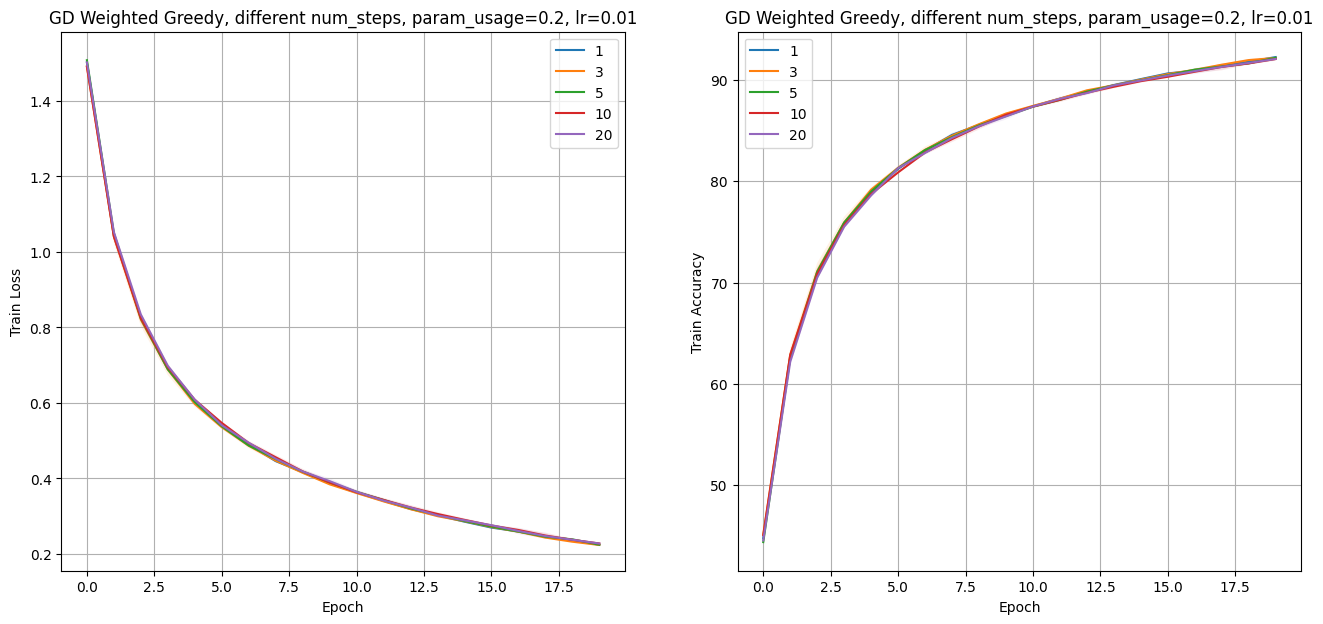

In [42]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for num_steps in num_steps_list[:-1]:
    loss = np.array(train_log[num_steps])
    loss_mean = np.mean(loss, axis=0)
    loss_std = np.std(loss, axis=0)
    
    accuracy = np.array(train_acc[num_steps])
    accuracy_mean = np.mean(accuracy, axis=0)
    accuracy_std = np.std(accuracy, axis=0)
    
    iters = list(range(len(loss_mean)))
    
    axs[0].plot(iters, loss_mean, label=num_steps)
    axs[0].fill_between(iters, loss_mean-loss_std, loss_mean+loss_std, alpha=0.1)
    
    axs[1].plot(iters, accuracy_mean, label=num_steps)
    axs[1].fill_between(iters, accuracy_mean-accuracy_std, accuracy_mean+accuracy_std, alpha=0.1)
    

axs[0].set_title("GD Weighted Greedy, different num_steps, param_usage=0.2, lr=0.01")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Train Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("GD Weighted Greedy, different num_steps, param_usage=0.2, lr=0.01")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Train Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

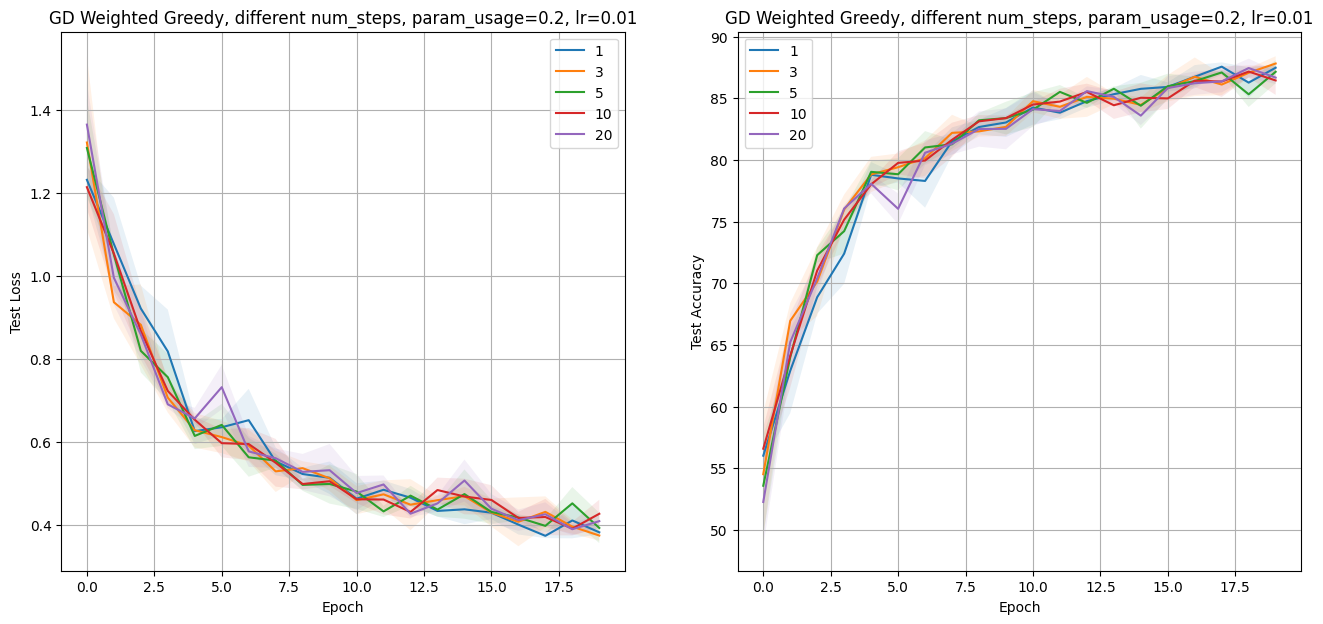

In [43]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for num_steps in num_steps_list[:-1]:
    loss = np.array(test_log[num_steps])
    loss_mean = np.mean(loss, axis=0)
    loss_std = np.std(loss, axis=0)
    
    accuracy = np.array(test_acc[num_steps])
    accuracy_mean = np.mean(accuracy, axis=0)
    accuracy_std = np.std(accuracy, axis=0)
    
    iters = list(range(len(loss_mean)))
    
    axs[0].plot(iters, loss_mean, label=num_steps)
    axs[0].fill_between(iters, loss_mean-loss_std, loss_mean+loss_std, alpha=0.1)
    
    axs[1].plot(iters, accuracy_mean, label=num_steps)
    axs[1].fill_between(iters, accuracy_mean-accuracy_std, accuracy_mean+accuracy_std, alpha=0.1)
    

axs[0].set_title("GD Weighted Greedy, different num_steps, param_usage=0.2, lr=0.01")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Test Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("GD Weighted Greedy, different num_steps, param_usage=0.2, lr=0.01")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Test Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

In [14]:
param_usage = 1.0
num_epochs = 5
lr = 0.01
num_steps_list = [1, 3, 5, 10, 20, 50]

compression_type = 'gradient_descent_weighted_greedy'

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for num_steps in num_steps_list:
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    train_log[num_steps], train_acc[num_steps], test_log[num_steps], test_acc[num_steps] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr, num_steps=num_steps)

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.414 | Train Acc: 48.058% (24029/50000)


 20%|██        | 1/5 [00:21<01:24, 21.07s/it]

Validation Loss: 1.134 | Validation Acc: 60.120% (6012/10000)

Epoch: 1
Train Loss: 0.922 | Train Acc: 67.200% (33600/50000)


 40%|████      | 2/5 [00:40<01:00, 20.19s/it]

Validation Loss: 1.028 | Validation Acc: 66.130% (6613/10000)

Epoch: 2
Train Loss: 0.714 | Train Acc: 74.914% (37457/50000)


 60%|██████    | 3/5 [01:00<00:40, 20.13s/it]

Validation Loss: 0.685 | Validation Acc: 77.020% (7702/10000)

Epoch: 3
Train Loss: 0.606 | Train Acc: 78.858% (39429/50000)


 80%|████████  | 4/5 [01:21<00:20, 20.54s/it]

Validation Loss: 0.751 | Validation Acc: 75.560% (7556/10000)

Epoch: 4
Train Loss: 0.530 | Train Acc: 81.736% (40868/50000)


100%|██████████| 5/5 [01:42<00:00, 20.51s/it]


Validation Loss: 0.577 | Validation Acc: 80.640% (8064/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.435 | Train Acc: 47.392% (23696/50000)


 20%|██        | 1/5 [00:21<01:27, 21.90s/it]

Validation Loss: 1.155 | Validation Acc: 59.370% (5937/10000)

Epoch: 1
Train Loss: 0.955 | Train Acc: 65.942% (32971/50000)


 40%|████      | 2/5 [00:44<01:06, 22.21s/it]

Validation Loss: 0.970 | Validation Acc: 68.010% (6801/10000)

Epoch: 2
Train Loss: 0.725 | Train Acc: 74.558% (37279/50000)


 60%|██████    | 3/5 [01:06<00:44, 22.40s/it]

Validation Loss: 0.726 | Validation Acc: 75.250% (7525/10000)

Epoch: 3
Train Loss: 0.609 | Train Acc: 78.728% (39364/50000)


 80%|████████  | 4/5 [01:28<00:22, 22.03s/it]

Validation Loss: 0.697 | Validation Acc: 76.900% (7690/10000)

Epoch: 4
Train Loss: 0.542 | Train Acc: 81.008% (40504/50000)


100%|██████████| 5/5 [01:49<00:00, 21.86s/it]


Validation Loss: 0.637 | Validation Acc: 78.490% (7849/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.415 | Train Acc: 48.370% (24185/50000)


 20%|██        | 1/5 [00:22<01:30, 22.63s/it]

Validation Loss: 1.175 | Validation Acc: 57.930% (5793/10000)

Epoch: 1
Train Loss: 0.921 | Train Acc: 67.312% (33656/50000)


 40%|████      | 2/5 [00:45<01:08, 22.71s/it]

Validation Loss: 1.089 | Validation Acc: 65.360% (6536/10000)

Epoch: 2
Train Loss: 0.720 | Train Acc: 74.756% (37378/50000)


 60%|██████    | 3/5 [01:09<00:46, 23.33s/it]

Validation Loss: 0.821 | Validation Acc: 72.660% (7266/10000)

Epoch: 3
Train Loss: 0.606 | Train Acc: 78.814% (39407/50000)


 80%|████████  | 4/5 [01:33<00:23, 23.72s/it]

Validation Loss: 0.672 | Validation Acc: 77.530% (7753/10000)

Epoch: 4
Train Loss: 0.534 | Train Acc: 81.562% (40781/50000)


100%|██████████| 5/5 [01:57<00:00, 23.41s/it]


Validation Loss: 0.555 | Validation Acc: 81.270% (8127/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.463 | Train Acc: 46.418% (23209/50000)


 20%|██        | 1/5 [00:24<01:37, 24.49s/it]

Validation Loss: 1.255 | Validation Acc: 56.350% (5635/10000)

Epoch: 1
Train Loss: 0.947 | Train Acc: 66.396% (33198/50000)


 40%|████      | 2/5 [00:51<01:18, 26.18s/it]

Validation Loss: 1.030 | Validation Acc: 66.030% (6603/10000)

Epoch: 2
Train Loss: 0.737 | Train Acc: 74.126% (37063/50000)


 60%|██████    | 3/5 [01:18<00:52, 26.38s/it]

Validation Loss: 0.701 | Validation Acc: 75.940% (7594/10000)

Epoch: 3
Train Loss: 0.616 | Train Acc: 78.508% (39254/50000)


 80%|████████  | 4/5 [01:43<00:25, 25.97s/it]

Validation Loss: 0.648 | Validation Acc: 78.010% (7801/10000)

Epoch: 4
Train Loss: 0.537 | Train Acc: 81.352% (40676/50000)


100%|██████████| 5/5 [02:10<00:00, 26.12s/it]


Validation Loss: 0.609 | Validation Acc: 79.070% (7907/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.436 | Train Acc: 47.436% (23718/50000)


 20%|██        | 1/5 [00:33<02:14, 33.69s/it]

Validation Loss: 1.442 | Validation Acc: 53.070% (5307/10000)

Epoch: 1
Train Loss: 0.938 | Train Acc: 66.844% (33422/50000)


 40%|████      | 2/5 [01:06<01:40, 33.34s/it]

Validation Loss: 0.882 | Validation Acc: 69.590% (6959/10000)

Epoch: 2
Train Loss: 0.728 | Train Acc: 74.470% (37235/50000)


 60%|██████    | 3/5 [01:38<01:05, 32.51s/it]

Validation Loss: 0.747 | Validation Acc: 75.240% (7524/10000)

Epoch: 3
Train Loss: 0.615 | Train Acc: 78.544% (39272/50000)


 80%|████████  | 4/5 [02:13<00:33, 33.40s/it]

Validation Loss: 0.759 | Validation Acc: 75.310% (7531/10000)

Epoch: 4
Train Loss: 0.543 | Train Acc: 81.174% (40587/50000)


100%|██████████| 5/5 [02:46<00:00, 33.27s/it]


Validation Loss: 0.664 | Validation Acc: 77.670% (7767/10000)


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.468 | Train Acc: 46.236% (23118/50000)


 20%|██        | 1/5 [00:51<03:24, 51.22s/it]

Validation Loss: 1.379 | Validation Acc: 53.500% (5350/10000)

Epoch: 1
Train Loss: 0.978 | Train Acc: 64.940% (32470/50000)


 40%|████      | 2/5 [01:42<02:34, 51.50s/it]

Validation Loss: 0.957 | Validation Acc: 66.340% (6634/10000)

Epoch: 2
Train Loss: 0.757 | Train Acc: 73.480% (36740/50000)


 60%|██████    | 3/5 [02:35<01:43, 51.85s/it]

Validation Loss: 1.105 | Validation Acc: 66.400% (6640/10000)

Epoch: 3
Train Loss: 0.637 | Train Acc: 77.876% (38938/50000)


 80%|████████  | 4/5 [03:27<00:51, 51.86s/it]

Validation Loss: 0.738 | Validation Acc: 75.520% (7552/10000)

Epoch: 4
Train Loss: 0.554 | Train Acc: 80.666% (40333/50000)


100%|██████████| 5/5 [04:18<00:00, 51.64s/it]

Validation Loss: 0.581 | Validation Acc: 80.380% (8038/10000)


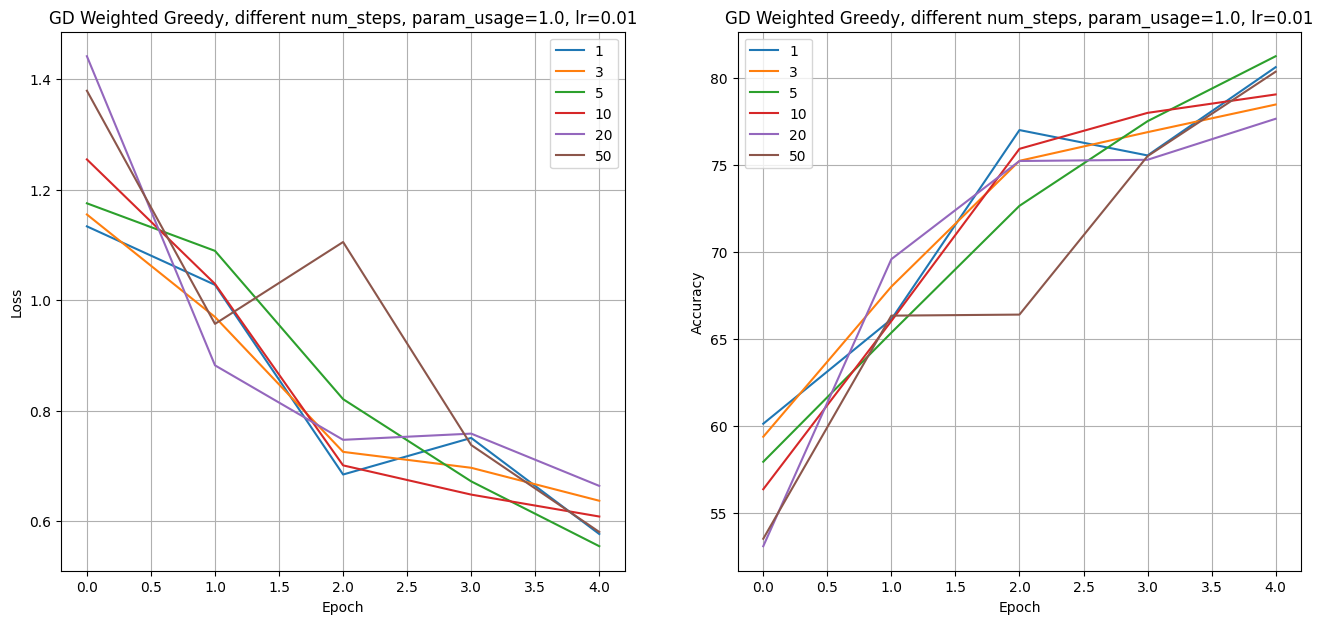

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for num_steps in test_log:
    axs[0].plot(test_log[num_steps], label=num_steps)
    axs[1].plot(test_acc[num_steps], label=num_steps)

axs[0].set_title("GD Weighted Greedy, different num_steps, param_usage=1.0, lr=0.01")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("GD Weighted Greedy, different num_steps, param_usage=1.0, lr=0.01")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

In [34]:
compression_types = ['square_greedy', 'square_greedy_ef', 'gradient_descent_weighted_greedy', 'mirror_descent_weighted_greedy']
param_usage = 0.2
num_epochs = 15
lr = 0.01

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for compression_type in compression_types:
    lr = 0.01
    set_seed(52)
    net = ResNet18().to(device)
    if compression_type == 'square_greedy_ef':
        lr = 0.005
    if compression_type == 'gradient_descent_weighted_greedy':
        lr = 0.02
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    train_log[compression_type], train_acc[compression_type], test_log[compression_type], test_acc[compression_type] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr)

  0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.493 | Train Acc: 45.580% (22790/50000)


  7%|▋         | 1/15 [00:13<03:07, 13.37s/it]

Validation Loss: 1.366 | Validation Acc: 52.600% (5260/10000)

Epoch: 1
Train Loss: 1.017 | Train Acc: 63.932% (31966/50000)


 13%|█▎        | 2/15 [00:26<02:53, 13.38s/it]

Validation Loss: 1.013 | Validation Acc: 66.120% (6612/10000)

Epoch: 2
Train Loss: 0.781 | Train Acc: 72.746% (36373/50000)


 20%|██        | 3/15 [00:39<02:36, 13.05s/it]

Validation Loss: 0.771 | Validation Acc: 74.070% (7407/10000)

Epoch: 3
Train Loss: 0.657 | Train Acc: 76.886% (38443/50000)


 27%|██▋       | 4/15 [00:52<02:23, 13.04s/it]

Validation Loss: 0.744 | Validation Acc: 75.720% (7572/10000)

Epoch: 4
Train Loss: 0.575 | Train Acc: 80.122% (40061/50000)


 33%|███▎      | 5/15 [01:05<02:10, 13.05s/it]

Validation Loss: 0.664 | Validation Acc: 78.190% (7819/10000)

Epoch: 5
Train Loss: 0.513 | Train Acc: 82.228% (41114/50000)


 40%|████      | 6/15 [01:18<01:57, 13.04s/it]

Validation Loss: 0.657 | Validation Acc: 78.610% (7861/10000)

Epoch: 6
Train Loss: 0.461 | Train Acc: 84.020% (42010/50000)


 47%|████▋     | 7/15 [01:31<01:43, 12.94s/it]

Validation Loss: 0.658 | Validation Acc: 79.120% (7912/10000)

Epoch: 7
Train Loss: 0.427 | Train Acc: 85.436% (42718/50000)


 53%|█████▎    | 8/15 [01:44<01:30, 12.99s/it]

Validation Loss: 0.572 | Validation Acc: 80.790% (8079/10000)

Epoch: 8
Train Loss: 0.397 | Train Acc: 86.248% (43124/50000)


 60%|██████    | 9/15 [01:57<01:18, 13.02s/it]

Validation Loss: 0.470 | Validation Acc: 84.560% (8456/10000)

Epoch: 9
Train Loss: 0.370 | Train Acc: 87.332% (43666/50000)


 67%|██████▋   | 10/15 [02:10<01:05, 13.01s/it]

Validation Loss: 0.473 | Validation Acc: 84.280% (8428/10000)

Epoch: 10
Train Loss: 0.343 | Train Acc: 88.292% (44146/50000)


 73%|███████▎  | 11/15 [02:23<00:51, 12.96s/it]

Validation Loss: 0.494 | Validation Acc: 83.590% (8359/10000)

Epoch: 11
Train Loss: 0.320 | Train Acc: 88.970% (44485/50000)


 80%|████████  | 12/15 [02:36<00:38, 12.91s/it]

Validation Loss: 0.470 | Validation Acc: 84.240% (8424/10000)

Epoch: 12
Train Loss: 0.298 | Train Acc: 89.664% (44832/50000)


 87%|████████▋ | 13/15 [02:49<00:25, 12.96s/it]

Validation Loss: 0.426 | Validation Acc: 85.580% (8558/10000)

Epoch: 13
Train Loss: 0.284 | Train Acc: 90.092% (45046/50000)


 93%|█████████▎| 14/15 [03:02<00:13, 13.05s/it]

Validation Loss: 0.415 | Validation Acc: 86.440% (8644/10000)

Epoch: 14
Train Loss: 0.269 | Train Acc: 90.718% (45359/50000)


100%|██████████| 15/15 [03:15<00:00, 13.03s/it]


Validation Loss: 0.384 | Validation Acc: 87.370% (8737/10000)


  0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.534 | Train Acc: 43.548% (21774/50000)


  7%|▋         | 1/15 [00:12<02:59, 12.82s/it]

Validation Loss: 1.327 | Validation Acc: 54.050% (5405/10000)

Epoch: 1
Train Loss: 1.026 | Train Acc: 63.276% (31638/50000)


 13%|█▎        | 2/15 [00:25<02:46, 12.80s/it]

Validation Loss: 0.905 | Validation Acc: 68.940% (6894/10000)

Epoch: 2
Train Loss: 0.805 | Train Acc: 71.816% (35908/50000)


 20%|██        | 3/15 [00:38<02:33, 12.76s/it]

Validation Loss: 0.915 | Validation Acc: 69.430% (6943/10000)

Epoch: 3
Train Loss: 0.676 | Train Acc: 76.172% (38086/50000)


 27%|██▋       | 4/15 [00:51<02:22, 12.92s/it]

Validation Loss: 0.688 | Validation Acc: 76.210% (7621/10000)

Epoch: 4
Train Loss: 0.588 | Train Acc: 79.626% (39813/50000)


 33%|███▎      | 5/15 [01:04<02:08, 12.90s/it]

Validation Loss: 0.640 | Validation Acc: 78.270% (7827/10000)

Epoch: 5
Train Loss: 0.524 | Train Acc: 81.724% (40862/50000)


 40%|████      | 6/15 [01:17<01:57, 13.09s/it]

Validation Loss: 0.556 | Validation Acc: 81.130% (8113/10000)

Epoch: 6
Train Loss: 0.477 | Train Acc: 83.362% (41681/50000)


 47%|████▋     | 7/15 [01:31<01:46, 13.31s/it]

Validation Loss: 0.610 | Validation Acc: 80.190% (8019/10000)

Epoch: 7
Train Loss: 0.438 | Train Acc: 84.862% (42431/50000)


 53%|█████▎    | 8/15 [01:45<01:34, 13.48s/it]

Validation Loss: 0.528 | Validation Acc: 82.290% (8229/10000)

Epoch: 8
Train Loss: 0.411 | Train Acc: 85.810% (42905/50000)


 60%|██████    | 9/15 [01:58<01:20, 13.42s/it]

Validation Loss: 0.492 | Validation Acc: 84.000% (8400/10000)

Epoch: 9
Train Loss: 0.377 | Train Acc: 86.878% (43439/50000)


 67%|██████▋   | 10/15 [02:12<01:07, 13.53s/it]

Validation Loss: 0.504 | Validation Acc: 83.670% (8367/10000)

Epoch: 10
Train Loss: 0.354 | Train Acc: 87.718% (43859/50000)


 73%|███████▎  | 11/15 [02:25<00:53, 13.43s/it]

Validation Loss: 0.463 | Validation Acc: 85.010% (8501/10000)

Epoch: 11
Train Loss: 0.332 | Train Acc: 88.402% (44201/50000)


 80%|████████  | 12/15 [02:38<00:39, 13.31s/it]

Validation Loss: 0.552 | Validation Acc: 81.930% (8193/10000)

Epoch: 12
Train Loss: 0.312 | Train Acc: 89.136% (44568/50000)


 87%|████████▋ | 13/15 [02:52<00:27, 13.54s/it]

Validation Loss: 0.495 | Validation Acc: 84.400% (8440/10000)

Epoch: 13
Train Loss: 0.294 | Train Acc: 89.844% (44922/50000)


 93%|█████████▎| 14/15 [03:06<00:13, 13.53s/it]

Validation Loss: 0.478 | Validation Acc: 85.580% (8558/10000)

Epoch: 14
Train Loss: 0.282 | Train Acc: 90.130% (45065/50000)


100%|██████████| 15/15 [03:17<00:00, 13.20s/it]


Validation Loss: 0.402 | Validation Acc: 86.880% (8688/10000)


  0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.501 | Train Acc: 45.214% (22607/50000)


  7%|▋         | 1/15 [00:21<04:59, 21.38s/it]

Validation Loss: 1.373 | Validation Acc: 53.090% (5309/10000)

Epoch: 1
Train Loss: 1.041 | Train Acc: 63.184% (31592/50000)


 13%|█▎        | 2/15 [00:42<04:38, 21.43s/it]

Validation Loss: 1.076 | Validation Acc: 63.280% (6328/10000)

Epoch: 2
Train Loss: 0.799 | Train Acc: 71.942% (35971/50000)


 20%|██        | 3/15 [01:05<04:21, 21.83s/it]

Validation Loss: 0.744 | Validation Acc: 74.920% (7492/10000)

Epoch: 3
Train Loss: 0.669 | Train Acc: 76.626% (38313/50000)


 27%|██▋       | 4/15 [01:28<04:05, 22.36s/it]

Validation Loss: 0.730 | Validation Acc: 75.720% (7572/10000)

Epoch: 4
Train Loss: 0.587 | Train Acc: 79.814% (39907/50000)


 33%|███▎      | 5/15 [01:50<03:42, 22.27s/it]

Validation Loss: 0.680 | Validation Acc: 76.480% (7648/10000)

Epoch: 5
Train Loss: 0.524 | Train Acc: 81.852% (40926/50000)


 40%|████      | 6/15 [02:12<03:19, 22.19s/it]

Validation Loss: 0.662 | Validation Acc: 78.630% (7863/10000)

Epoch: 6
Train Loss: 0.479 | Train Acc: 83.180% (41590/50000)


 47%|████▋     | 7/15 [02:34<02:55, 21.98s/it]

Validation Loss: 0.634 | Validation Acc: 79.480% (7948/10000)

Epoch: 7
Train Loss: 0.448 | Train Acc: 84.504% (42252/50000)


 53%|█████▎    | 8/15 [02:55<02:33, 21.94s/it]

Validation Loss: 0.596 | Validation Acc: 79.750% (7975/10000)

Epoch: 8
Train Loss: 0.412 | Train Acc: 85.790% (42895/50000)


 60%|██████    | 9/15 [03:16<02:09, 21.57s/it]

Validation Loss: 0.468 | Validation Acc: 84.390% (8439/10000)

Epoch: 9
Train Loss: 0.387 | Train Acc: 86.632% (43316/50000)


 67%|██████▋   | 10/15 [03:36<01:45, 21.14s/it]

Validation Loss: 0.481 | Validation Acc: 83.740% (8374/10000)

Epoch: 10
Train Loss: 0.363 | Train Acc: 87.388% (43694/50000)


 73%|███████▎  | 11/15 [03:58<01:25, 21.46s/it]

Validation Loss: 0.490 | Validation Acc: 83.700% (8370/10000)

Epoch: 11
Train Loss: 0.342 | Train Acc: 88.148% (44074/50000)


 80%|████████  | 12/15 [04:20<01:04, 21.51s/it]

Validation Loss: 0.536 | Validation Acc: 82.190% (8219/10000)

Epoch: 12
Train Loss: 0.320 | Train Acc: 88.772% (44386/50000)


 87%|████████▋ | 13/15 [04:40<00:42, 21.07s/it]

Validation Loss: 0.444 | Validation Acc: 84.940% (8494/10000)

Epoch: 13
Train Loss: 0.304 | Train Acc: 89.534% (44767/50000)


 93%|█████████▎| 14/15 [05:01<00:21, 21.03s/it]

Validation Loss: 0.413 | Validation Acc: 86.060% (8606/10000)

Epoch: 14
Train Loss: 0.291 | Train Acc: 89.932% (44966/50000)


100%|██████████| 15/15 [05:22<00:00, 21.52s/it]


Validation Loss: 0.437 | Validation Acc: 85.560% (8556/10000)


  0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.473 | Train Acc: 46.184% (23092/50000)


  7%|▋         | 1/15 [00:21<05:01, 21.50s/it]

Validation Loss: 1.244 | Validation Acc: 56.940% (5694/10000)

Epoch: 1
Train Loss: 1.013 | Train Acc: 64.064% (32032/50000)


 13%|█▎        | 2/15 [00:43<04:46, 22.04s/it]

Validation Loss: 0.957 | Validation Acc: 68.080% (6808/10000)

Epoch: 2
Train Loss: 0.778 | Train Acc: 72.990% (36495/50000)


 20%|██        | 3/15 [01:06<04:25, 22.15s/it]

Validation Loss: 0.788 | Validation Acc: 73.020% (7302/10000)

Epoch: 3
Train Loss: 0.657 | Train Acc: 76.876% (38438/50000)


 27%|██▋       | 4/15 [01:28<04:04, 22.24s/it]

Validation Loss: 0.672 | Validation Acc: 77.220% (7722/10000)

Epoch: 4
Train Loss: 0.571 | Train Acc: 80.160% (40080/50000)


 33%|███▎      | 5/15 [01:50<03:42, 22.20s/it]

Validation Loss: 0.667 | Validation Acc: 78.040% (7804/10000)

Epoch: 5
Train Loss: 0.509 | Train Acc: 82.334% (41167/50000)


 40%|████      | 6/15 [02:12<03:18, 22.03s/it]

Validation Loss: 0.646 | Validation Acc: 78.560% (7856/10000)

Epoch: 6
Train Loss: 0.464 | Train Acc: 83.870% (41935/50000)


 47%|████▋     | 7/15 [02:35<03:00, 22.52s/it]

Validation Loss: 0.583 | Validation Acc: 80.500% (8050/10000)

Epoch: 7
Train Loss: 0.426 | Train Acc: 85.300% (42650/50000)


 53%|█████▎    | 8/15 [02:57<02:36, 22.37s/it]

Validation Loss: 0.571 | Validation Acc: 80.930% (8093/10000)

Epoch: 8
Train Loss: 0.391 | Train Acc: 86.452% (43226/50000)


 60%|██████    | 9/15 [03:19<02:13, 22.24s/it]

Validation Loss: 0.492 | Validation Acc: 83.550% (8355/10000)

Epoch: 9
Train Loss: 0.364 | Train Acc: 87.508% (43754/50000)


 67%|██████▋   | 10/15 [03:41<01:50, 22.09s/it]

Validation Loss: 0.464 | Validation Acc: 84.410% (8441/10000)

Epoch: 10
Train Loss: 0.341 | Train Acc: 88.170% (44085/50000)


 73%|███████▎  | 11/15 [04:05<01:29, 22.49s/it]

Validation Loss: 0.500 | Validation Acc: 83.610% (8361/10000)

Epoch: 11
Train Loss: 0.319 | Train Acc: 88.930% (44465/50000)


 80%|████████  | 12/15 [04:27<01:07, 22.53s/it]

Validation Loss: 0.598 | Validation Acc: 80.870% (8087/10000)

Epoch: 12
Train Loss: 0.297 | Train Acc: 89.644% (44822/50000)


 87%|████████▋ | 13/15 [04:49<00:44, 22.33s/it]

Validation Loss: 0.512 | Validation Acc: 83.800% (8380/10000)

Epoch: 13
Train Loss: 0.281 | Train Acc: 90.294% (45147/50000)


 93%|█████████▎| 14/15 [05:11<00:22, 22.18s/it]

Validation Loss: 0.403 | Validation Acc: 86.960% (8696/10000)

Epoch: 14
Train Loss: 0.267 | Train Acc: 90.732% (45366/50000)


100%|██████████| 15/15 [05:32<00:00, 22.19s/it]

Validation Loss: 0.437 | Validation Acc: 86.150% (8615/10000)


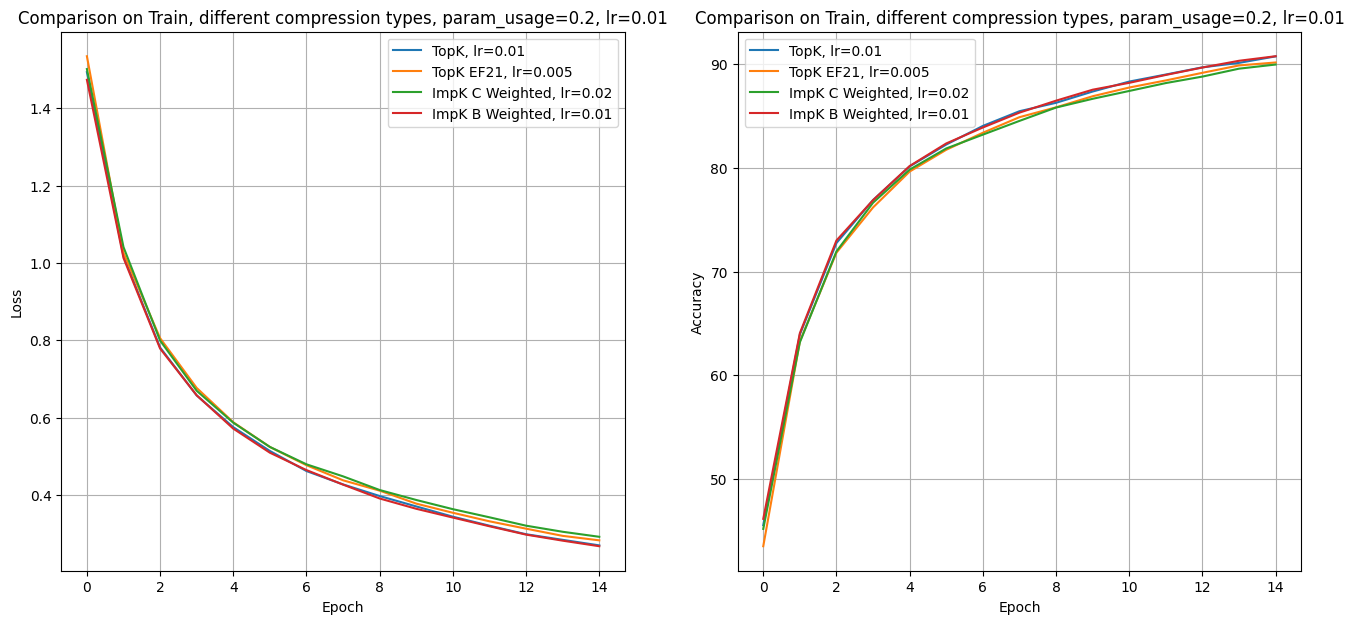

In [35]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

names = {
    'mirror_descent_stochastic': 'ImpK B Stochastic',
    'mirror_descent_weighted_greedy': 'ImpK B Weighted, lr=0.01',
    'gradient_descent_weighted_greedy': 'ImpK C Weighted, lr=0.02',
    'mirror_descent_greedy': 'ImpK B',
    'mirror_descent_greedy_weighted': 'ImpK B Weighted 1',
    'random': 'RandK',
    'square_greedy': 'TopK, lr=0.01',
    'square_greedy_ef': 'TopK EF21, lr=0.005'
}

for compression_type in test_log:
    axs[0].plot(train_log[compression_type], label=names[compression_type])
    axs[1].plot(train_acc[compression_type], label=names[compression_type])

axs[0].set_title("Comparison on Train, different compression types, param_usage=0.2, lr=0.01")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Train, different compression types, param_usage=0.2, lr=0.01")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

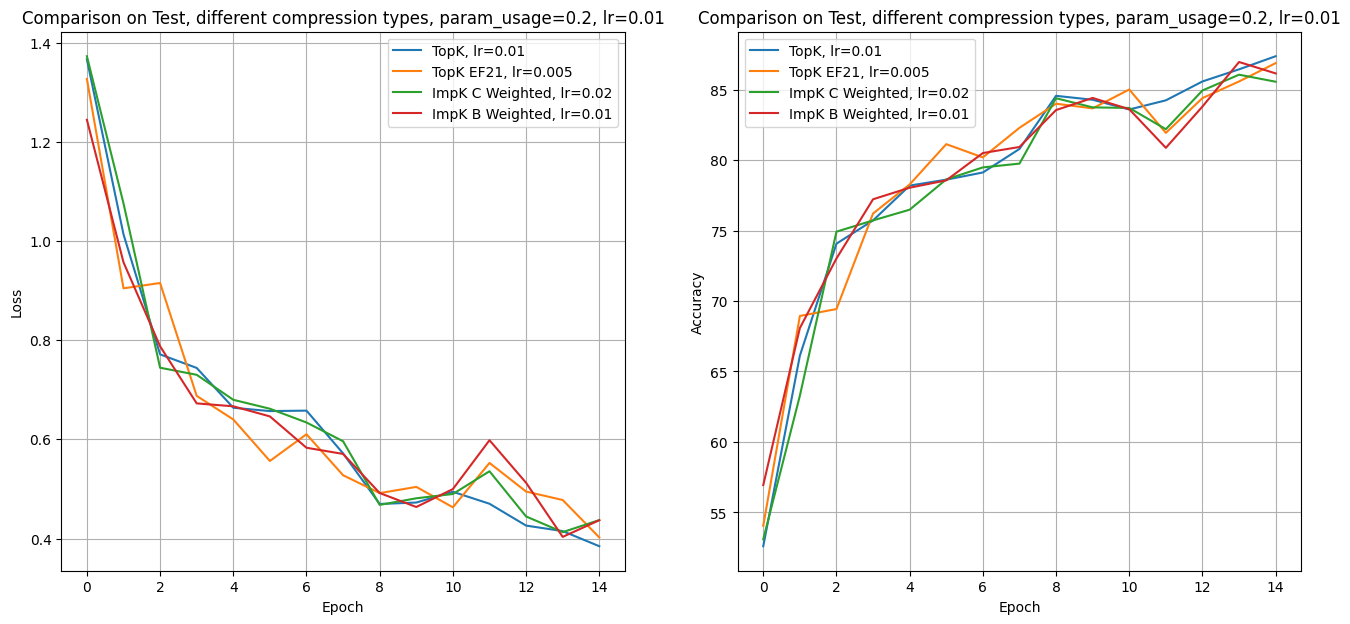

In [36]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

names = {
    'mirror_descent_stochastic': 'ImpK B Stochastic',
    'mirror_descent_weighted_greedy': 'ImpK B Weighted, lr=0.01',
    'gradient_descent_weighted_greedy': 'ImpK C Weighted, lr=0.02',
    'mirror_descent_greedy': 'ImpK B',
    'mirror_descent_greedy_weighted': 'ImpK B Weighted 1',
    'random': 'RandK',
    'square_greedy': 'TopK, lr=0.01',
    'square_greedy_ef': 'TopK EF21, lr=0.005'
}

for compression_type in test_log:
    axs[0].plot(test_log[compression_type], label=names[compression_type])
    axs[1].plot(test_acc[compression_type], label=names[compression_type])

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.2, lr=0.01")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.2, lr=0.01")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

In [8]:
compression_types = ['square_greedy', 'square_greedy_ef', 'gradient_descent_weighted_greedy', 'mirror_descent_weighted_greedy']
param_usage = 0.1
num_epochs = 15
lr = 0.01
num_restarts = 3

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for compression_type in compression_types:
    lr = 0.01
    train_log[compression_type], train_acc[compression_type], test_log[compression_type], test_acc[compression_type] = [], [], [], []
    
    for num_restart in range(num_restarts):
        set_seed(52 + num_restart)
        net = ResNet18().to(device)
        if compression_type == 'square_greedy_ef':
            lr = 0.005
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        criterion = nn.CrossEntropyLoss()
        
        train_loss, train_accuracy, test_loss, test_accuracy = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr)
        
        train_log[compression_type].append(train_loss)
        train_acc[compression_type].append(train_accuracy)
        test_log[compression_type].append(test_loss)
        test_acc[compression_type].append(test_accuracy)

  0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.519 | Train Acc: 44.020% (22010/50000)


  7%|▋         | 1/15 [00:13<03:09, 13.57s/it]

Validation Loss: 1.417 | Validation Acc: 49.770% (4977/10000)

Epoch: 1
Train Loss: 1.077 | Train Acc: 61.628% (30814/50000)


 13%|█▎        | 2/15 [00:25<02:47, 12.90s/it]

Validation Loss: 1.023 | Validation Acc: 64.650% (6465/10000)

Epoch: 2
Train Loss: 0.849 | Train Acc: 70.096% (35048/50000)


 20%|██        | 3/15 [00:39<02:36, 13.03s/it]

Validation Loss: 0.919 | Validation Acc: 69.080% (6908/10000)

Epoch: 3
Train Loss: 0.719 | Train Acc: 74.752% (37376/50000)


 27%|██▋       | 4/15 [00:51<02:19, 12.66s/it]

Validation Loss: 0.741 | Validation Acc: 74.650% (7465/10000)

Epoch: 4
Train Loss: 0.629 | Train Acc: 77.928% (38964/50000)


 33%|███▎      | 5/15 [01:03<02:06, 12.66s/it]

Validation Loss: 0.736 | Validation Acc: 74.940% (7494/10000)

Epoch: 5
Train Loss: 0.562 | Train Acc: 80.240% (40120/50000)


 40%|████      | 6/15 [01:16<01:54, 12.73s/it]

Validation Loss: 0.672 | Validation Acc: 77.970% (7797/10000)

Epoch: 6
Train Loss: 0.519 | Train Acc: 82.034% (41017/50000)


 47%|████▋     | 7/15 [01:29<01:41, 12.65s/it]

Validation Loss: 0.555 | Validation Acc: 81.620% (8162/10000)

Epoch: 7
Train Loss: 0.479 | Train Acc: 83.372% (41686/50000)


 53%|█████▎    | 8/15 [01:42<01:28, 12.69s/it]

Validation Loss: 0.587 | Validation Acc: 79.680% (7968/10000)

Epoch: 8
Train Loss: 0.445 | Train Acc: 84.574% (42287/50000)


 60%|██████    | 9/15 [01:55<01:17, 12.89s/it]

Validation Loss: 0.532 | Validation Acc: 82.280% (8228/10000)

Epoch: 9
Train Loss: 0.418 | Train Acc: 85.584% (42792/50000)


 67%|██████▋   | 10/15 [02:08<01:04, 13.00s/it]

Validation Loss: 0.493 | Validation Acc: 83.250% (8325/10000)

Epoch: 10
Train Loss: 0.393 | Train Acc: 86.306% (43153/50000)


 73%|███████▎  | 11/15 [02:21<00:51, 12.88s/it]

Validation Loss: 0.578 | Validation Acc: 80.630% (8063/10000)

Epoch: 11
Train Loss: 0.367 | Train Acc: 87.088% (43544/50000)


 80%|████████  | 12/15 [02:34<00:38, 12.88s/it]

Validation Loss: 0.562 | Validation Acc: 81.150% (8115/10000)

Epoch: 12
Train Loss: 0.348 | Train Acc: 87.940% (43970/50000)


 87%|████████▋ | 13/15 [02:47<00:25, 12.90s/it]

Validation Loss: 0.656 | Validation Acc: 79.150% (7915/10000)

Epoch: 13
Train Loss: 0.331 | Train Acc: 88.556% (44278/50000)


 93%|█████████▎| 14/15 [02:58<00:12, 12.50s/it]

Validation Loss: 0.449 | Validation Acc: 85.310% (8531/10000)

Epoch: 14
Train Loss: 0.317 | Train Acc: 88.884% (44442/50000)


100%|██████████| 15/15 [03:11<00:00, 12.75s/it]


Validation Loss: 0.443 | Validation Acc: 85.180% (8518/10000)


  0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.790 | Train Acc: 36.388% (18194/50000)


  7%|▋         | 1/15 [00:12<03:01, 12.95s/it]

Validation Loss: 1.584 | Validation Acc: 45.670% (4567/10000)

Epoch: 1
Train Loss: 1.165 | Train Acc: 58.098% (29049/50000)


 13%|█▎        | 2/15 [00:24<02:38, 12.17s/it]

Validation Loss: 1.122 | Validation Acc: 59.820% (5982/10000)

Epoch: 2
Train Loss: 0.906 | Train Acc: 67.888% (33944/50000)


 20%|██        | 3/15 [00:37<02:28, 12.35s/it]

Validation Loss: 1.016 | Validation Acc: 66.430% (6643/10000)

Epoch: 3
Train Loss: 0.774 | Train Acc: 72.698% (36349/50000)


 27%|██▋       | 4/15 [00:51<02:22, 12.96s/it]

Validation Loss: 0.808 | Validation Acc: 72.530% (7253/10000)

Epoch: 4
Train Loss: 0.677 | Train Acc: 76.286% (38143/50000)


 33%|███▎      | 5/15 [01:03<02:09, 12.92s/it]

Validation Loss: 0.830 | Validation Acc: 72.790% (7279/10000)

Epoch: 5
Train Loss: 0.616 | Train Acc: 78.504% (39252/50000)


 40%|████      | 6/15 [01:17<01:58, 13.15s/it]

Validation Loss: 0.679 | Validation Acc: 77.490% (7749/10000)

Epoch: 6
Train Loss: 0.561 | Train Acc: 80.278% (40139/50000)


 47%|████▋     | 7/15 [01:29<01:43, 12.90s/it]

Validation Loss: 0.706 | Validation Acc: 77.270% (7727/10000)

Epoch: 7
Train Loss: 0.527 | Train Acc: 81.648% (40824/50000)


 53%|█████▎    | 8/15 [01:42<01:30, 12.93s/it]

Validation Loss: 0.639 | Validation Acc: 78.140% (7814/10000)

Epoch: 8
Train Loss: 0.494 | Train Acc: 82.832% (41416/50000)


 60%|██████    | 9/15 [01:55<01:17, 12.92s/it]

Validation Loss: 0.580 | Validation Acc: 81.200% (8120/10000)

Epoch: 9
Train Loss: 0.462 | Train Acc: 84.000% (42000/50000)


 67%|██████▋   | 10/15 [02:08<01:04, 12.90s/it]

Validation Loss: 0.532 | Validation Acc: 82.550% (8255/10000)

Epoch: 10
Train Loss: 0.436 | Train Acc: 84.690% (42345/50000)


 73%|███████▎  | 11/15 [02:20<00:50, 12.68s/it]

Validation Loss: 0.500 | Validation Acc: 83.100% (8310/10000)

Epoch: 11
Train Loss: 0.416 | Train Acc: 85.454% (42727/50000)


 80%|████████  | 12/15 [02:34<00:39, 13.09s/it]

Validation Loss: 0.541 | Validation Acc: 81.530% (8153/10000)

Epoch: 12
Train Loss: 0.389 | Train Acc: 86.426% (43213/50000)


 87%|████████▋ | 13/15 [02:47<00:26, 13.02s/it]

Validation Loss: 0.533 | Validation Acc: 82.810% (8281/10000)

Epoch: 13
Train Loss: 0.373 | Train Acc: 87.018% (43509/50000)


 93%|█████████▎| 14/15 [02:59<00:12, 12.78s/it]

Validation Loss: 0.491 | Validation Acc: 84.250% (8425/10000)

Epoch: 14
Train Loss: 0.362 | Train Acc: 87.262% (43631/50000)


100%|██████████| 15/15 [03:13<00:00, 12.88s/it]


Validation Loss: 0.479 | Validation Acc: 84.870% (8487/10000)


  0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.517 | Train Acc: 44.258% (22129/50000)


  7%|▋         | 1/15 [00:23<05:25, 23.25s/it]

Validation Loss: 1.336 | Validation Acc: 52.960% (5296/10000)

Epoch: 1
Train Loss: 1.058 | Train Acc: 62.194% (31097/50000)


 13%|█▎        | 2/15 [00:46<05:03, 23.37s/it]

Validation Loss: 0.990 | Validation Acc: 65.630% (6563/10000)

Epoch: 2
Train Loss: 0.828 | Train Acc: 70.848% (35424/50000)


 20%|██        | 3/15 [01:07<04:29, 22.42s/it]

Validation Loss: 0.881 | Validation Acc: 69.480% (6948/10000)

Epoch: 3
Train Loss: 0.702 | Train Acc: 75.248% (37624/50000)


 27%|██▋       | 4/15 [01:28<04:00, 21.83s/it]

Validation Loss: 0.725 | Validation Acc: 74.780% (7478/10000)

Epoch: 4
Train Loss: 0.621 | Train Acc: 78.406% (39203/50000)


 33%|███▎      | 5/15 [01:49<03:34, 21.46s/it]

Validation Loss: 0.659 | Validation Acc: 77.100% (7710/10000)

Epoch: 5
Train Loss: 0.555 | Train Acc: 80.642% (40321/50000)


 40%|████      | 6/15 [02:11<03:15, 21.69s/it]

Validation Loss: 0.663 | Validation Acc: 77.800% (7780/10000)

Epoch: 6
Train Loss: 0.506 | Train Acc: 82.596% (41298/50000)


 47%|████▋     | 7/15 [02:34<02:55, 22.00s/it]

Validation Loss: 0.674 | Validation Acc: 77.490% (7749/10000)

Epoch: 7
Train Loss: 0.469 | Train Acc: 83.766% (41883/50000)


 53%|█████▎    | 8/15 [02:54<02:30, 21.52s/it]

Validation Loss: 0.624 | Validation Acc: 78.400% (7840/10000)

Epoch: 8
Train Loss: 0.436 | Train Acc: 84.938% (42469/50000)


 60%|██████    | 9/15 [03:16<02:08, 21.47s/it]

Validation Loss: 0.530 | Validation Acc: 82.140% (8214/10000)

Epoch: 9
Train Loss: 0.412 | Train Acc: 85.622% (42811/50000)


 67%|██████▋   | 10/15 [03:38<01:47, 21.53s/it]

Validation Loss: 0.530 | Validation Acc: 82.280% (8228/10000)

Epoch: 10
Train Loss: 0.384 | Train Acc: 86.666% (43333/50000)


 73%|███████▎  | 11/15 [03:59<01:26, 21.67s/it]

Validation Loss: 0.504 | Validation Acc: 83.440% (8344/10000)

Epoch: 11
Train Loss: 0.362 | Train Acc: 87.220% (43610/50000)


 80%|████████  | 12/15 [04:21<01:04, 21.62s/it]

Validation Loss: 0.517 | Validation Acc: 82.310% (8231/10000)

Epoch: 12
Train Loss: 0.340 | Train Acc: 88.160% (44080/50000)


 87%|████████▋ | 13/15 [04:43<00:43, 21.79s/it]

Validation Loss: 0.513 | Validation Acc: 83.330% (8333/10000)

Epoch: 13
Train Loss: 0.323 | Train Acc: 88.762% (44381/50000)


 93%|█████████▎| 14/15 [05:05<00:21, 21.85s/it]

Validation Loss: 0.407 | Validation Acc: 86.410% (8641/10000)

Epoch: 14
Train Loss: 0.308 | Train Acc: 89.356% (44678/50000)


100%|██████████| 15/15 [05:28<00:00, 21.87s/it]


Validation Loss: 0.424 | Validation Acc: 86.190% (8619/10000)


  0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.506 | Train Acc: 44.752% (22376/50000)


  7%|▋         | 1/15 [00:23<05:24, 23.20s/it]

Validation Loss: 1.243 | Validation Acc: 55.840% (5584/10000)

Epoch: 1
Train Loss: 1.060 | Train Acc: 62.258% (31129/50000)


 13%|█▎        | 2/15 [00:46<05:01, 23.19s/it]

Validation Loss: 0.982 | Validation Acc: 65.490% (6549/10000)

Epoch: 2
Train Loss: 0.832 | Train Acc: 70.738% (35369/50000)


 20%|██        | 3/15 [01:08<04:31, 22.61s/it]

Validation Loss: 0.895 | Validation Acc: 69.400% (6940/10000)

Epoch: 3
Train Loss: 0.702 | Train Acc: 75.438% (37719/50000)


 27%|██▋       | 4/15 [01:30<04:08, 22.62s/it]

Validation Loss: 0.694 | Validation Acc: 76.050% (7605/10000)

Epoch: 4
Train Loss: 0.616 | Train Acc: 78.468% (39234/50000)


 33%|███▎      | 5/15 [01:52<03:42, 22.20s/it]

Validation Loss: 0.686 | Validation Acc: 76.950% (7695/10000)

Epoch: 5
Train Loss: 0.553 | Train Acc: 80.798% (40399/50000)


 40%|████      | 6/15 [02:14<03:20, 22.23s/it]

Validation Loss: 0.783 | Validation Acc: 75.220% (7522/10000)

Epoch: 6
Train Loss: 0.509 | Train Acc: 82.272% (41136/50000)


 47%|████▋     | 7/15 [02:36<02:57, 22.18s/it]

Validation Loss: 0.607 | Validation Acc: 80.270% (8027/10000)

Epoch: 7
Train Loss: 0.469 | Train Acc: 83.758% (41879/50000)


 53%|█████▎    | 8/15 [02:59<02:35, 22.21s/it]

Validation Loss: 0.560 | Validation Acc: 81.130% (8113/10000)

Epoch: 8
Train Loss: 0.437 | Train Acc: 84.888% (42444/50000)


 60%|██████    | 9/15 [03:20<02:11, 21.91s/it]

Validation Loss: 0.574 | Validation Acc: 81.160% (8116/10000)

Epoch: 9
Train Loss: 0.410 | Train Acc: 85.892% (42946/50000)


 67%|██████▋   | 10/15 [03:43<01:52, 22.43s/it]

Validation Loss: 0.520 | Validation Acc: 82.490% (8249/10000)

Epoch: 10
Train Loss: 0.383 | Train Acc: 86.732% (43366/50000)


 73%|███████▎  | 11/15 [04:06<01:29, 22.41s/it]

Validation Loss: 0.535 | Validation Acc: 82.230% (8223/10000)

Epoch: 11
Train Loss: 0.360 | Train Acc: 87.542% (43771/50000)


 80%|████████  | 12/15 [04:29<01:07, 22.53s/it]

Validation Loss: 0.515 | Validation Acc: 82.690% (8269/10000)

Epoch: 12
Train Loss: 0.338 | Train Acc: 88.210% (44105/50000)


 87%|████████▋ | 13/15 [04:52<00:45, 22.83s/it]

Validation Loss: 0.539 | Validation Acc: 82.640% (8264/10000)

Epoch: 13
Train Loss: 0.319 | Train Acc: 88.968% (44484/50000)


 93%|█████████▎| 14/15 [05:14<00:22, 22.62s/it]

Validation Loss: 0.437 | Validation Acc: 85.670% (8567/10000)

Epoch: 14
Train Loss: 0.307 | Train Acc: 89.226% (44613/50000)


100%|██████████| 15/15 [05:37<00:00, 22.49s/it]

Validation Loss: 0.431 | Validation Acc: 85.530% (8553/10000)


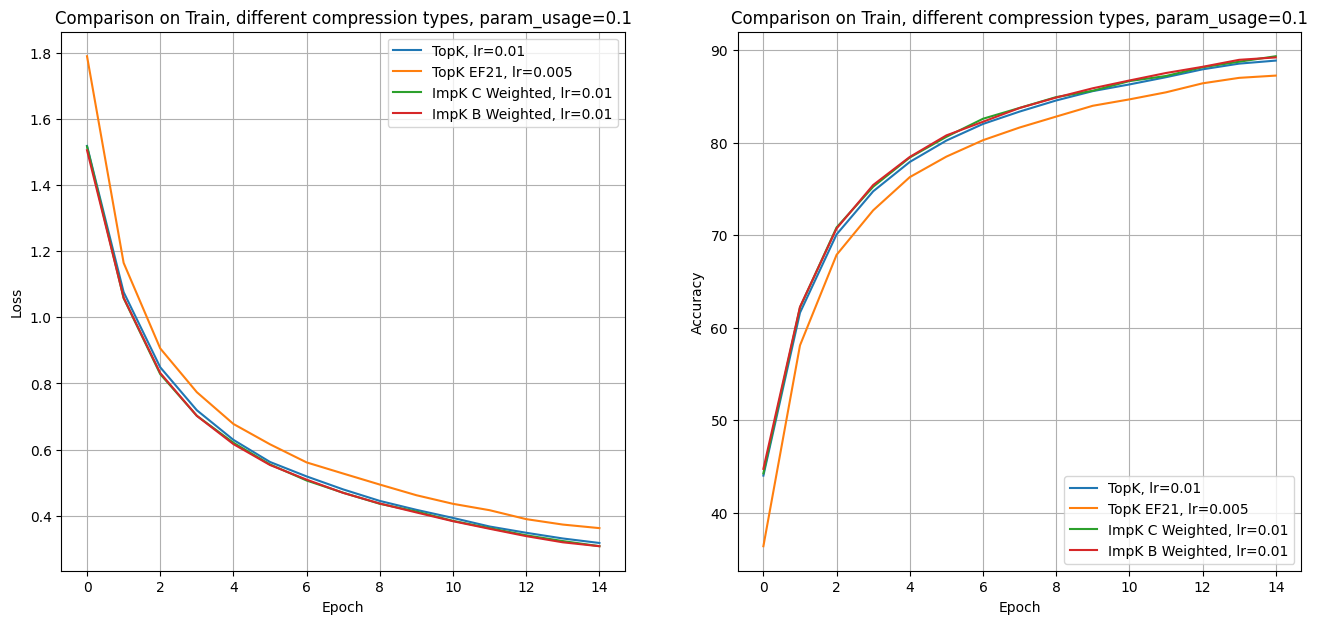

In [9]:
import numpy as np

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

names = {
    'mirror_descent_stochastic': 'ImpK B Stochastic',
    'mirror_descent_weighted_greedy': 'ImpK B Weighted, lr=0.01',
    'gradient_descent_weighted_greedy': 'ImpK C Weighted, lr=0.01',
    'mirror_descent_greedy': 'ImpK B',
    'mirror_descent_greedy_weighted': 'ImpK B Weighted 1',
    'random': 'RandK',
    'square_greedy': 'TopK, lr=0.01',
    'square_greedy_ef': 'TopK EF21, lr=0.005'
}

for compression_type in test_log:
    train_loss = np.array(train_log[compression_type])
    train_loss_mean = np.mean(train_loss, axis=0)
    train_loss_std = np.std(train_loss, axis=0)
    
    train_accuracy = np.array(train_acc[compression_type])
    train_accuracy_mean = np.mean(train_accuracy, axis=0)
    train_accuracy_std = np.std(train_accuracy, axis=0)
    
    iters = list(range(len(train_loss_mean)))
    
    axs[0].plot(iters, train_loss_mean, label=names[compression_type])
    axs[0].fill_between(iters, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, alpha=0.1)
    
    axs[1].plot(iters, train_accuracy_mean, label=names[compression_type])
    axs[1].fill_between(iters, train_accuracy_mean - train_accuracy_std, train_accuracy_mean + train_accuracy_std, alpha=0.1)

axs[0].set_title("Comparison on Train, different compression types, param_usage=0.1")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Train, different compression types, param_usage=0.1")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

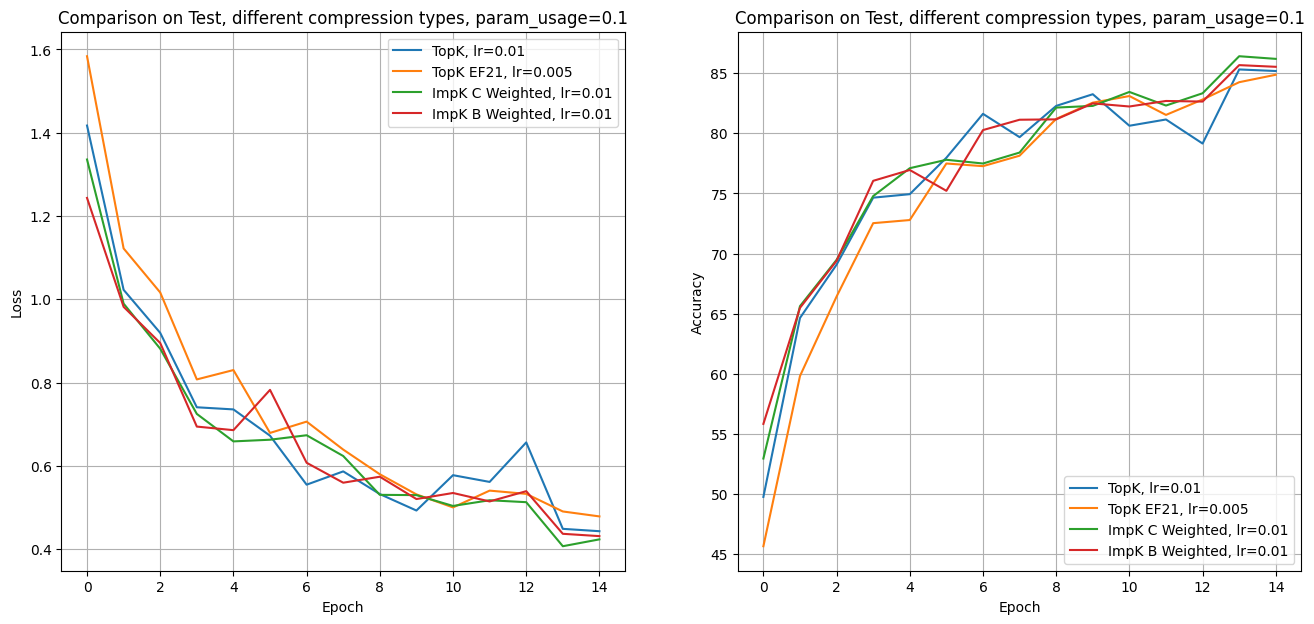

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

names = {
    'mirror_descent_stochastic': 'ImpK B Stochastic',
    'mirror_descent_weighted_greedy': 'ImpK B Weighted, lr=0.01',
    'gradient_descent_weighted_greedy': 'ImpK C Weighted, lr=0.01',
    'mirror_descent_greedy': 'ImpK B',
    'mirror_descent_greedy_weighted': 'ImpK B Weighted 1',
    'random': 'RandK',
    'square_greedy': 'TopK, lr=0.01',
    'square_greedy_ef': 'TopK EF21, lr=0.005'
}

for compression_type in test_log:
    axs[0].plot(test_log[compression_type], label=names[compression_type])
    axs[1].plot(test_acc[compression_type], label=names[compression_type])

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.1")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.1")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

In [15]:
compression_types = ['square_greedy', 'square_greedy_ef', 'mirror_descent_weighted_greedy', 'gradient_descent_weighted_greedy']
param_usage = 0.01
num_epochs = 30
lr = 0.01

train_log, train_acc = {}, {}
test_log, test_acc = {}, {}

for compression_type in compression_types:
    set_seed(42)
    net = ResNet18().to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    train_log[compression_type], train_acc[compression_type], test_log[compression_type], test_acc[compression_type] = train(net, optimizer, criterion, trainloader, testloader, num_epochs, compression_type=compression_type, param_usage=param_usage, lr=lr)

  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.685 | Train Acc: 37.350% (18675/50000)


  3%|▎         | 1/30 [00:13<06:19, 13.10s/it]

Validation Loss: 1.432 | Validation Acc: 46.980% (4698/10000)

Epoch: 1
Train Loss: 1.346 | Train Acc: 50.766% (25383/50000)


  7%|▋         | 2/30 [00:27<06:22, 13.66s/it]

Validation Loss: 1.496 | Validation Acc: 50.030% (5003/10000)

Epoch: 2
Train Loss: 1.174 | Train Acc: 57.688% (28844/50000)


 10%|█         | 3/30 [00:40<06:10, 13.74s/it]

Validation Loss: 1.293 | Validation Acc: 54.800% (5480/10000)

Epoch: 3
Train Loss: 1.055 | Train Acc: 62.380% (31190/50000)


 13%|█▎        | 4/30 [00:54<05:50, 13.47s/it]

Validation Loss: 0.973 | Validation Acc: 65.210% (6521/10000)

Epoch: 4
Train Loss: 0.967 | Train Acc: 65.844% (32922/50000)


 17%|█▋        | 5/30 [01:06<05:28, 13.16s/it]

Validation Loss: 1.014 | Validation Acc: 64.940% (6494/10000)

Epoch: 5
Train Loss: 0.549 | Train Acc: 80.690% (40345/50000)


 50%|█████     | 15/30 [03:16<03:15, 13.04s/it]

Validation Loss: 0.600 | Validation Acc: 79.400% (7940/10000)

Epoch: 15
Train Loss: 0.535 | Train Acc: 81.410% (40705/50000)


 53%|█████▎    | 16/30 [03:30<03:06, 13.31s/it]

Validation Loss: 0.583 | Validation Acc: 79.860% (7986/10000)

Epoch: 16
Train Loss: 0.517 | Train Acc: 82.148% (41074/50000)


 57%|█████▋    | 17/30 [03:44<02:53, 13.35s/it]

Validation Loss: 0.590 | Validation Acc: 79.530% (7953/10000)

Epoch: 17
Train Loss: 0.502 | Train Acc: 82.502% (41251/50000)


 60%|██████    | 18/30 [03:57<02:39, 13.29s/it]

Validation Loss: 0.578 | Validation Acc: 80.440% (8044/10000)

Epoch: 18
Train Loss: 0.491 | Train Acc: 82.840% (41420/50000)


 63%|██████▎   | 19/30 [04:10<02:26, 13.36s/it]

Validation Loss: 0.617 | Validation Acc: 79.000% (7900/10000)

Epoch: 19
Train Loss: 0.474 | Train Acc: 83.552% (41776/50000)


 67%|██████▋   | 20/30 [04:25<02:16, 13.65s/it]

Validation Loss: 0.586 | Validation Acc: 80.140% (8014/10000)

Epoch: 20
Train Loss: 0.463 | Train Acc: 83.886% (41943/50000)


 70%|███████   | 21/30 [04:39<02:03, 13.74s/it]

Validation Loss: 0.520 | Validation Acc: 82.090% (8209/10000)

Epoch: 21
Train Loss: 0.454 | Train Acc: 84.392% (42196/50000)


 73%|███████▎  | 22/30 [04:52<01:48, 13.53s/it]

Validation Loss: 0.544 | Validation Acc: 81.710% (8171/10000)

Epoch: 22
Train Loss: 0.445 | Train Acc: 84.404% (42202/50000)


 77%|███████▋  | 23/30 [05:05<01:34, 13.54s/it]

Validation Loss: 0.572 | Validation Acc: 80.970% (8097/10000)

Epoch: 23
Train Loss: 0.436 | Train Acc: 84.866% (42433/50000)


 80%|████████  | 24/30 [05:18<01:20, 13.48s/it]

Validation Loss: 0.592 | Validation Acc: 80.500% (8050/10000)

Epoch: 24
Train Loss: 0.423 | Train Acc: 85.276% (42638/50000)


 83%|████████▎ | 25/30 [05:32<01:07, 13.40s/it]

Validation Loss: 0.488 | Validation Acc: 83.590% (8359/10000)

Epoch: 25
Train Loss: 0.418 | Train Acc: 85.448% (42724/50000)


 87%|████████▋ | 26/30 [05:45<00:53, 13.40s/it]

Validation Loss: 0.591 | Validation Acc: 80.390% (8039/10000)

Epoch: 26
Train Loss: 0.412 | Train Acc: 85.706% (42853/50000)


 90%|█████████ | 27/30 [05:59<00:40, 13.53s/it]

Validation Loss: 0.532 | Validation Acc: 81.870% (8187/10000)

Epoch: 27
Train Loss: 0.396 | Train Acc: 86.144% (43072/50000)


 93%|█████████▎| 28/30 [06:13<00:27, 13.61s/it]

Validation Loss: 0.487 | Validation Acc: 83.470% (8347/10000)

Epoch: 28
Train Loss: 0.391 | Train Acc: 86.524% (43262/50000)


 97%|█████████▋| 29/30 [06:25<00:13, 13.35s/it]

Validation Loss: 0.589 | Validation Acc: 80.190% (8019/10000)

Epoch: 29
Train Loss: 0.384 | Train Acc: 86.426% (43213/50000)


100%|██████████| 30/30 [06:39<00:00, 13.33s/it]


Validation Loss: 0.564 | Validation Acc: 81.200% (8120/10000)


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 2.132 | Train Acc: 27.500% (13750/50000)


  3%|▎         | 1/30 [00:12<06:01, 12.48s/it]

Validation Loss: 2.511 | Validation Acc: 30.290% (3029/10000)

Epoch: 1
Train Loss: 1.820 | Train Acc: 37.588% (18794/50000)


  7%|▋         | 2/30 [00:26<06:15, 13.42s/it]

Validation Loss: 1.816 | Validation Acc: 37.700% (3770/10000)

Epoch: 2
Train Loss: 1.839 | Train Acc: 39.784% (19892/50000)


 10%|█         | 3/30 [00:41<06:15, 13.89s/it]

Validation Loss: 1.541 | Validation Acc: 45.570% (4557/10000)

Epoch: 3
Train Loss: 1.589 | Train Acc: 45.672% (22836/50000)


 13%|█▎        | 4/30 [00:55<06:03, 13.97s/it]

Validation Loss: 1.829 | Validation Acc: 40.960% (4096/10000)

Epoch: 4
Train Loss: 1.479 | Train Acc: 48.170% (24085/50000)


 17%|█▋        | 5/30 [01:08<05:45, 13.81s/it]

Validation Loss: 1.551 | Validation Acc: 47.800% (4780/10000)

Epoch: 5
Train Loss: 1.353 | Train Acc: 52.210% (26105/50000)


 20%|██        | 6/30 [01:21<05:23, 13.48s/it]

Validation Loss: 1.371 | Validation Acc: 52.290% (5229/10000)

Epoch: 6
Train Loss: 1.319 | Train Acc: 53.912% (26956/50000)


 23%|██▎       | 7/30 [01:35<05:12, 13.59s/it]

Validation Loss: 1.469 | Validation Acc: 53.110% (5311/10000)

Epoch: 7
Train Loss: 1.209 | Train Acc: 57.200% (28600/50000)


 27%|██▋       | 8/30 [01:48<04:53, 13.32s/it]

Validation Loss: 1.202 | Validation Acc: 58.580% (5858/10000)

Epoch: 8
Train Loss: 1.160 | Train Acc: 59.520% (29760/50000)


 30%|███       | 9/30 [02:01<04:38, 13.24s/it]

Validation Loss: 1.159 | Validation Acc: 59.540% (5954/10000)

Epoch: 9
Train Loss: 1.092 | Train Acc: 61.422% (30711/50000)


 33%|███▎      | 10/30 [02:14<04:25, 13.27s/it]

Validation Loss: 1.177 | Validation Acc: 59.670% (5967/10000)

Epoch: 10
Train Loss: 1.050 | Train Acc: 62.720% (31360/50000)


 37%|███▋      | 11/30 [02:27<04:09, 13.13s/it]

Validation Loss: 1.089 | Validation Acc: 62.200% (6220/10000)

Epoch: 11
Train Loss: 1.059 | Train Acc: 63.228% (31614/50000)


 40%|████      | 12/30 [02:40<03:55, 13.07s/it]

Validation Loss: 1.450 | Validation Acc: 56.600% (5660/10000)

Epoch: 12
Train Loss: 1.032 | Train Acc: 63.990% (31995/50000)


 43%|████▎     | 13/30 [02:53<03:41, 13.04s/it]

Validation Loss: 1.208 | Validation Acc: 59.240% (5924/10000)

Epoch: 13
Train Loss: 0.964 | Train Acc: 65.950% (32975/50000)


 47%|████▋     | 14/30 [03:06<03:32, 13.27s/it]

Validation Loss: 1.003 | Validation Acc: 64.730% (6473/10000)

Epoch: 14
Train Loss: 0.923 | Train Acc: 67.320% (33660/50000)


 50%|█████     | 15/30 [03:20<03:19, 13.29s/it]

Validation Loss: 0.951 | Validation Acc: 67.610% (6761/10000)

Epoch: 15
Train Loss: 0.902 | Train Acc: 68.076% (34038/50000)


 53%|█████▎    | 16/30 [03:33<03:07, 13.38s/it]

Validation Loss: 0.976 | Validation Acc: 66.630% (6663/10000)

Epoch: 16
Train Loss: 0.887 | Train Acc: 68.854% (34427/50000)


 57%|█████▋    | 17/30 [03:47<02:56, 13.56s/it]

Validation Loss: 0.937 | Validation Acc: 67.670% (6767/10000)

Epoch: 17
Train Loss: 0.859 | Train Acc: 69.644% (34822/50000)


 60%|██████    | 18/30 [04:00<02:38, 13.25s/it]

Validation Loss: 0.889 | Validation Acc: 69.160% (6916/10000)

Epoch: 18
Train Loss: 0.847 | Train Acc: 70.214% (35107/50000)


 63%|██████▎   | 19/30 [04:14<02:28, 13.54s/it]

Validation Loss: 0.972 | Validation Acc: 67.290% (6729/10000)

Epoch: 19
Train Loss: 0.830 | Train Acc: 70.828% (35414/50000)


 67%|██████▋   | 20/30 [04:27<02:15, 13.50s/it]

Validation Loss: 0.929 | Validation Acc: 67.710% (6771/10000)

Epoch: 20
Train Loss: 0.806 | Train Acc: 71.514% (35757/50000)


 70%|███████   | 21/30 [04:42<02:03, 13.72s/it]

Validation Loss: 0.866 | Validation Acc: 70.370% (7037/10000)

Epoch: 21
Train Loss: 0.798 | Train Acc: 72.004% (36002/50000)


 73%|███████▎  | 22/30 [04:55<01:49, 13.69s/it]

Validation Loss: 0.929 | Validation Acc: 68.430% (6843/10000)

Epoch: 22
Train Loss: 0.771 | Train Acc: 72.966% (36483/50000)


 77%|███████▋  | 23/30 [05:09<01:35, 13.71s/it]

Validation Loss: 1.050 | Validation Acc: 66.970% (6697/10000)

Epoch: 23
Train Loss: 0.761 | Train Acc: 73.270% (36635/50000)


 80%|████████  | 24/30 [05:23<01:22, 13.71s/it]

Validation Loss: 0.822 | Validation Acc: 71.790% (7179/10000)

Epoch: 24
Train Loss: 0.744 | Train Acc: 74.046% (37023/50000)


 83%|████████▎ | 25/30 [05:36<01:07, 13.42s/it]

Validation Loss: 0.793 | Validation Acc: 72.500% (7250/10000)

Epoch: 25
Train Loss: 0.735 | Train Acc: 74.160% (37080/50000)


 87%|████████▋ | 26/30 [05:48<00:53, 13.27s/it]

Validation Loss: 0.759 | Validation Acc: 74.150% (7415/10000)

Epoch: 26
Train Loss: 0.712 | Train Acc: 74.996% (37498/50000)


 90%|█████████ | 27/30 [06:01<00:39, 13.18s/it]

Validation Loss: 0.771 | Validation Acc: 73.380% (7338/10000)

Epoch: 27
Train Loss: 0.708 | Train Acc: 74.968% (37484/50000)


 93%|█████████▎| 28/30 [06:15<00:26, 13.34s/it]

Validation Loss: 0.820 | Validation Acc: 72.220% (7222/10000)

Epoch: 28
Train Loss: 0.699 | Train Acc: 75.606% (37803/50000)


 97%|█████████▋| 29/30 [06:28<00:13, 13.07s/it]

Validation Loss: 0.816 | Validation Acc: 71.880% (7188/10000)

Epoch: 29
Train Loss: 0.684 | Train Acc: 75.824% (37912/50000)


100%|██████████| 30/30 [06:41<00:00, 13.37s/it]


Validation Loss: 0.800 | Validation Acc: 73.020% (7302/10000)


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.684 | Train Acc: 37.340% (18670/50000)


  3%|▎         | 1/30 [00:22<10:58, 22.71s/it]

Validation Loss: 1.441 | Validation Acc: 46.640% (4664/10000)

Epoch: 1
Train Loss: 1.351 | Train Acc: 50.782% (25391/50000)


  7%|▋         | 2/30 [00:45<10:32, 22.60s/it]

Validation Loss: 1.335 | Validation Acc: 51.840% (5184/10000)

Epoch: 2
Train Loss: 1.190 | Train Acc: 57.178% (28589/50000)


 10%|█         | 3/30 [01:07<10:08, 22.53s/it]

Validation Loss: 1.116 | Validation Acc: 60.080% (6008/10000)

Epoch: 3
Train Loss: 1.071 | Train Acc: 61.700% (30850/50000)


 13%|█▎        | 4/30 [01:31<09:55, 22.90s/it]

Validation Loss: 1.057 | Validation Acc: 62.260% (6226/10000)

Epoch: 4
Train Loss: 0.984 | Train Acc: 65.104% (32552/50000)


 17%|█▋        | 5/30 [01:54<09:32, 22.91s/it]

Validation Loss: 1.047 | Validation Acc: 64.180% (6418/10000)

Epoch: 5
Train Loss: 0.900 | Train Acc: 68.040% (34020/50000)


 20%|██        | 6/30 [02:17<09:10, 22.93s/it]

Validation Loss: 0.913 | Validation Acc: 67.430% (6743/10000)

Epoch: 6
Train Loss: 0.826 | Train Acc: 70.996% (35498/50000)


 23%|██▎       | 7/30 [02:39<08:40, 22.62s/it]

Validation Loss: 0.827 | Validation Acc: 70.780% (7078/10000)

Epoch: 7
Train Loss: 0.772 | Train Acc: 72.840% (36420/50000)


 27%|██▋       | 8/30 [03:03<08:30, 23.20s/it]

Validation Loss: 0.796 | Validation Acc: 71.300% (7130/10000)

Epoch: 8
Train Loss: 0.721 | Train Acc: 74.846% (37423/50000)


 30%|███       | 9/30 [03:26<08:08, 23.26s/it]

Validation Loss: 0.769 | Validation Acc: 73.650% (7365/10000)

Epoch: 9
Train Loss: 0.685 | Train Acc: 75.980% (37990/50000)


 33%|███▎      | 10/30 [03:50<07:46, 23.33s/it]

Validation Loss: 0.759 | Validation Acc: 74.060% (7406/10000)

Epoch: 10
Train Loss: 0.652 | Train Acc: 77.084% (38542/50000)


 37%|███▋      | 11/30 [04:13<07:19, 23.15s/it]

Validation Loss: 0.724 | Validation Acc: 74.740% (7474/10000)

Epoch: 11
Train Loss: 0.621 | Train Acc: 78.288% (39144/50000)


 40%|████      | 12/30 [04:37<07:03, 23.54s/it]

Validation Loss: 0.734 | Validation Acc: 74.140% (7414/10000)

Epoch: 12
Train Loss: 0.599 | Train Acc: 79.216% (39608/50000)


 43%|████▎     | 13/30 [04:59<06:29, 22.92s/it]

Validation Loss: 0.673 | Validation Acc: 77.450% (7745/10000)

Epoch: 13
Train Loss: 0.572 | Train Acc: 80.014% (40007/50000)


 47%|████▋     | 14/30 [05:22<06:11, 23.20s/it]

Validation Loss: 0.687 | Validation Acc: 76.490% (7649/10000)

Epoch: 14
Train Loss: 0.553 | Train Acc: 80.560% (40280/50000)


 50%|█████     | 15/30 [05:47<05:52, 23.48s/it]

Validation Loss: 0.653 | Validation Acc: 77.740% (7774/10000)

Epoch: 15
Train Loss: 0.540 | Train Acc: 81.206% (40603/50000)


 53%|█████▎    | 16/30 [06:09<05:24, 23.20s/it]

Validation Loss: 0.618 | Validation Acc: 78.720% (7872/10000)

Epoch: 16
Train Loss: 0.524 | Train Acc: 81.884% (40942/50000)


 57%|█████▋    | 17/30 [06:32<04:59, 23.01s/it]

Validation Loss: 0.604 | Validation Acc: 79.220% (7922/10000)

Epoch: 17
Train Loss: 0.508 | Train Acc: 82.266% (41133/50000)


 60%|██████    | 18/30 [06:55<04:38, 23.21s/it]

Validation Loss: 0.598 | Validation Acc: 79.750% (7975/10000)

Epoch: 18
Train Loss: 0.490 | Train Acc: 82.936% (41468/50000)


 63%|██████▎   | 19/30 [07:20<04:19, 23.63s/it]

Validation Loss: 0.667 | Validation Acc: 77.680% (7768/10000)

Epoch: 19
Train Loss: 0.476 | Train Acc: 83.266% (41633/50000)


 67%|██████▋   | 20/30 [07:44<03:58, 23.86s/it]

Validation Loss: 0.578 | Validation Acc: 80.540% (8054/10000)

Epoch: 20
Train Loss: 0.461 | Train Acc: 84.014% (42007/50000)


 70%|███████   | 21/30 [08:08<03:33, 23.69s/it]

Validation Loss: 0.569 | Validation Acc: 80.490% (8049/10000)

Epoch: 21
Train Loss: 0.456 | Train Acc: 84.314% (42157/50000)


 73%|███████▎  | 22/30 [08:29<03:05, 23.13s/it]

Validation Loss: 0.535 | Validation Acc: 81.550% (8155/10000)

Epoch: 22
Train Loss: 0.447 | Train Acc: 84.418% (42209/50000)


 77%|███████▋  | 23/30 [08:53<02:43, 23.31s/it]

Validation Loss: 0.582 | Validation Acc: 80.780% (8078/10000)

Epoch: 23
Train Loss: 0.433 | Train Acc: 84.894% (42447/50000)


 80%|████████  | 24/30 [09:17<02:20, 23.48s/it]

Validation Loss: 0.598 | Validation Acc: 79.880% (7988/10000)

Epoch: 24
Train Loss: 0.424 | Train Acc: 85.206% (42603/50000)


 83%|████████▎ | 25/30 [09:39<01:55, 23.09s/it]

Validation Loss: 0.568 | Validation Acc: 80.710% (8071/10000)

Epoch: 25
Train Loss: 0.416 | Train Acc: 85.464% (42732/50000)


 87%|████████▋ | 26/30 [10:03<01:32, 23.23s/it]

Validation Loss: 0.508 | Validation Acc: 82.700% (8270/10000)

Epoch: 26
Train Loss: 0.404 | Train Acc: 85.976% (42988/50000)


 90%|█████████ | 27/30 [10:26<01:09, 23.15s/it]

Validation Loss: 0.539 | Validation Acc: 81.790% (8179/10000)

Epoch: 27
Train Loss: 0.400 | Train Acc: 85.996% (42998/50000)


 93%|█████████▎| 28/30 [10:49<00:46, 23.30s/it]

Validation Loss: 0.568 | Validation Acc: 81.060% (8106/10000)

Epoch: 28
Train Loss: 0.392 | Train Acc: 86.344% (43172/50000)


 97%|█████████▋| 29/30 [11:13<00:23, 23.25s/it]

Validation Loss: 0.665 | Validation Acc: 78.310% (7831/10000)

Epoch: 29
Train Loss: 0.381 | Train Acc: 86.776% (43388/50000)


100%|██████████| 30/30 [11:37<00:00, 23.27s/it]


Validation Loss: 0.520 | Validation Acc: 82.570% (8257/10000)


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 0
Train Loss: 1.680 | Train Acc: 37.642% (18821/50000)


  3%|▎         | 1/30 [00:21<10:37, 21.97s/it]

Validation Loss: 1.491 | Validation Acc: 44.820% (4482/10000)

Epoch: 1
Train Loss: 1.346 | Train Acc: 51.076% (25538/50000)


  7%|▋         | 2/30 [00:44<10:22, 22.23s/it]

Validation Loss: 1.241 | Validation Acc: 55.800% (5580/10000)

Epoch: 2
Train Loss: 1.172 | Train Acc: 57.832% (28916/50000)


 10%|█         | 3/30 [01:05<09:49, 21.84s/it]

Validation Loss: 1.088 | Validation Acc: 61.050% (6105/10000)

Epoch: 3
Train Loss: 1.045 | Train Acc: 62.896% (31448/50000)


 13%|█▎        | 4/30 [01:27<09:24, 21.72s/it]

Validation Loss: 0.960 | Validation Acc: 65.850% (6585/10000)

Epoch: 4
Train Loss: 0.945 | Train Acc: 66.670% (33335/50000)


 17%|█▋        | 5/30 [01:49<09:10, 22.00s/it]

Validation Loss: 1.029 | Validation Acc: 65.270% (6527/10000)

Epoch: 5
Train Loss: 0.862 | Train Acc: 69.522% (34761/50000)


 20%|██        | 6/30 [02:12<08:53, 22.23s/it]

Validation Loss: 0.875 | Validation Acc: 69.560% (6956/10000)

Epoch: 6
Train Loss: 0.790 | Train Acc: 72.372% (36186/50000)


 23%|██▎       | 7/30 [02:33<08:24, 21.92s/it]

Validation Loss: 0.819 | Validation Acc: 71.050% (7105/10000)

Epoch: 7
Train Loss: 0.735 | Train Acc: 74.288% (37144/50000)


 27%|██▋       | 8/30 [02:56<08:07, 22.14s/it]

Validation Loss: 0.752 | Validation Acc: 73.290% (7329/10000)

Epoch: 8
Train Loss: 0.693 | Train Acc: 75.824% (37912/50000)


 30%|███       | 9/30 [03:16<07:34, 21.67s/it]

Validation Loss: 0.725 | Validation Acc: 74.540% (7454/10000)

Epoch: 9
Train Loss: 0.660 | Train Acc: 76.818% (38409/50000)


 33%|███▎      | 10/30 [03:38<07:11, 21.58s/it]

Validation Loss: 0.765 | Validation Acc: 73.890% (7389/10000)

Epoch: 10
Train Loss: 0.638 | Train Acc: 77.598% (38799/50000)


 37%|███▋      | 11/30 [04:00<06:52, 21.73s/it]

Validation Loss: 0.687 | Validation Acc: 76.510% (7651/10000)

Epoch: 11
Train Loss: 0.604 | Train Acc: 79.050% (39525/50000)


 40%|████      | 12/30 [04:22<06:33, 21.89s/it]

Validation Loss: 0.712 | Validation Acc: 75.360% (7536/10000)

Epoch: 12
Train Loss: 0.581 | Train Acc: 79.990% (39995/50000)


 43%|████▎     | 13/30 [04:44<06:13, 21.95s/it]

Validation Loss: 0.661 | Validation Acc: 77.860% (7786/10000)

Epoch: 13
Train Loss: 0.566 | Train Acc: 80.288% (40144/50000)


 47%|████▋     | 14/30 [05:06<05:49, 21.83s/it]

Validation Loss: 0.621 | Validation Acc: 78.750% (7875/10000)

Epoch: 14
Train Loss: 0.545 | Train Acc: 81.020% (40510/50000)


 50%|█████     | 15/30 [05:28<05:29, 21.99s/it]

Validation Loss: 0.638 | Validation Acc: 78.580% (7858/10000)

Epoch: 15
Train Loss: 0.530 | Train Acc: 81.634% (40817/50000)


 53%|█████▎    | 16/30 [05:50<05:08, 22.02s/it]

Validation Loss: 0.579 | Validation Acc: 80.230% (8023/10000)

Epoch: 16
Train Loss: 0.511 | Train Acc: 82.356% (41178/50000)


 57%|█████▋    | 17/30 [06:13<04:48, 22.21s/it]

Validation Loss: 0.608 | Validation Acc: 79.320% (7932/10000)

Epoch: 17
Train Loss: 0.499 | Train Acc: 82.448% (41224/50000)


 60%|██████    | 18/30 [06:35<04:27, 22.26s/it]

Validation Loss: 0.541 | Validation Acc: 81.900% (8190/10000)

Epoch: 18
Train Loss: 0.482 | Train Acc: 83.194% (41597/50000)


 63%|██████▎   | 19/30 [06:58<04:05, 22.33s/it]

Validation Loss: 0.608 | Validation Acc: 79.650% (7965/10000)

Epoch: 19
Train Loss: 0.472 | Train Acc: 83.516% (41758/50000)


 67%|██████▋   | 20/30 [07:20<03:42, 22.29s/it]

Validation Loss: 0.607 | Validation Acc: 79.620% (7962/10000)

Epoch: 20
Train Loss: 0.460 | Train Acc: 84.174% (42087/50000)


 70%|███████   | 21/30 [07:41<03:16, 21.84s/it]

Validation Loss: 0.548 | Validation Acc: 81.000% (8100/10000)

Epoch: 21
Train Loss: 0.450 | Train Acc: 84.414% (42207/50000)


 73%|███████▎  | 22/30 [08:03<02:56, 22.01s/it]

Validation Loss: 0.531 | Validation Acc: 81.570% (8157/10000)

Epoch: 22
Train Loss: 0.443 | Train Acc: 84.780% (42390/50000)


 77%|███████▋  | 23/30 [08:25<02:34, 22.10s/it]

Validation Loss: 0.588 | Validation Acc: 79.770% (7977/10000)

Epoch: 23
Train Loss: 0.434 | Train Acc: 84.734% (42367/50000)


 80%|████████  | 24/30 [08:48<02:13, 22.20s/it]

Validation Loss: 0.506 | Validation Acc: 82.660% (8266/10000)

Epoch: 24
Train Loss: 0.420 | Train Acc: 85.322% (42661/50000)


 83%|████████▎ | 25/30 [09:09<01:49, 21.91s/it]

Validation Loss: 0.531 | Validation Acc: 82.070% (8207/10000)

Epoch: 25
Train Loss: 0.414 | Train Acc: 85.598% (42799/50000)


 87%|████████▋ | 26/30 [09:30<01:26, 21.66s/it]

Validation Loss: 0.540 | Validation Acc: 82.180% (8218/10000)

Epoch: 26
Train Loss: 0.411 | Train Acc: 85.718% (42859/50000)


 90%|█████████ | 27/30 [09:53<01:05, 21.95s/it]

Validation Loss: 0.509 | Validation Acc: 82.390% (8239/10000)

Epoch: 27
Train Loss: 0.397 | Train Acc: 86.200% (43100/50000)


 93%|█████████▎| 28/30 [10:15<00:43, 21.88s/it]

Validation Loss: 0.523 | Validation Acc: 82.380% (8238/10000)

Epoch: 28
Train Loss: 0.387 | Train Acc: 86.434% (43217/50000)


 97%|█████████▋| 29/30 [10:35<00:21, 21.45s/it]

Validation Loss: 0.517 | Validation Acc: 82.730% (8273/10000)

Epoch: 29
Train Loss: 0.388 | Train Acc: 86.464% (43232/50000)


100%|██████████| 30/30 [10:58<00:00, 21.95s/it]

Validation Loss: 0.482 | Validation Acc: 83.780% (8378/10000)


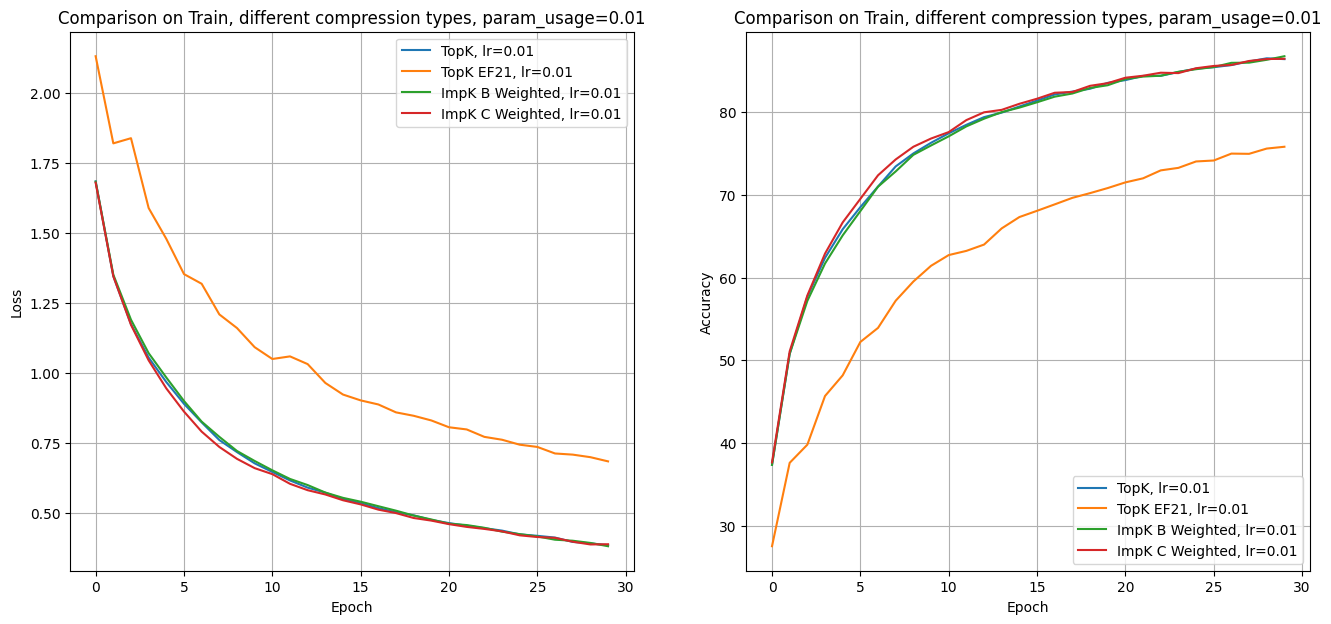

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

names = {
    'mirror_descent_stochastic': 'ImpK B Stochastic',
    'mirror_descent_weighted_greedy': 'ImpK B Weighted, lr=0.01',
    'gradient_descent_weighted_greedy': 'ImpK C Weighted, lr=0.01',
    'mirror_descent_greedy': 'ImpK B',
    'mirror_descent_greedy_weighted': 'ImpK B Weighted 1',
    'random': 'RandK',
    'square_greedy': 'TopK, lr=0.01',
    'square_greedy_ef': 'TopK EF21, lr=0.01'
}

for compression_type in test_log:
    axs[0].plot(train_log[compression_type], label=names[compression_type])
    axs[1].plot(train_acc[compression_type], label=names[compression_type])

axs[0].set_title("Comparison on Train, different compression types, param_usage=0.01")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Train, different compression types, param_usage=0.01")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

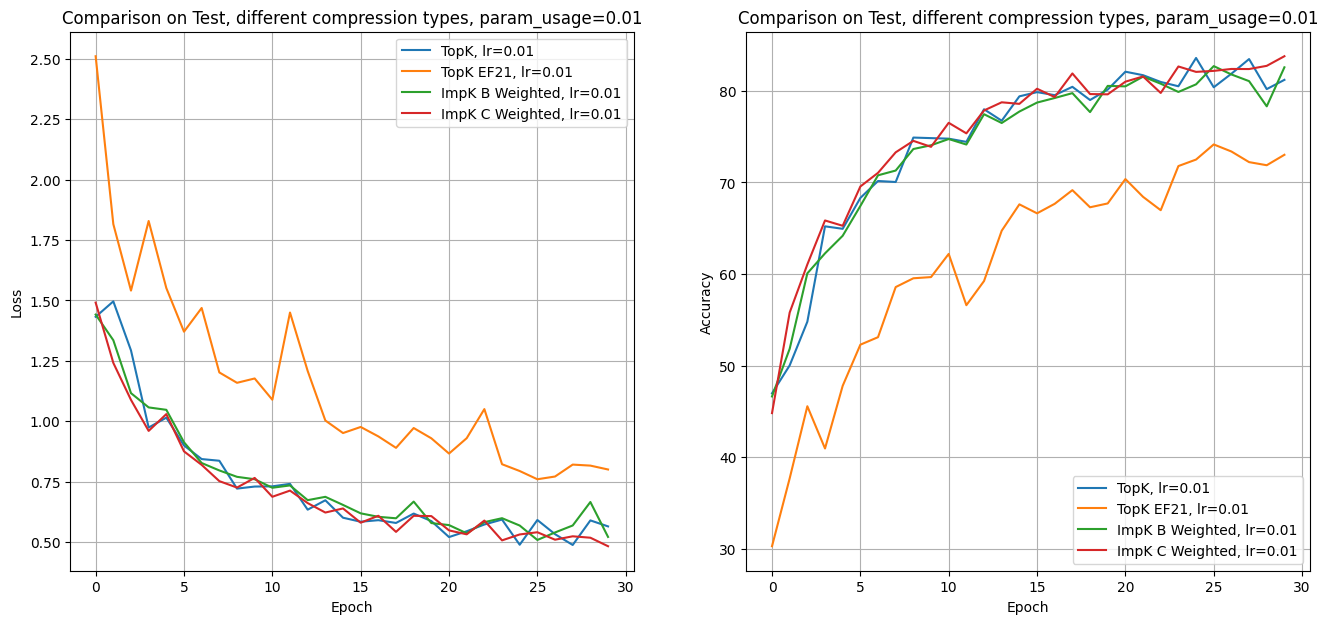

In [17]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

names = {
    'mirror_descent_stochastic': 'ImpK B Stochastic',
    'mirror_descent_weighted_greedy': 'ImpK B Weighted, lr=0.01',
    'gradient_descent_weighted_greedy': 'ImpK C Weighted, lr=0.01',
    'mirror_descent_greedy': 'ImpK B',
    'mirror_descent_greedy_weighted': 'ImpK B Weighted 1',
    'random': 'RandK',
    'square_greedy': 'TopK, lr=0.01',
    'square_greedy_ef': 'TopK EF21, lr=0.01'
}

for compression_type in test_log:
    axs[0].plot(test_log[compression_type], label=names[compression_type])
    axs[1].plot(test_acc[compression_type], label=names[compression_type])

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.01")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.01")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

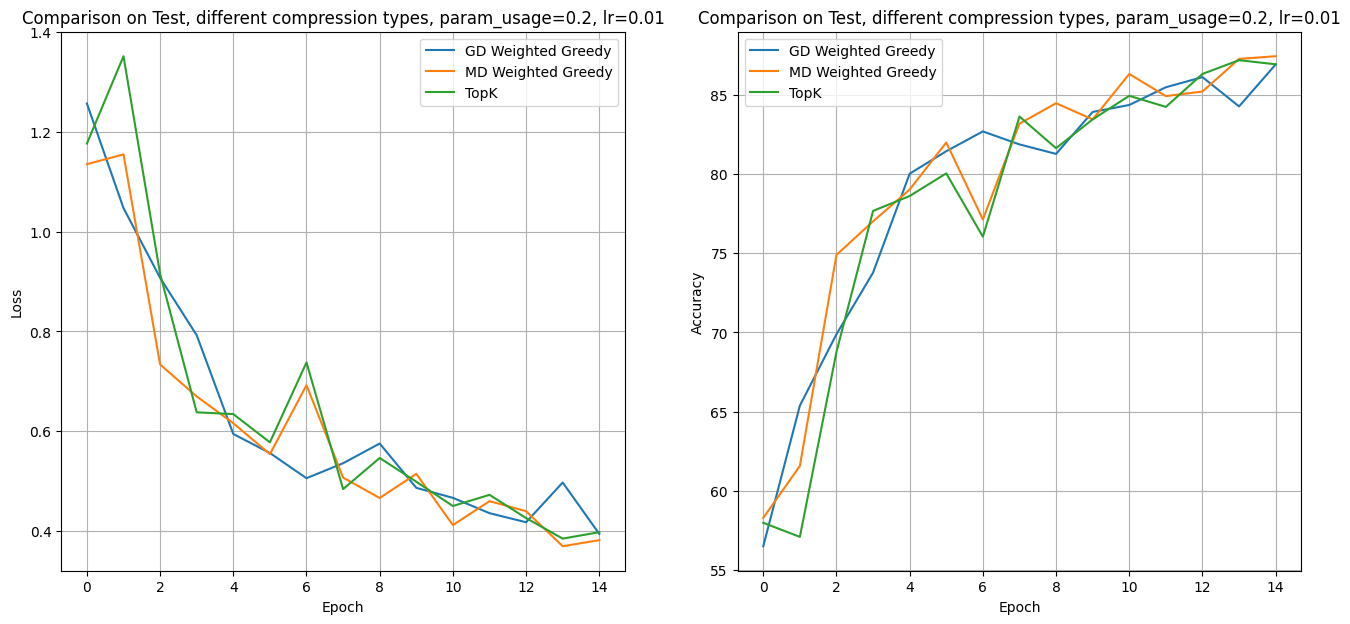

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

names = {
    'mirror_descent_stochastic': 'MD Stochastic',
    'mirror_descent_weighted_greedy': 'MD Weighted Greedy',
    'gradient_descent_weighted_greedy': 'GD Weighted Greedy',
    'mirror_descent_greedy_topk': 'TopK+MD Greedy',
    'mirror_descent_greedy': 'MD Greedy',
    'mirror_descent_greedy_weighted': 'MD Greedy Weighted',
    'random': 'RandK',
    'square_greedy': 'TopK'
}

for compression_type in test_log:
    axs[0].plot(test_log[compression_type], label=names[compression_type])
    axs[1].plot(test_acc[compression_type], label=names[compression_type])

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.2, lr=0.01")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.2, lr=0.01")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

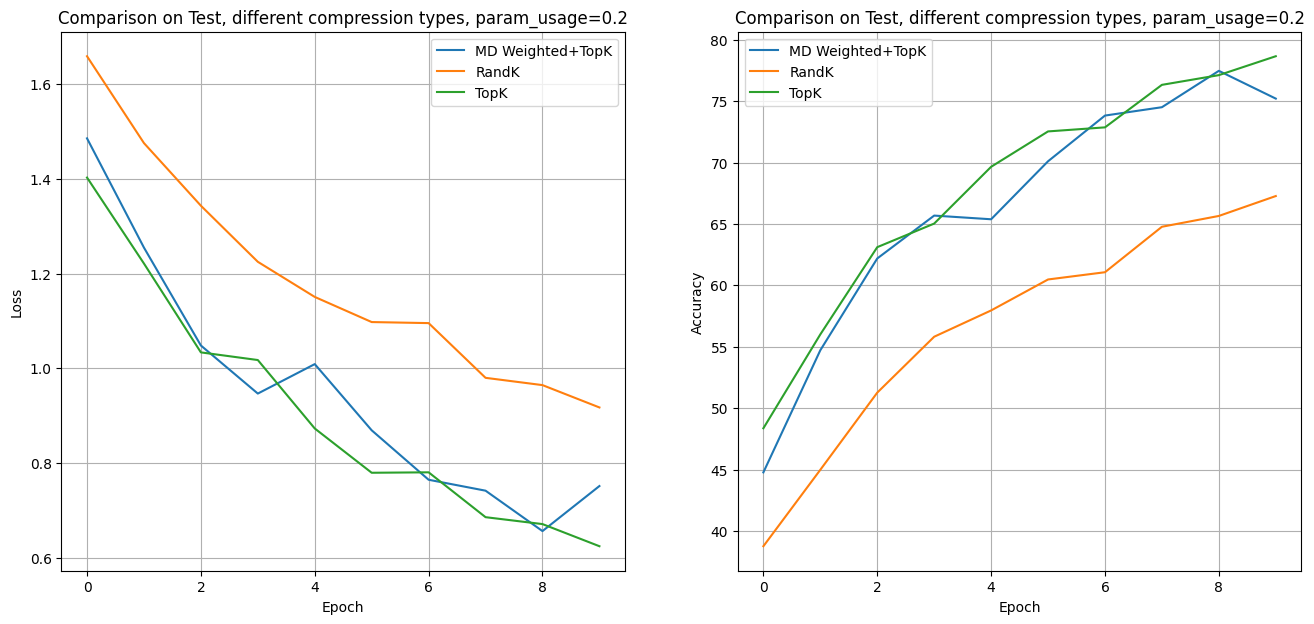

In [26]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

names = {
    'mirror_descent_weighted_topk': 'MD Weighted+TopK',
    'mirror_descent_greedy_topk': 'TopK+MD Greedy',
    'mirror_descent_greedy': 'MD Greedy',
    'mirror_descent_greedy_weighted': 'MD Weighted',
    'random': 'RandK',
    'square_greedy': 'TopK'
}

for compression_type in test_log:
    axs[0].plot(test_log[compression_type], label=names[compression_type])
    axs[1].plot(test_acc[compression_type], label=names[compression_type])

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

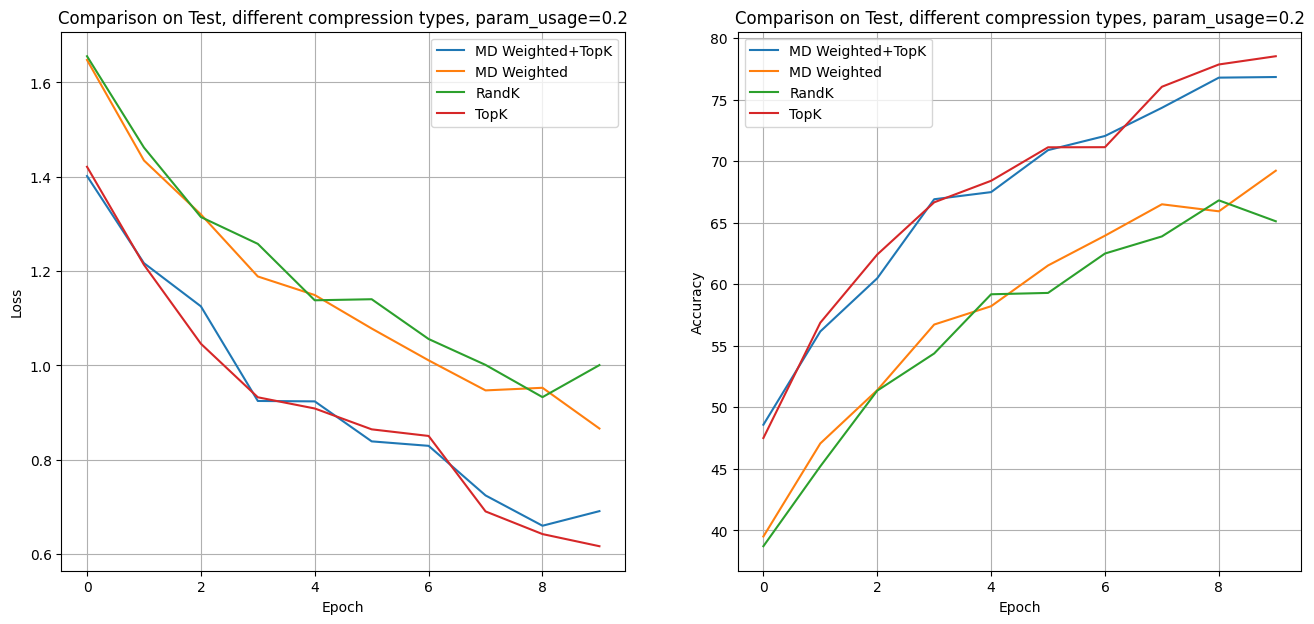

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

names = {
    'mirror_descent_weighted_topk': 'MD Weighted+TopK',
    'mirror_descent_greedy_topk': 'TopK+MD Greedy',
    'mirror_descent_greedy': 'MD Greedy',
    'mirror_descent_greedy_weighted': 'MD Weighted',
    'random': 'RandK',
    'square_greedy': 'TopK'
}

for compression_type in test_log:
    axs[0].plot(test_log[compression_type], label=names[compression_type])
    axs[1].plot(test_acc[compression_type], label=names[compression_type])

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

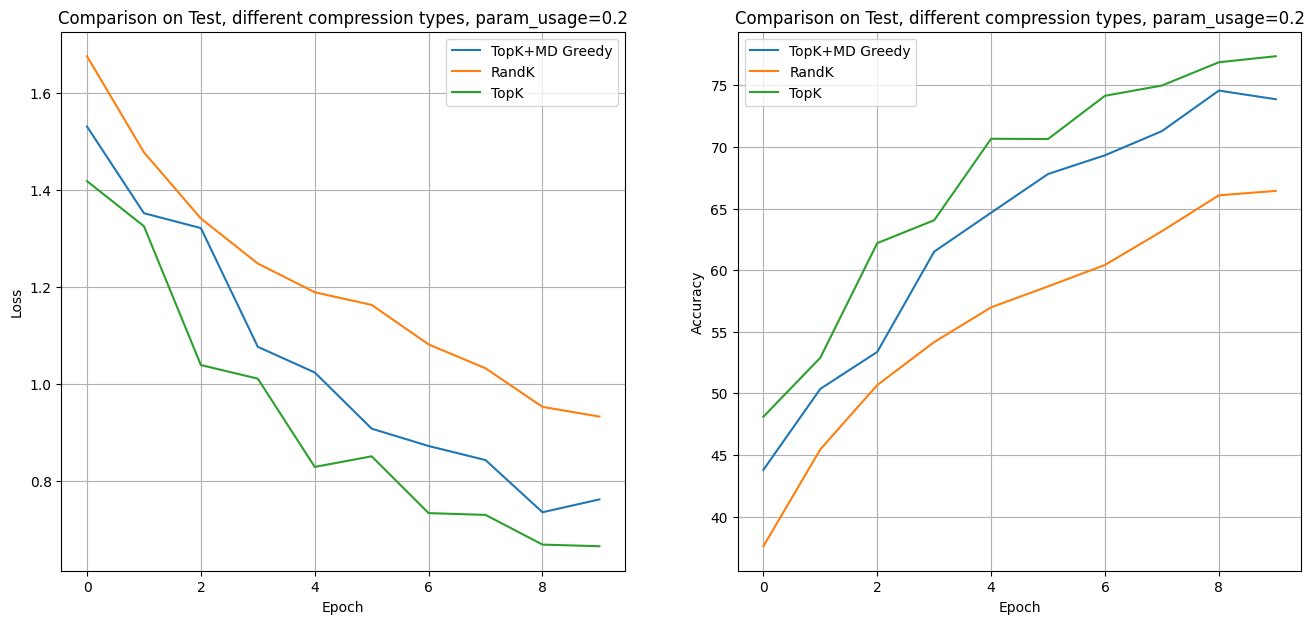

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

names = {
    'mirror_descent_greedy_topk': 'TopK+MD Greedy',
    'random': 'RandK',
    'square_greedy': 'TopK'
}

for compression_type in test_log:
    axs[0].plot(test_log[compression_type], label=names[compression_type])
    axs[1].plot(test_acc[compression_type], label=names[compression_type])

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

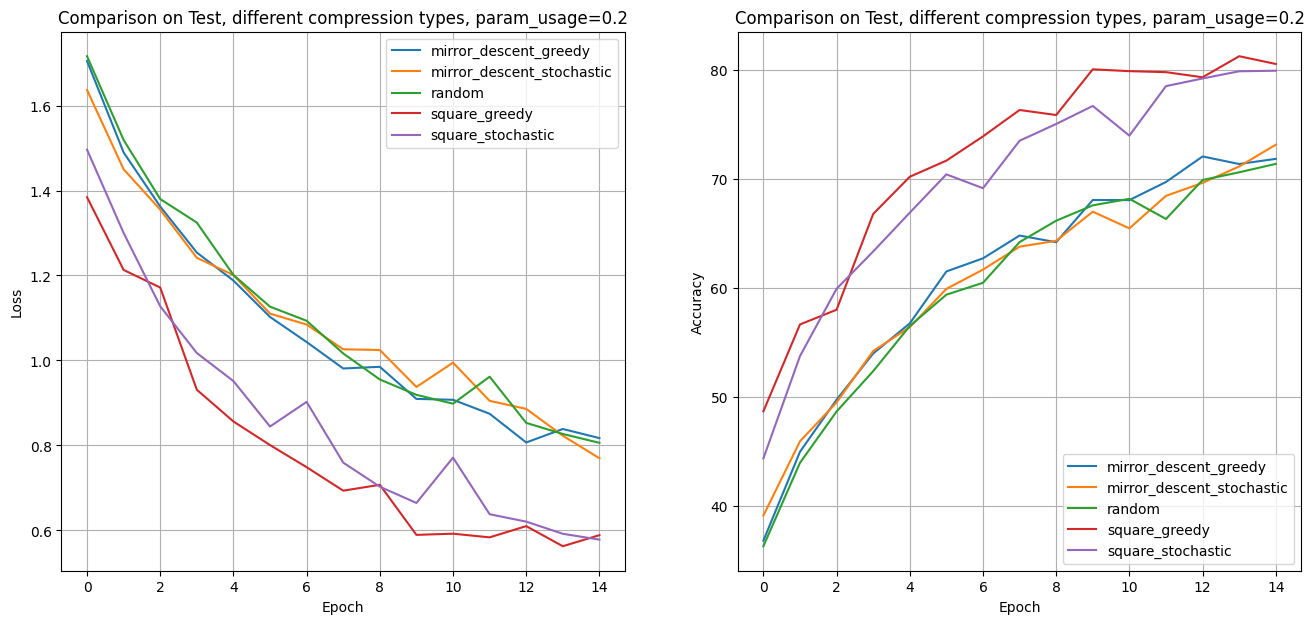

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

for compression_type in compression_types:
    axs[0].plot(test_log[compression_type], label=compression_type)
    axs[1].plot(test_acc[compression_type], label=compression_type)

axs[0].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title("Comparison on Test, different compression types, param_usage=0.2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()